# Old STF Partials Generation

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def compute_partial_derivatives(device='cpu', plot=False):
    # Define constants for Tuff/Rhyolite based on the given table
    h0 = torch.tensor(122.0, requires_grad=False, device=device)
    R0 = torch.tensor(202.0, requires_grad=False, device=device)
    gamma0 = torch.tensor(1.0, requires_grad=False, device=device)  # assuming a value for gamma0
    P10 = torch.tensor(3.6E6, requires_grad=False, device=device)
    P20 = torch.tensor(5.0E6, requires_grad=False, device=device)
    C = torch.tensor(3500.0, requires_grad=False, device=device)
    n = torch.tensor(2.4, requires_grad=False, device=device)
    lambda_ = torch.tensor(1.0, requires_grad=False, device=device)  # assuming a value for lambda
    mu = torch.tensor(1.0, requires_grad=False, device=device)  # assuming a value for mu

    # Define h, W, t as tensors with requires_grad=True to compute derivatives
    h = torch.tensor(150.0, requires_grad=True, device=device)  # example value
    w = torch.tensor(1.0, requires_grad=True, device=device)  # given value
    t = torch.linspace(0, 1.0, steps=100, requires_grad=True, device=device)  # given final time of 1.0

    # Define H(t), Heaviside step function
    H_t = (t >= 0).float()

    # Compute R_el based on equation (7) and (8)
    R_el = R0 * (h0 / h).pow(1/n) * w.pow(1/3)

    # Compute gamma based on equation in the screenshot
    gamma = gamma0 * (R0 / R_el)

    # Compute beta based on the given equation
    beta = (lambda_ + 2 * mu) / (4 * mu)

    # Ensure beta is not zero to avoid division by zero
    beta = torch.clamp(beta, min=1e-6)

    # Compute w0 based on the given equation
    w0 = C / R_el

    # Compute alpha and p based on the given equations
    alpha = w0 / (2 * beta)

    # Ensure alpha is not zero to avoid division by zero
    alpha = torch.clamp(alpha, min=1e-6)

    # Calculate and print the expression inside the square root
    sqrt_input = 1 / (2 * beta) - 1 / (4 * beta**2)
    print(f'sqrt_input: {sqrt_input}')

    # Ensure sqrt_input is non-negative to avoid NaN values
    sqrt_input = torch.clamp(sqrt_input, min=1e-6)

    p = w0 * torch.sqrt(sqrt_input)

    # Debugging: Print intermediate values
    print(f'R_el: {R_el}')
    print(f'gamma: {gamma}')
    print(f'beta: {beta}')
    print(f'w0: {w0}')
    print(f'alpha: {alpha}')
    print(f'p: {p}')

    # Define f(t) based on equation (3)
    def f_t(R_el, t):
        return (R_el / (4 * alpha)) * (C**2 / (beta * p)) * H_t * torch.exp(-alpha * t) * torch.sin(p * t)

    # # Define B(t) based on equation (2)
    # def B_t(R_el, t):
    #     P0_t = P10 * (h / h0)  # P1 - P2 with P1 and P2
    #     P2_t = P20 * (h0 / h).pow(1/3) * (R0 / R_el).pow(3) * w.pow(0.87)
    #     return (torch.exp(-gamma * t) * P0_t + P2_t) * H_t
    
    def B_t(R_el, t):
        P0_t = P10 * (h / h0)  # P1 - P2 with P1 and P2
        P2_t = P20 * (h0 / h).pow(1/3) * (R0 / R_el).pow(3) * w.pow(0.87)
        return (torch.exp(-gamma * t) * P0_t + (1-torch.exp(-gamma * t))*P2_t) * H_t # fixed

    # Compute the time derivative of f(t)
    f_t_val = f_t(R_el, t)
    df_dt = torch.autograd.grad(f_t_val.sum(), t, create_graph=True)[0]

    # Reshape for conv1d: [batch_size, in_channels, sequence_length]
    df_dt_reshaped = df_dt.view(1, 1, -1)
    B_t_val = B_t(R_el, t)
    B_t_reshaped = B_t_val.view(1, 1, -1)

    # Perform convolution using conv1d
    S_t_conv = F.conv1d(-df_dt_reshaped, B_t_reshaped, padding='same')
    
    S_t = S_t_conv.view(-1)[:t.size(0)]  # Ensure S_t has the same length as t

    if plot:
        # Convert S_t, f_t_val, and B_t_val to CPU for plotting
        S_t_cpu = S_t.detach().cpu().numpy()
        f_t_cpu = f_t_val.detach().cpu().numpy()
        B_t_cpu = B_t_val.detach().cpu().numpy()
        t_cpu = t.detach().cpu().numpy()

        # Plot S(t) on primary y-axis and f(t) on secondary y-axis
        fig, ax1 = plt.subplots(figsize=(10, 6))
        plt.grid(True)
        ax1.plot(t_cpu, S_t_cpu, label='S(t)', color='tab:blue')
        ax1.set_xlabel('Time (t)')
        ax1.set_ylabel('S(t)', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')

        ax2 = ax1.twinx()
        ax2.plot(t_cpu, f_t_cpu, label='f(t)', color='tab:orange')
        ax2.set_ylabel('f(t)', color='tab:orange')
        ax2.tick_params(axis='y', labelcolor='tab:orange')

        # Combine legends
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

        plt.title('Plots of S(t) and f(t)')
        plt.show()

        # Plot B(t) separately
        plt.figure(figsize=(10, 6))
        plt.grid(True)
        plt.plot(t_cpu, B_t_cpu, label='B(t)', color='tab:green')
        plt.xlabel('Time (t)')
        plt.ylabel('B(t)')
        plt.title('Plot of B(t)')
        plt.legend()
        plt.show()

    # Compute dS(t)/dw and dS(t)/dh using autograd
    S_t_sum = S_t.sum()  # sum to get a scalar for backward
    S_t_sum.backward()

    dS_dW = w.grad
    dS_dh = h.grad

    return dS_dW, dS_dh

# Example usage on GPU (if available)
if torch.cuda.is_available():
    dS_dW, dS_dh = compute_partial_derivatives(device='cuda', plot=True)
    print(f'dS/dW (GPU): {dS_dW}')
    print(f'dS/dh (GPU): {dS_dh}')


KeyboardInterrupt: 

# New STF Partials Generation

R_el: 185.3374786376953
gamma: 28.337495803833008
beta: 0.7497966289520264
w0: 18.884469985961914
alpha: 12.593061447143555
p: 8.901017189025879
(R_el*pv): 648681.19


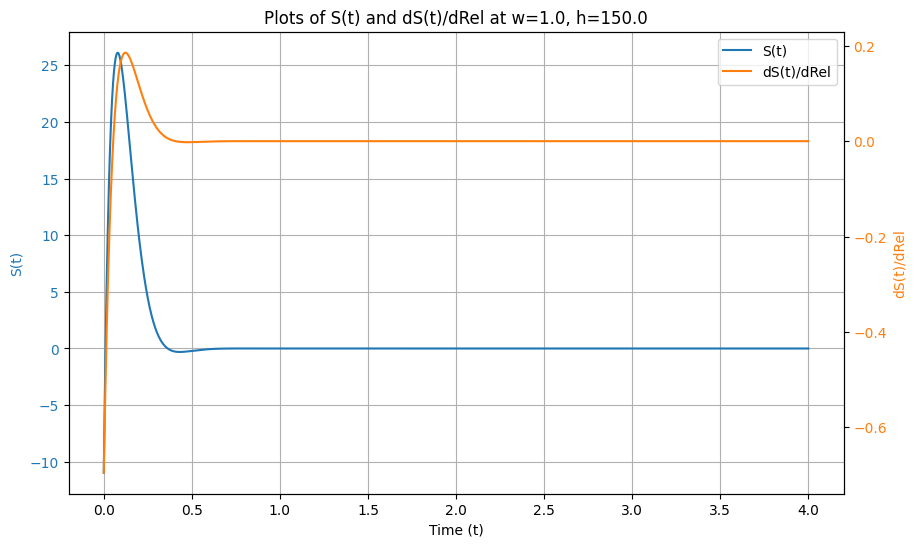

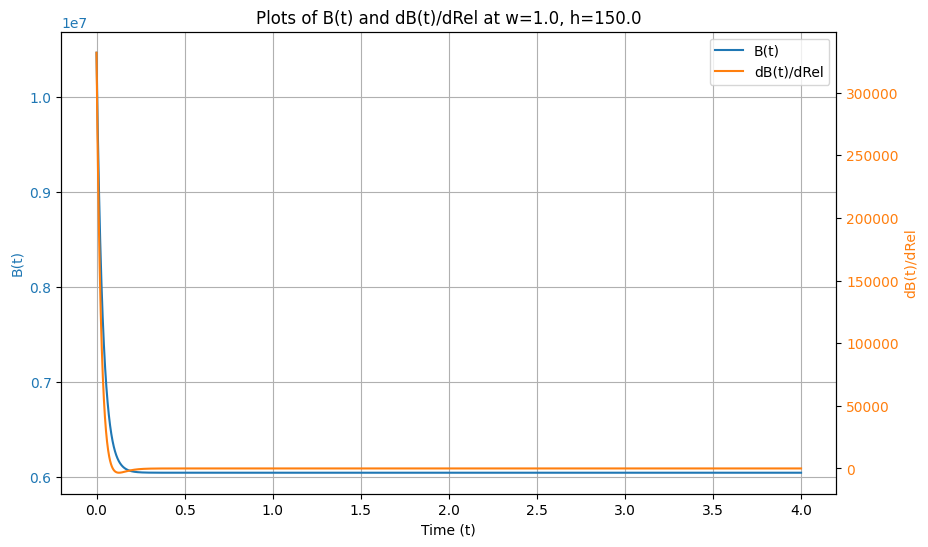

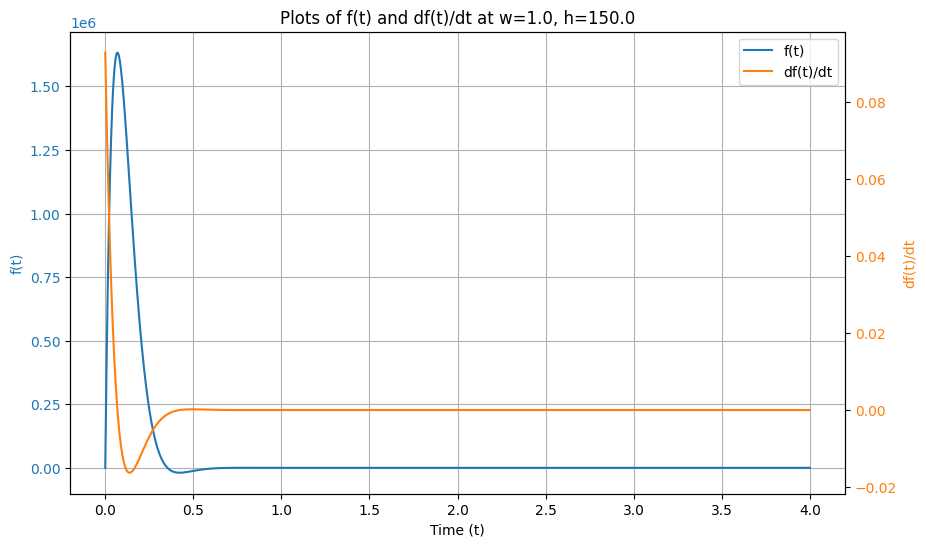

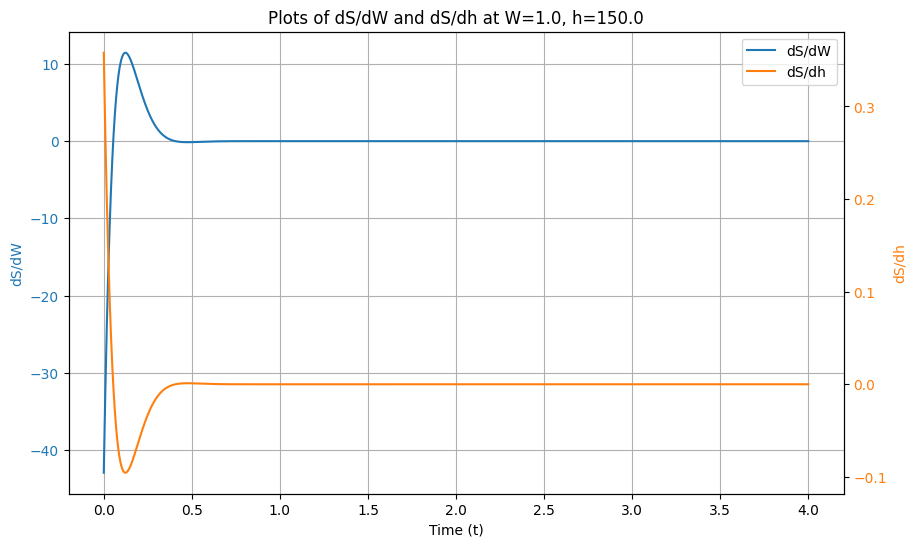

Analytical
dS/dW: 803.462158203125
dS/dh: -6.695517063140869
Numerical
dS/dW: 2185.536376953125
dS/dh: 2.3921327590942383


{'dS_dW_ana': array([-4.2955982e+01, -4.1688450e+01, -4.0442638e+01, ...,
        -8.0792721e-22, -5.5120264e-22, -2.8200836e-22], dtype=float32),
 'dS_dh_ana': array([3.5796651e-01, 3.4740373e-01, 3.3702198e-01, ..., 6.7327267e-24,
        4.5933552e-24, 2.3500695e-24], dtype=float32),
 'df_dt': array([9.2668734e-02, 9.0352505e-02, 8.8072672e-02, ..., 8.7932069e-24,
        8.8590026e-24, 8.9210812e-24], dtype=float32),
 'S_t': array([-1.0962373e+01, -9.7513752e+00, -8.5681953e+00, ...,
        -4.2381253e-22, -2.8524514e-22, -1.4397410e-22], dtype=float32),
 'f_t': array([ 0.0000000e+00,  5.9374094e+04,  1.1725715e+05, ...,
        -7.8864448e-16, -7.8291769e-16, -7.7714950e-16], dtype=float32),
 'B_t': array([10468830. , 10345132. , 10224890. , ...,  6042600.5,  6042600.5,
         6042600.5], dtype=float32),
 't': array([0.0000000e+00, 1.0002501e-03, 2.0005002e-03, ..., 3.9979994e+00,
        3.9989998e+00, 4.0000000e+00], dtype=float32),
 'dB_t_dRel': array([ 3.3192028e+05,  3.191

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

import torch

# Define the dictionary with constants for each material
constants_dict = {
    "Tuff/Rhyolite": {
        "h0": 122.0, "R0": 202.0, "gamma0": 26.0, "P10": 3.6E6, "P20": 5.0E6, "pv": 3500.0, "sv": 2021.0, "n": 2.4, "rho": 2000.0
    },
    "Granite": {
        "h0": 122.0, "R0": 321.0, "gamma0": 34.0, "P10": 4.6E6, "P20": 2.4E6, "pv": 5500.0, "sv": 3175.0, "n": 2.4, "rho": 2550.0
    },
    "Salt": {
        "h0": 122.0, "R0": 478.0, "gamma0": 31.0, "P10": 5.5E6, "P20": 0.8E6, "pv": 4670.0, "sv": 2696.0, "n": 1.87, "rho": 2200.0
    },
    "Shale": {
        "h0": 122.0, "R0": 265.0, "gamma0": 42.0, "P10": 4.2E6, "P20": 2.5E6, "pv": 4320.0, "sv": 2495.0, "n": 2.4, "rho": 2350.0
    },
    "Wet Tuff": {
        "h0": 122.0, "R0": 202.0, "gamma0": 26.0, "P10": 3.6E6, "P20": 5.0E6, "pv": 2400.0, "sv": 1300.0, "n": 2.4, "rho": 1915.0
    },
    "Wet Granite": {
        "h0": 122.0, "R0": 321.0, "gamma0": 34.0, "P10": 4.6E6, "P20": 2.4E6, "pv": 5350.0, "sv": 2795.0, "n": 2.4, "rho": 2650.0
    }
}

# Function to populate variables from the dictionary based on material name
def get_constants(material_name, device):
    if material_name in constants_dict:
        material_constants = constants_dict[material_name]
        h0 = torch.tensor(material_constants["h0"], requires_grad=False, device=device)
        R0 = torch.tensor(material_constants["R0"], requires_grad=False, device=device)
        gamma0 = torch.tensor(material_constants["gamma0"], requires_grad=False, device=device)
        P10 = torch.tensor(material_constants["P10"], requires_grad=False, device=device)
        P20 = torch.tensor(material_constants["P20"], requires_grad=False, device=device)
        pv = torch.tensor(material_constants["pv"], requires_grad=False, device=device)
        sv = torch.tensor(material_constants["sv"], requires_grad=False, device=device)
        n = torch.tensor(material_constants["n"], requires_grad=False, device=device)
        rho = torch.tensor(material_constants["rho"], requires_grad=False, device=device)
        return h0, R0, gamma0, P10, P20, pv, sv, n, rho
    else:
        raise ValueError(f"Material '{material_name}' not found in the constants dictionary.")



def compute_partial_derivatives(w=1.0, h=150.0, material='Tuff/Rhyolite', device='cpu', plot=False):
    h0, R0, gamma0, P10, P20, pv, sv, n, rho = get_constants(material, device)
    
    mu = rho*(sv**2)
    lam = rho*(pv**2)-2*mu   

    # Define h, w, t as tensors with requires_grad=True to compute derivatives
    h = torch.tensor(h, requires_grad=True, device=device) 
    w = torch.tensor(w, requires_grad=True, device=device)  
    t = torch.linspace(0, 4.0, steps=4000, requires_grad=True, device=device) 
    def Heaviside(t):
        return torch.where(t >= 0, torch.tensor(1.0), torch.tensor(0.0))

    # Define H(t), Heaviside step function
    H_t = Heaviside(t)

    # Compute R_el based on equation (7) and (8)
    R_el = R0 * (h0 / h).pow(1/n) * w.pow(1/3)

    # Compute gamma based on equation in the screenshot
    gamma = gamma0 * (R0 / R_el)

    # Compute beta based on the given equation
    beta = (lam + 2 * mu) / (4 * mu)

    # Compute w0 based on the given equation
    w0 = pv / R_el

    # Compute alpha and p based on the given equations
    alpha = w0 / (2 * beta)

    p = w0 * torch.sqrt(1 / (2 * beta) - 1 / (4 * beta**2))

    # Debugging: Print intermediate values
    print(f'R_el: {R_el}')
    print(f'gamma: {gamma}')
    print(f'beta: {beta}')
    print(f'w0: {w0}')
    print(f'alpha: {alpha}')
    print(f'p: {p}')
    print(f'(R_el*pv): {(R_el*pv):.2f}')

    # Define f(t) based on equation (3)
    def f_t(R_el, t):
        return (R_el / (4 * alpha)) * (pv**2 / (beta * p)) * H_t * torch.exp(-alpha * t) * torch.sin(p * t)
    
    def df_t_dt(R_el, mu, pv, beta, p, alpha, t):
        A = (R_el / (4 * mu)) * (pv**2 / (beta * p))
        return A * H_t * torch.exp(-alpha * t) * (-alpha * torch.sin(p * t) + p * torch.cos(p * t))

    # Define B(t) based on equation (2)
    def B_t(R_el, t):
        P0_t = P10 * (h / h0)  # P1 - P2 with P1 and P2
        P2_t = P20 * (h0 / h).pow(1/3) * (R0 / R_el).pow(3) * w.pow(0.87)
        return (torch.exp(-gamma * t) * P0_t + P2_t) * H_t


    def dB_t_dRel_new():
        term1 = -torch.exp(-gamma * t) * P10 * (h / h0) * (t * gamma / R_el - n / R_el * (h / h0).pow(1/n)) * (h * w.pow(-1/3)).pow(1/3)
        term2 = P20 * w.pow(0.87) * ((t * torch.exp(-gamma * t) * R0.pow(3)) / R_el.pow(4) * (h0 / h).pow(1/3) - (t * torch.exp(-gamma * t) * R0.pow(3)) / R_el.pow(4) * (h0 / h).pow(1/3))
        term3 = (1 - torch.exp(-gamma * t)) * (1 / 3 * n * R0.pow(2) / R_el.pow(3) * (h0 / h).pow(1/3) * w.pow(-2/3) * (h * w.pow(-1/3)).pow(1/3))
        term4 = (1 - torch.exp(-gamma * t)) * (-3 * R0.pow(3) / R_el.pow(4) * (h0 / h).pow(1/3) * (h * w.pow(-1/3)).pow(1/3))
        return (term1 + term2 + term3 + term4) * H_t


    def dRel_dw(R0, h0, h, n, w):
        return R0 * (h0 / h).pow(1/n) * (1 / 3) * w.pow(-2/3)

    def dRel_dh(R0, h0, h, n, w):
        return -R0 * (1 / n) * (h0 / h).pow(1/n) * (1 / h) * w.pow(1/3)

    # Compute the time derivative of f(t)
    f_t_val = f_t(R_el, t)
    df_dt = df_t_dt(R_el, mu, pv, beta, p, alpha, t)
    

    # Reshape for conv1d: [batch_size, channels, sequence_length]
    df_dt_reshaped = df_dt.view(1, 1, -1)

    B_t_val = B_t(R_el, t)
    B_t_reshaped = B_t_val.view(1, 1, -1)


    S_t = F.conv1d(-df_dt_reshaped/(R_el*pv), B_t_reshaped, padding=B_t_reshaped.size(-1)-1) # full convolution padding
    S_t = S_t.view(-1)[t.size(0)-1:]  # Ensure S_t has the same length as t

    # S_t = F.conv1d(df_dt_reshaped, B_t_reshaped, padding=B_t_reshaped.size(-1)//2) # half convolution padding
    # S_t = S_t.view(-1)[:t.size(0)]  # Ensure S_t has the same length as t


    # Compute dS(t)/dW and dS(t)/dh using autograd
    dS_dW_num = torch.autograd.grad(S_t.sum(), w, create_graph=True)[0]
    dS_dh_num = torch.autograd.grad(S_t.sum(), h, create_graph=True)[0]
    df_dt_num = torch.autograd.grad(f_t_val.sum(), t, create_graph=True)[0]
    
    # dB_t_dRel_val = dB_t_dRel_old()
    dB_t_dRel_val = dB_t_dRel_new()
    dB_t_dRel_reshaped = dB_t_dRel_val.view(1, 1, -1)
    
    # Perform convolution using conv1d
    dS_t_dRel = F.conv1d(-df_dt_reshaped/(R_el*pv), dB_t_dRel_reshaped, padding=dB_t_dRel_reshaped.size(-1)-1) # full convolution padding
    dS_t_dRel = dS_t_dRel.view(-1)[t.size(0)-1:]  # Ensure S_t has the same length as t

    # dS_t_dRel = F.conv1d(df_dt_reshaped, dB_t_dRel_reshaped, padding=dB_t_dRel_reshaped.size(-1)//2) # half convolution padding
    # dS_t_dRel = dS_t_dRel.view(-1)[:t.size(0)]  # Ensure S_t has the same length as t
    

    dS_dW_ana = dS_t_dRel * dRel_dw(R0, h0, h, n, w)
    dS_dh_ana = dS_t_dRel * dRel_dh(R0, h0, h, n, w)

    t_cpu = t.detach().cpu().numpy()
    
    S_t_cpu = S_t.detach().cpu().numpy()
    B_t_cpu = B_t_val.detach().cpu().numpy()
    f_t_cpu = f_t_val.detach().cpu().numpy()
    
    dB_t_dRel_cpu = dB_t_dRel_val.detach().cpu().numpy()
    dS_t_dRel_cpu = dS_t_dRel.detach().cpu().numpy()
    df_dt_cpu = df_dt.detach().cpu().numpy()
    dS_dW_ana_cpu = dS_dW_ana.detach().cpu().numpy()
    dS_dh_ana_cpu = dS_dh_ana.detach().cpu().numpy()
    df_dt_num_cpu = df_dt_num.detach().cpu().numpy()

    
    if plot:
        # Convert S_t, f_t_val, and B_t_val to CPU for plotting
        
        # Plot S(t) on primary y-axis and f(t) on secondary y-axis
        fig, ax1 = plt.subplots(figsize=(10, 6))
        plt.grid(True)
        ax1.plot(t_cpu, S_t_cpu, label='S(t)', color='tab:blue')
        ax1.set_xlabel('Time (t)')
        ax1.set_ylabel('S(t)', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')

        ax2 = ax1.twinx()
        ax2.plot(t_cpu, dS_t_dRel_cpu, label='dS(t)/dRel', color='tab:orange')
        ax2.set_ylabel('dS(t)/dRel', color='tab:orange')
        ax2.tick_params(axis='y', labelcolor='tab:orange')

        # Combine legends
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

        plt.title(f'Plots of S(t) and dS(t)/dRel at w={w.item()}, h={h.item()}')
        plt.show()

        # Plot B(t) on primary y-axis and f(t) on secondary y-axis
        fig, ax1 = plt.subplots(figsize=(10, 6))
        plt.grid(True)
        ax1.plot(t_cpu, B_t_cpu, label='B(t)', color='tab:blue')
        ax1.set_xlabel('Time (t)')
        ax1.set_ylabel('B(t)', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')

        ax2 = ax1.twinx()
        ax2.plot(t_cpu, dB_t_dRel_cpu, label='dB(t)/dRel', color='tab:orange')
        ax2.set_ylabel('dB(t)/dRel', color='tab:orange')
        ax2.tick_params(axis='y', labelcolor='tab:orange')

        # Combine legends
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

        plt.title(f'Plots of B(t) and dB(t)/dRel at w={w.item()}, h={h.item()}')
        plt.show()

        # Plot f(t) on primary y-axis and df(t)/dt on secondary y-axis
        fig, ax1 = plt.subplots(figsize=(10, 6))
        plt.grid(True)
        ax1.plot(t_cpu, f_t_cpu, label='f(t)', color='tab:blue')
        ax1.set_xlabel('Time (t)')
        ax1.set_ylabel('f(t)', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')

        ax2 = ax1.twinx()
        ax2.plot(t_cpu, df_dt_cpu, label='df(t)/dt', color='tab:orange')
        ax2.set_ylabel('df(t)/dt', color='tab:orange')
        ax2.tick_params(axis='y', labelcolor='tab:orange')

        # Combine legends
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

        plt.title(f'Plots of f(t) and df(t)/dt at w={w.item()}, h={h.item()}')
        plt.show()


        # Plot f(t) on primary y-axis and df(t)/dt on secondary y-axis
        fig, ax1 = plt.subplots(figsize=(10, 6))
        plt.grid(True)
        ax1.plot(t_cpu, dS_dW_ana_cpu, label='dS/dW', color='tab:blue')
        ax1.set_xlabel('Time (t)')
        ax1.set_ylabel('dS/dW', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')

        ax2 = ax1.twinx()
        ax2.plot(t_cpu, dS_dh_ana_cpu, label='dS/dh', color='tab:orange')
        ax2.set_ylabel('dS/dh', color='tab:orange')
        ax2.tick_params(axis='y', labelcolor='tab:orange')

        # Combine legends
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

        plt.title(f'Plots of dS/dW and dS/dh at W={w.item()}, h={h.item()}')
        plt.show()


        print('Analytical')
        print(f'dS/dW: {dS_dW_ana.detach().cpu().numpy().sum()}')
        print(f'dS/dh: {dS_dh_ana.detach().cpu().numpy().sum()}')
        print('Numerical')
        print(f'dS/dW: {dS_dW_num}')
        print(f'dS/dh: {dS_dh_num}')

        out = {
                'dS_dW_ana': dS_dW_ana_cpu,
                'dS_dh_ana': dS_dh_ana_cpu,
                'df_dt': df_dt_cpu,
                'S_t': S_t_cpu,
                'f_t': f_t_cpu,
                'B_t': B_t_cpu,
                't': t_cpu,
                'dB_t_dRel': dB_t_dRel_cpu,
                'dS_t_dRel': dS_t_dRel_cpu,
                'R_el*pv': (R_el*pv).item(),
                'h': h.item(),
                'w': w.item()
                }

        return out
    else:
        out = {
                'dS_dW_ana': dS_dW_ana_cpu,
                'dS_dh_ana': dS_dh_ana_cpu,
                'df_dt': df_dt_cpu,
                'S_t': S_t_cpu,
                'f_t': f_t_cpu,
                'B_t': B_t_cpu,
                't': t_cpu,
                'dB_t_dRel': dB_t_dRel_cpu,
                'dS_t_dRel': dS_t_dRel_cpu,
                'R_el*pv': (R_el*pv).item(),
                'h': h.item(),
                'w': w.item()
                }
        return out


plot = True
material = 'Tuff/Rhyolite' # Tuff/Rhyolite, Granite, Salt, Shale, Wet Tuff, Wet Granite 
# Example usage on GPU (if available)
if torch.cuda.is_available():
    result = compute_partial_derivatives(w=1.0, h=150.0, device='cuda', material=material, plot=plot)
else:
    result = compute_partial_derivatives(w=1.0, h=150.0, device='cpu' , material=material, plot=plot)

    

result

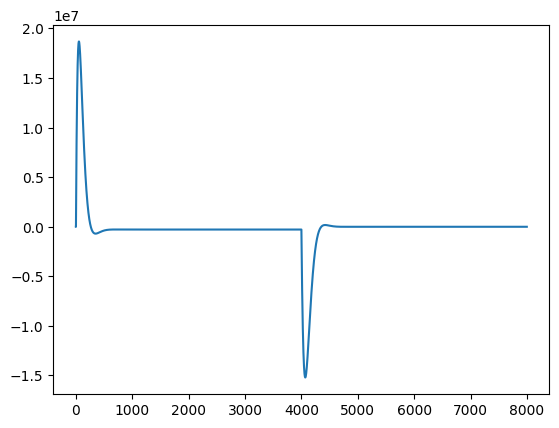

In [75]:
# compare to scipy convolve function
from scipy.signal import convolve
dfdt = result['df_dt']
Bt = result['B_t']

St = convolve(dfdt, Bt, mode='full')
plt.plot(St)
plt.show()

R_el: 219.4495086669922
gamma: 23.9326114654541
beta: 0.7497966289520264
w0: 15.948999404907227
alpha: 10.635550498962402
p: 7.5174102783203125
(R_el*pv): 768073.25
R_el: 87.84834289550781
gamma: 59.784847259521484
beta: 0.7497966289520264
w0: 39.84138870239258
alpha: 26.568130493164062
p: 18.77886199951172
(R_el*pv): 307469.19
R_el: 276.48907470703125
gamma: 18.995325088500977
beta: 0.7497966289520264
w0: 12.658727645874023
alpha: 8.44144058227539
p: 5.966571807861328
(R_el*pv): 967711.75
R_el: 110.68197631835938
gamma: 47.45126724243164
beta: 0.7497966289520264
w0: 31.62213134765625
alpha: 21.087139129638672
p: 14.904793739318848
(R_el*pv): 387386.91


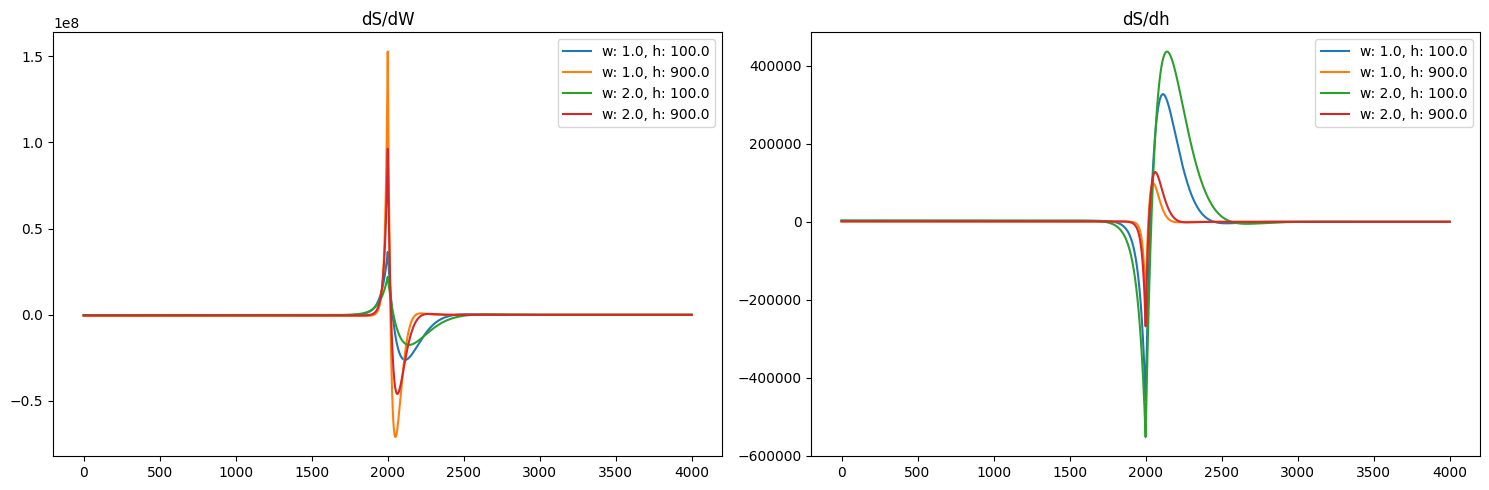

In [76]:
import itertools
ws = [1.0,  2.0]
hs = [100.0, 900.0]
wh_combinations = list(itertools.product(ws, hs))
out = [[],[],[],[]]
for w,h in wh_combinations:
    result = compute_partial_derivatives(w=w, h=h, device='cuda', plot=False)
    out[0].append(result['dS_dW_ana'])
    out[1].append(result['dS_dh_ana'])
    out[2].append(result['w'])
    out[3].append(result['h'])
    

# make a 2 column, 1 row subplot figure, where columns are dS/dW and dS/dh, and (W,h) combinations are different line colors
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=False)
for i in range(len(ws)*len(hs)):
    axs[0].plot(out[0][i], label=f'w: {out[2][i]}, h: {out[3][i]}')
    axs[1].plot(out[1][i], label=f'w: {out[2][i]}, h: {out[3][i]}')
axs[0].set_title('dS/dW')
axs[1].set_title('dS/dh')
axs[0].legend()
axs[1].legend()

plt.tight_layout()
# plt.show()
plt.savefig('dS_dW_dS_dh.png')


R_el: 185.3374786376953
gamma: 28.337495803833008
beta: 0.7497966289520264
w0: 18.884469985961914
alpha: 12.593061447143555
p: 8.901017189025879
(R_el*pv): 648681.19
R_el: 87.84834289550781
gamma: 59.784847259521484
beta: 0.7497966289520264
w0: 39.84138870239258
alpha: 26.568130493164062
p: 18.77886199951172
(R_el*pv): 307469.19
R_el: 233.51058959960938
gamma: 22.491485595703125
beta: 0.7497966289520264
w0: 14.98861312866211
alpha: 9.995119094848633
p: 7.064741611480713
(R_el*pv): 817287.06
R_el: 110.68197631835938
gamma: 47.45126724243164
beta: 0.7497966289520264
w0: 31.62213134765625
alpha: 21.087139129638672
p: 14.904793739318848
(R_el*pv): 387386.91


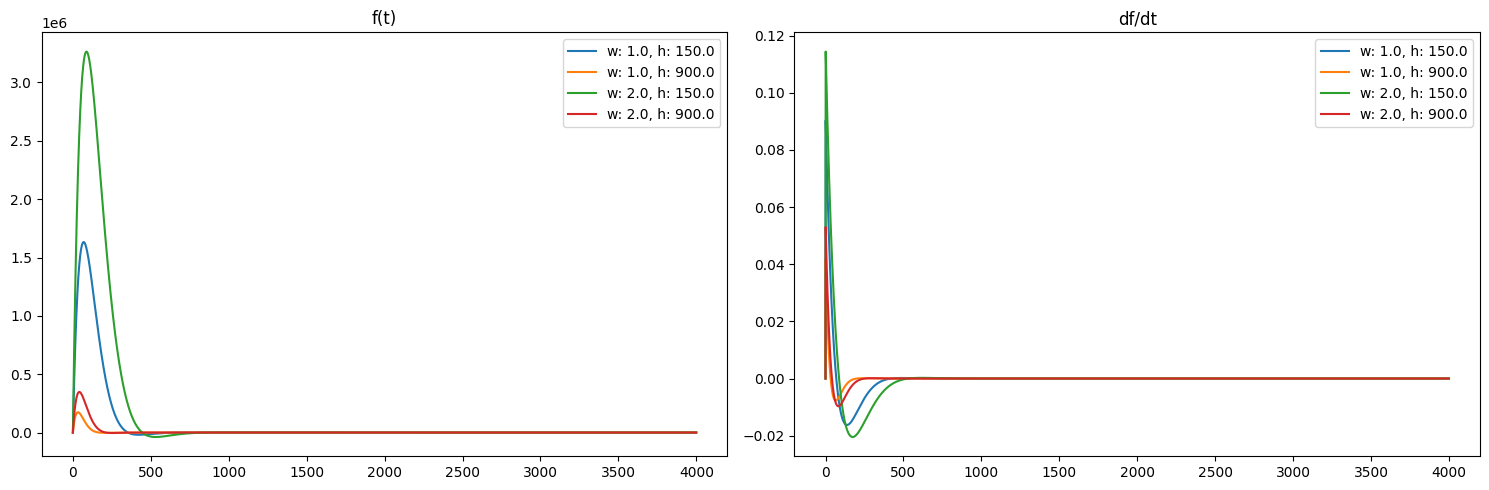

In [77]:

ws = [1.0,  2.0]
hs = [100.0, 900.0]
wh_combinations = list(itertools.product(ws, hs))
out = [[],[],[],[]]
for w,h in wh_combinations:
    result = compute_partial_derivatives(w=w, h=h, device='cuda', plot=False)
    out[0].append(result['f_t'])
    out[1].append(result['df_dt'])
    out[2].append(result['w'])
    out[3].append(result['h'])
    

# make a 2 column, 1 row subplot figure, where columns are dS/dW and dS/dh, and (W,h) combinations are different line colors
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=False)
for i in range(len(ws)*len(hs)):
    axs[0].plot(out[0][i], label=f'w: {out[2][i]}, h: {out[3][i]}')
    axs[1].plot(out[1][i], label=f'w: {out[2][i]}, h: {out[3][i]}')
axs[0].set_title('f(t)')
axs[1].set_title('df/dt')
axs[0].legend()
axs[1].legend()

plt.tight_layout()
# plt.show()
plt.savefig('f_t_df_dt.png')



R_el: 219.4495086669922
gamma: 23.9326114654541
beta: 0.7497966289520264
w0: 15.948999404907227
alpha: 10.635550498962402
p: 7.5174102783203125
(R_el*pv): 768073.25
R_el: 87.84834289550781
gamma: 59.784847259521484
beta: 0.7497966289520264
w0: 39.84138870239258
alpha: 26.568130493164062
p: 18.77886199951172
(R_el*pv): 307469.19
R_el: 276.48907470703125
gamma: 18.995325088500977
beta: 0.7497966289520264
w0: 12.658727645874023
alpha: 8.44144058227539
p: 5.966571807861328
(R_el*pv): 967711.75
R_el: 110.68197631835938
gamma: 47.45126724243164
beta: 0.7497966289520264
w0: 31.62213134765625
alpha: 21.087139129638672
p: 14.904793739318848
(R_el*pv): 387386.91


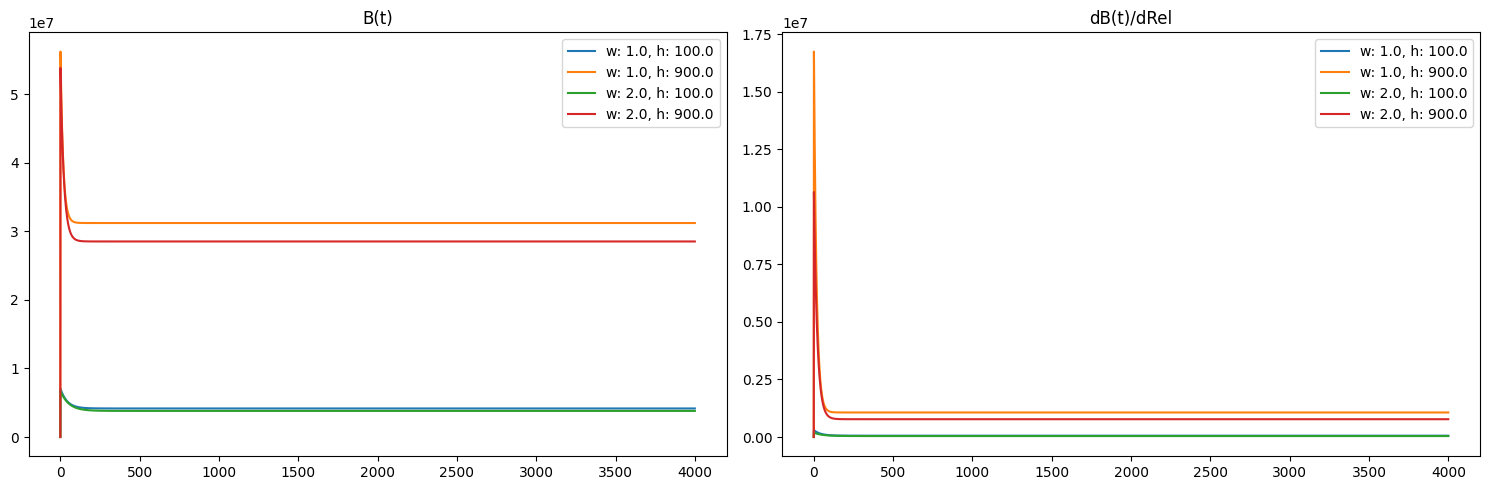

In [78]:

ws = [1.0,  2.0]
hs = [100.0, 900.0]
wh_combinations = list(itertools.product(ws, hs))
out = [[],[],[],[]]
for w,h in wh_combinations:
    result = compute_partial_derivatives(w=w, h=h, device='cuda', plot=False)
    out[0].append(result['B_t'])
    out[1].append(result['dB_t_dRel'])
    out[2].append(result['w'])
    out[3].append(result['h'])
    

# make a 2 column, 1 row subplot figure, where columns are dS/dW and dS/dh, and (W,h) combinations are different line colors
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=False)
for i in range(len(ws)*len(hs)):
    axs[0].plot(out[0][i], label=f'w: {out[2][i]}, h: {out[3][i]}')
    axs[1].plot(out[1][i], label=f'w: {out[2][i]}, h: {out[3][i]}')
axs[0].set_title('B(t)')
axs[1].set_title('dB(t)/dRel')
axs[0].legend()
axs[1].legend()

plt.tight_layout()
# plt.show()

plt.savefig('B_t_dB_t_dRel.png')


R_el: 219.4495086669922
gamma: 23.9326114654541
beta: 0.7497966289520264
w0: 15.948999404907227
alpha: 10.635550498962402
p: 7.5174102783203125
(R_el*pv): 768073.25
R_el: 87.84834289550781
gamma: 59.784847259521484
beta: 0.7497966289520264
w0: 39.84138870239258
alpha: 26.568130493164062
p: 18.77886199951172
(R_el*pv): 307469.19
R_el: 276.48907470703125
gamma: 18.995325088500977
beta: 0.7497966289520264
w0: 12.658727645874023
alpha: 8.44144058227539
p: 5.966571807861328
(R_el*pv): 967711.75
R_el: 110.68197631835938
gamma: 47.45126724243164
beta: 0.7497966289520264
w0: 31.62213134765625
alpha: 21.087139129638672
p: 14.904793739318848
(R_el*pv): 387386.91


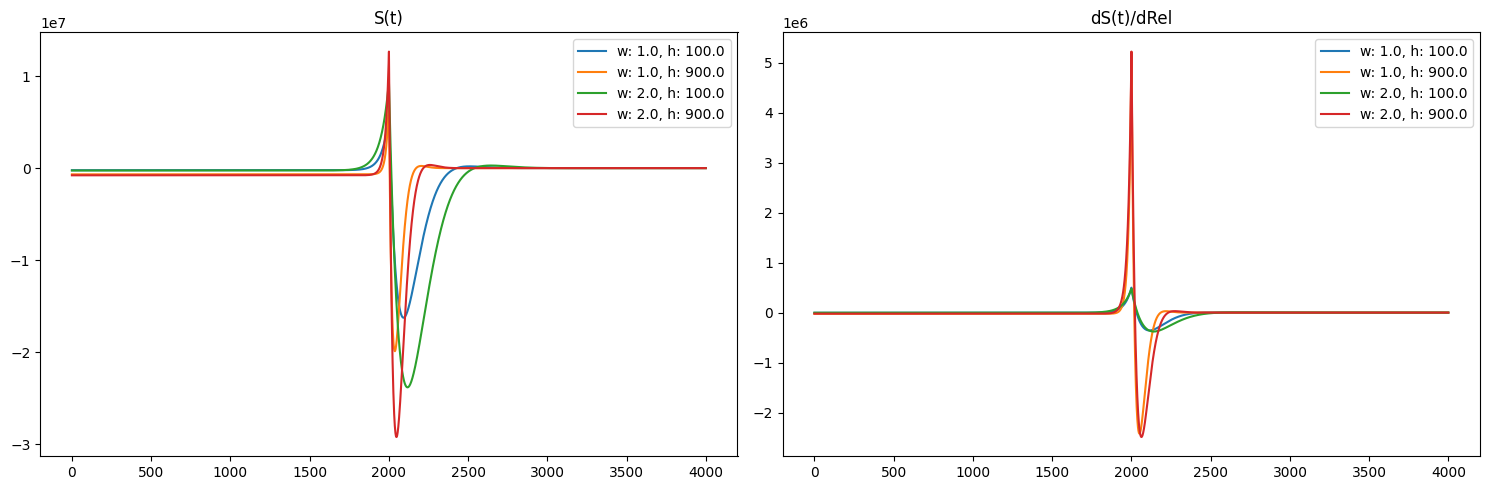

In [79]:

ws = [1.0,  2.0]
hs = [100.0, 900.0]
wh_combinations = list(itertools.product(ws, hs))
out = [[],[],[],[]]
for w,h in wh_combinations:
    result = compute_partial_derivatives(w=w, h=h, device='cuda', plot=False)
    out[0].append(result['S_t'])
    out[1].append(result['dS_t_dRel'])
    out[2].append(result['w'])
    out[3].append(result['h'])
    

# make a 2 column, 1 row subplot figure, where columns are dS/dW and dS/dh, and (W,h) combinations are different line colors
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=False)
for i in range(len(ws)*len(hs)):
    axs[0].plot(out[0][i], label=f'w: {out[2][i]}, h: {out[3][i]}')
    axs[1].plot(out[1][i], label=f'w: {out[2][i]}, h: {out[3][i]}')
axs[0].set_title('S(t)')
axs[1].set_title('dS(t)/dRel')
axs[0].legend()
axs[1].legend()

plt.tight_layout()
# plt.show()

plt.savefig('S_t_dS_t_dRel.png')


# Comparison with Fortran Simulated STF

In [86]:
import pandas as pd
import os


root = os.path.abspath('')
path = f'{root}/data'

filename = 'tdsf_002_train.pickle'
df_train_all = pd.read_pickle(path + '/' + filename)

filename = 'tdsf_002_val.pickle'
df_test_all = pd.read_pickle(path + '/' + filename)

df_data = pd.concat([df_train_all, df_test_all], axis=0)

name_prefix = '_FAR.'
name_material = 'Granite'

df_data = df_data[df_data['material'] == name_prefix + name_material]
df_data = df_data.reset_index(drop=True)

# round YIELD and DEPTH to 2 decimal places
df_data.YIELD = df_data.YIELD.round(2)
df_data.DEPTH = df_data.DEPTH.round(2)

df_data

delta    b     t4     t5  YIELD  DEPTH       user2       user3  \
0     0.001  0.0  0.105  0.144   0.71  620.0  694.979919  136.754105   
1     0.001  0.0  0.106  0.149   1.02  620.0  615.920959   121.19735   
2     0.001  0.0  0.106  0.152   1.98  840.0   668.94574   97.156403   
3     0.001  0.0  0.107  0.165   1.89  500.0  404.404572   98.674721   
4     0.001  0.0  0.108  0.169   1.88  440.0   356.50589   98.849365   
...     ...  ...    ...    ...    ...    ...         ...         ...   
9581  0.001  0.0  0.108  0.167  1.073  326.0  318.432709  119.168076   
9582  0.001  0.0  0.108  0.167  1.273  366.0  337.705627  112.568542   
9583  0.001  0.0  0.105   0.14  0.423  566.0  753.997009  162.522324   
9584  0.001  0.0  0.111  0.202  1.073  126.0  123.075226  119.168076   
9585  0.001  0.0   0.11   0.19  1.448  206.0  182.086487  107.837631   

         user4  user5  ... unused23   kuser0  \
0     6.017807  0.039  ...        0  Granite   
1     5.333239  0.043  ...        0  Granite   
2     4.852018  0.046  ...        0  Granite   
3     3.969887  0.058  ...        0  Granite   
4     3.770629  0.061  ...        0  Granite   
...        ...    ...  ...      ...      ...   
9581  4.011763  0.059  ...        0  Granite   
9582  3.976816  0.059  ...        0  Granite   
9583  6.885274  0.035  ...        0  Granite   
9584  2.699701  0.091  ...        0  Granite   
9585  2.998355   0.08  ...        0  Granite   

                                            sacfilepath      material  \
0     /raid/synthid/raw_data/TDSF_002/train/_FAR.Gra...  _FAR.Granite   
1     /raid/synthid/raw_data/TDSF_002/train/_FAR.Gra...  _FAR.Granite   
2     /raid/synthid/raw_data/TDSF_002/train/_FAR.Gra...  _FAR.Granite   
3     /raid/synthid/raw_data/TDSF_002/train/_FAR.Gra...  _FAR.Granite   
4     /raid/synthid/raw_data/TDSF_002/train/_FAR.Gra...  _FAR.Granite   
...                                                 ...           ...   
9581  /raid/synthid/raw_data/TDSF_002/val/_FAR.Grani...  _FAR.Granite   
9582  /raid/synthid/raw_data/TDSF_002/val/_FAR.Grani...  _FAR.Granite   
9583  /raid/synthid/raw_data/TDSF_002/val/_FAR.Grani...  _FAR.Granite   
9584  /raid/synthid/raw_data/TDSF_002/val/_FAR.Grani...  _FAR.Granite   
9585  /raid/synthid/raw_data/TDSF_002/val/_FAR.Grani...  _FAR.Granite   

                                                   DATA    x_mean     x_std  \
0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  0.000104  0.001168   
1     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  0.000126  0.001364   
2     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  0.000185  0.002024   
3     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  0.000173  0.001650   
4     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  0.000171  0.001573   
...                                                 ...       ...       ...   
9581  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  0.000123  0.001113   
9582  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  0.000136  0.001247   
9583  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  0.000078  0.000908   
9584  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  0.000114  0.000804   
9585  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  0.000139  0.001080   

                                              NORM_DATA NORM_YIELD NORM_DEPTH  
0     [-0.089018986, -0.089018986, -0.089018986, -0....      0.355   0.688889  
1     [-0.09263907, -0.09263907, -0.09263907, -0.092...       0.51   0.688889  
2     [-0.09140676, -0.09140676, -0.09140676, -0.091...       0.99   0.933333  
3     [-0.10481857, -0.10481857, -0.10481857, -0.104...      0.945   0.555556  
4     [-0.10843031, -0.10843031, -0.10843031, -0.108...       0.94   0.488889  
...                                                 ...        ...        ...  
9581  [-0.11062281, -0.11062281, -0.11062281, -0.110...   0.557982   0.404467  
9582  [-0.10929509, -0.10929509, -0.10929509, -0.109...   0.661986   0.454094  
9583  [-0.08600861

R_el: 219.4495086669922
gamma: 23.9326114654541
beta: 0.7497966289520264
w0: 15.948999404907227
alpha: 10.635550498962402
p: 7.5174102783203125
(R_el*pv): 768073.25


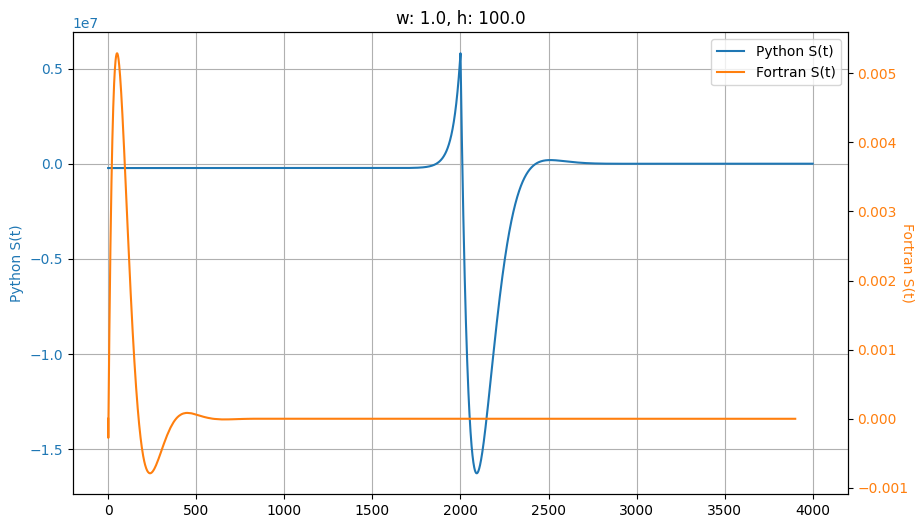

In [81]:
# plot numpy arrays with the DATA column from data_df where YIELD and DEPTH are iterated over from wh_combinations
ws = [1.0]
hs = [100.0]
wh_combinations = list(itertools.product(ws, hs))
out = [[],[],[],[],[],[]]

for w,h in wh_combinations:
    result = compute_partial_derivatives(w=w, h=h, device='cuda', plot=False)
    out[0].append(result['S_t'])
    out[2].append(result['w'])
    out[3].append(result['h'])

    # find the corresponding YIELD and DEPTH values from the dataframe
    idx = df_data[(df_data['YIELD'] == w) & (df_data['DEPTH'] == h)].index[0]
    out[1].append(df_data.loc[idx, 'DATA'])

    

# plot the S(t) and DATA values for each (W,h) combination
fig, axs = plt.subplots(1, len(wh_combinations), figsize=(10, 6), sharex=True, sharey=False)
plt.grid(True)
for i in range(len(wh_combinations)):
    axs.plot(out[0][i], label=f'Python S(t)', color='tab:blue')
    axs.tick_params(axis='y', labelcolor='tab:blue')
    axs.set_title(f'w: {out[2][i]}, h: {out[3][i]}')
    axs.set_ylabel('Python S(t)', color='tab:blue')
    # make a second axis for the DATA values
    ax2 = axs.twinx()
    ax2.plot(out[1][i][98:], label=f'Fortran S(t)', color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    ax2.set_ylabel('Fortran S(t)', color='tab:orange', rotation=270)
    
    
    
    

    # Combine legends
lines_1, labels_1 = axs.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
axs.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')
plt.savefig('S_t_comparison.png')

R_el: 219.4495086669922
gamma: 23.9326114654541
beta: 0.7497966289520264
w0: 15.948999404907227
alpha: 10.635550498962402
p: 7.5174102783203125
(R_el*pv): 768073.25


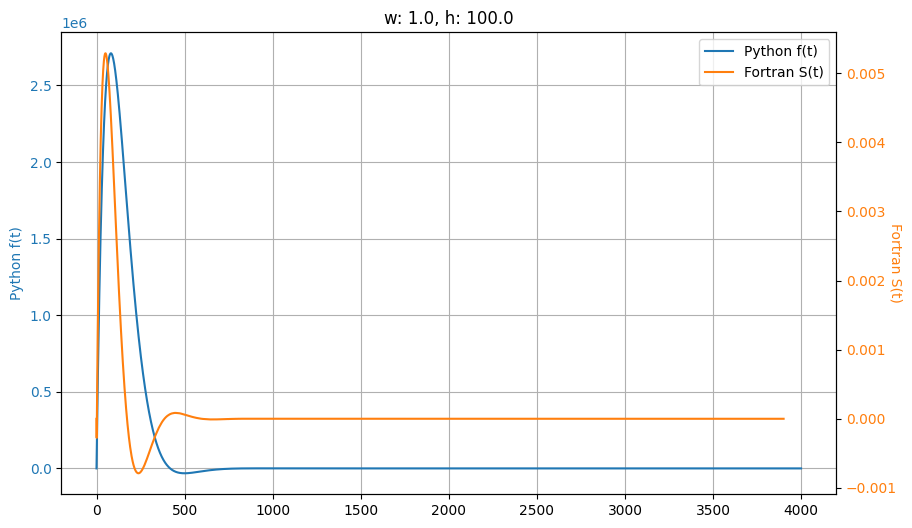

In [82]:
# plot numpy arrays with the DATA column from data_df where YIELD and DEPTH are iterated over from wh_combinations
ws = [1.0]
hs = [100.0]
wh_combinations = list(itertools.product(ws, hs))
out = [[],[],[],[],[],[]]

for w,h in wh_combinations:
    result = compute_partial_derivatives(w=w, h=h, device='cuda', plot=False)
    out[0].append(result['f_t'])
    out[2].append(result['w'])
    out[3].append(result['h'])

    # find the corresponding YIELD and DEPTH values from the dataframe
    idx = df_data[(df_data['YIELD'] == w) & (df_data['DEPTH'] == h)].index[0]
    out[1].append(df_data.loc[idx, 'DATA'])

    

# plot the S(t) and DATA values for each (W,h) combination
fig, axs = plt.subplots(1, len(wh_combinations), figsize=(10, 6), sharex=True, sharey=False)
plt.grid(True)
for i in range(len(wh_combinations)):
    axs.plot(out[0][i], label=f'Python f(t)', color='tab:blue')
    axs.tick_params(axis='y', labelcolor='tab:blue')
    axs.set_title(f'w: {out[2][i]}, h: {out[3][i]}')
    axs.set_ylabel('Python f(t)', color='tab:blue')
    # make a second axis for the DATA values
    ax2 = axs.twinx()
    ax2.plot(out[1][i][98:], label=f'Fortran S(t)', color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    ax2.set_ylabel('Fortran S(t)', color='tab:orange', rotation=270)
    
    
    
    

    # Combine legends
lines_1, labels_1 = axs.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
axs.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')
plt.savefig('S_t_vs_f_t_comparison.png')

R_el: 219.4495086669922
gamma: 23.9326114654541
beta: 0.7497966289520264
w0: 15.948999404907227
alpha: 10.635550498962402
p: 7.5174102783203125
(R_el*pv): 768073.25


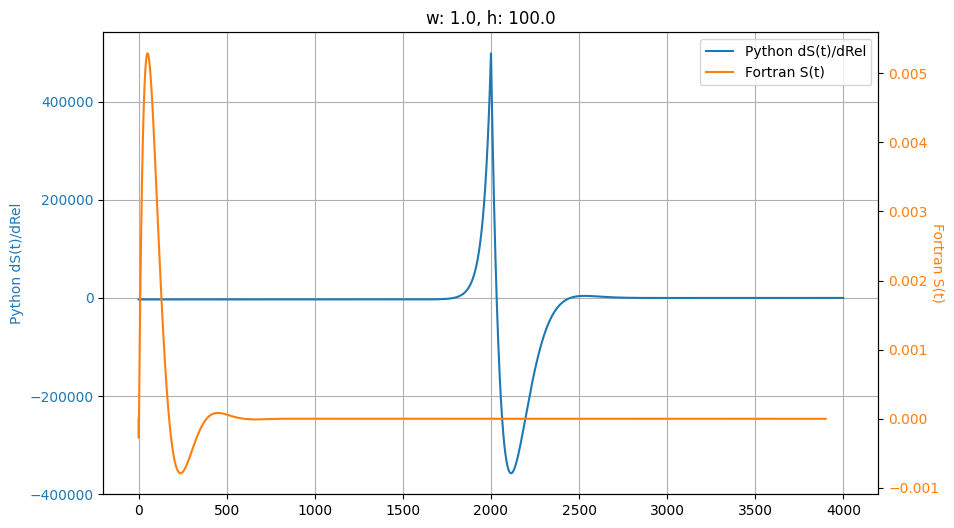

In [83]:
# plot numpy arrays with the DATA column from data_df where YIELD and DEPTH are iterated over from wh_combinations
ws = [1.0]
hs = [100.0]
wh_combinations = list(itertools.product(ws, hs))
out = [[],[],[],[],[],[]]

for w,h in wh_combinations:
    result = compute_partial_derivatives(w=w, h=h, device='cuda', plot=False)
    out[0].append(result['dS_t_dRel'])
    out[2].append(result['w'])
    out[3].append(result['h'])

    # find the corresponding YIELD and DEPTH values from the dataframe
    idx = df_data[(df_data['YIELD'] == w) & (df_data['DEPTH'] == h)].index[0]
    out[1].append(df_data.loc[idx, 'DATA'])

    

# plot the S(t) and DATA values for each (W,h) combination
fig, axs = plt.subplots(1, len(wh_combinations), figsize=(10, 6), sharex=True, sharey=False)
plt.grid(True)
for i in range(len(wh_combinations)):
    axs.plot(out[0][i], label=f'Python dS(t)/dRel', color='tab:blue')
    axs.tick_params(axis='y', labelcolor='tab:blue')
    axs.set_title(f'w: {out[2][i]}, h: {out[3][i]}')
    axs.set_ylabel('Python dS(t)/dRel', color='tab:blue')
    # make a second axis for the DATA values
    ax2 = axs.twinx()
    ax2.plot(out[1][i][98:], label=f'Fortran S(t)', color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    ax2.set_ylabel('Fortran S(t)', color='tab:orange', rotation=270)
    
    
    
    

    # Combine legends
lines_1, labels_1 = axs.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
axs.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')
plt.savefig('S_t_vs_dSdRel_comparison.png')

# STF PINN - Pytorch

In [1]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
device='cpu'


# Define the dictionary with constants for each material
constants_dict = {
    "Tuff/Rhyolite": {
        "h0": 122.0, "R0": 202.0, "gamma0": 26.0, "P10": 3.6E6, "P20": 5.0E6, "pv": 3500.0, "sv": 2021.0, "n": 2.4, "rho": 2000.0
    },
    "Granite": {
        "h0": 122.0, "R0": 321.0, "gamma0": 34.0, "P10": 4.6E6, "P20": 2.4E6, "pv": 5500.0, "sv": 3175.0, "n": 2.4, "rho": 2550.0
    },
    "Salt": {
        "h0": 122.0, "R0": 478.0, "gamma0": 31.0, "P10": 5.5E6, "P20": 0.8E6, "pv": 4670.0, "sv": 2696.0, "n": 1.87, "rho": 2200.0
    },
    "Shale": {
        "h0": 122.0, "R0": 265.0, "gamma0": 42.0, "P10": 4.2E6, "P20": 2.5E6, "pv": 4320.0, "sv": 2495.0, "n": 2.4, "rho": 2350.0
    },
    "Wet Tuff": {
        "h0": 122.0, "R0": 202.0, "gamma0": 26.0, "P10": 3.6E6, "P20": 5.0E6, "pv": 2400.0, "sv": 1300.0, "n": 2.4, "rho": 1915.0
    },
    "Wet Granite": {
        "h0": 122.0, "R0": 321.0, "gamma0": 34.0, "P10": 4.6E6, "P20": 2.4E6, "pv": 5350.0, "sv": 2795.0, "n": 2.4, "rho": 2650.0
    }
}


material = 'Granite'

# Function to populate variables from the dictionary based on material name
def get_constants(material_name, device):
    if material_name in constants_dict:
        material_constants = constants_dict[material_name]
        h0 = torch.tensor(material_constants["h0"], requires_grad=False, device=device)
        R0 = torch.tensor(material_constants["R0"], requires_grad=False, device=device)
        gamma0 = torch.tensor(material_constants["gamma0"], requires_grad=False, device=device)
        P10 = torch.tensor(material_constants["P10"], requires_grad=False, device=device)
        P20 = torch.tensor(material_constants["P20"], requires_grad=False, device=device)
        pv = torch.tensor(material_constants["pv"], requires_grad=False, device=device)
        sv = torch.tensor(material_constants["sv"], requires_grad=False, device=device)
        n = torch.tensor(material_constants["n"], requires_grad=False, device=device)
        rho = torch.tensor(material_constants["rho"], requires_grad=False, device=device)
        return h0, R0, gamma0, P10, P20, pv, sv, n, rho
    else:
        raise ValueError(f"Material '{material_name}' not found in the constants dictionary.")

h0, R0, gamma0, P10, P20, pv, sv, n, rho = get_constants(material, device)

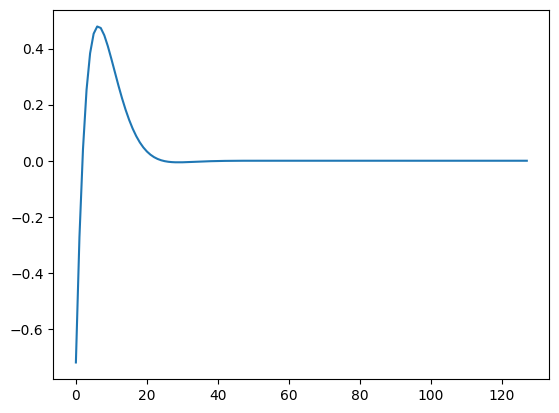

In [2]:

def stf(t,w,h): 

    b = 1

    mu = rho*(sv**2)
    lam = rho*(pv**2)-2*mu  

    def Heaviside(t):
        return torch.where(t >= 0, torch.tensor(1.0), torch.tensor(0.0))

    # Define H(t), Heaviside step function
    H_t = Heaviside(t)

    # Compute R_el based on equation (7) and (8)
    R_el = R0 * (h0 / h).pow(1/n) * w.pow(1/3)

    # Compute gamma based on equation in the screenshot
    gamma = gamma0 * (R0 / R_el)

    # Compute beta based on the given equation
    beta = (lam + 2 * mu) / (4 * mu)

    # Compute w0 based on the given equation
    w0 = pv / R_el

    # Compute alpha and p based on the given equations
    alpha = w0 / (2 * beta)

    p = w0 * torch.sqrt(1 / (2 * beta) - 1 / (4 * beta**2))

    # Define f(t) based on equation (3)
    def f_t(R_el, t):
        return (R_el / (4 * alpha)) * (pv**2 / (beta * p)) * H_t * torch.exp(-alpha * t) * torch.sin(p * t)

    def df_t_dt(R_el, mu, pv, beta, p, alpha, t):
        A = (R_el / (4 * mu)) * (pv**2 / (beta * p))
        return A * H_t * torch.exp(-alpha * t) * (-alpha * torch.sin(p * t) + p * torch.cos(p * t))

    # Define B(t) based on equation (2)
    def B_t(R_el, t):
        P0_t = P10 * (h / h0)  # P1 - P2 with P1 and P2
        P2_t = P20 * (h0 / h).pow(1/3) * (R0 / R_el).pow(3) * w.pow(0.87)
        return (torch.exp(-gamma * t) * P0_t + P2_t) * H_t


    def dB_t_dRel():
        term1 = -torch.exp(-gamma * t) * P10 * (h / h0) * (t * gamma / R_el - n / R_el * (h / h0).pow(1/n)) * (h * w.pow(-1/3)).pow(1/3)
        term2 = P20 * w.pow(0.87) * ((t * torch.exp(-gamma * t) * R0.pow(3)) / R_el.pow(4) * (h0 / h).pow(1/3) - (t * torch.exp(-gamma * t) * R0.pow(3)) / R_el.pow(4) * (h0 / h).pow(1/3))
        term3 = (1 - torch.exp(-gamma * t)) * (1 / 3 * n * R0.pow(2) / R_el.pow(3) * (h0 / h).pow(1/3) * w.pow(-2/3) * (h * w.pow(-1/3)).pow(1/3))
        term4 = (1 - torch.exp(-gamma * t)) * (-3 * R0.pow(3) / R_el.pow(4) * (h0 / h).pow(1/3) * (h * w.pow(-1/3)).pow(1/3))
        return (term1 + term2 + term3 + term4) * H_t


    def dRel_dw(R0, h0, h, n, w):
        return R0 * (h0 / h).pow(1/n) * (1 / 3) * w.pow(-2/3)

    def dRel_dh(R0, h0, h, n, w):
        return -R0 * (1 / n) * (h0 / h).pow(1/n) * (1 / h) * w.pow(1/3)

    # Compute the time derivative of f(t)
    f_t_val = f_t(R_el, t)
    df_dt = df_t_dt(R_el, mu, pv, beta, p, alpha, t)


    # Reshape for conv1d: [batch_size, channels, sequence_length]
    df_dt_reshaped = df_dt.view(b, 1, -1)

    B_t_val = B_t(R_el, t)
    B_t_reshaped = B_t_val.view(b, 1, -1)

    S_t = F.conv1d(-df_dt_reshaped/(R_el*pv), B_t_reshaped, padding=B_t_reshaped.size(-1)-1) # full convolution padding
    S_t = S_t.view(-1)[t.size(0)-1:]  # Ensure S_t has the same length as t

    dB_t_dRel_val = dB_t_dRel()
    dB_t_dRel_reshaped = dB_t_dRel_val.view(b, 1, -1)

    # Perform convolution using conv1d
    dS_t_dRel = F.conv1d(-df_dt_reshaped/(R_el*pv), dB_t_dRel_reshaped, padding=dB_t_dRel_reshaped.size(-1)-1) # full convolution padding
    dS_t_dRel = dS_t_dRel.view(-1)[t.size(0)-1:]  # Ensure S_t has the same length as t


    dS_dW_ana = dS_t_dRel * dRel_dw(R0, h0, h, n, w)
    dS_dh_ana = dS_t_dRel * dRel_dh(R0, h0, h, n, w)

    # Compute dS(t)/dW and dS(t)/dh using autograd
    # dS_dW_num = torch.autograd.grad(S_t.sum(), w, create_graph=True)[0]
    # dS_dh_num = torch.autograd.grad(S_t.sum(), h, create_graph=True)[0]

    return S_t, dS_dW_ana.sum(), dS_dh_ana.sum()
batch_size = 1
# Define h, w, t as tensors with requires_grad=True to compute derivatives
h,w = Variable(torch.tensor(150.0, device=device), requires_grad=True), Variable(torch.tensor(1.0, device=device), requires_grad=True)
t = torch.linspace(0, 2.0, steps=128, requires_grad=True, device=device)
S_t, dS_dW_ana, dS_dh_ana = stf(t,w,h)
plt.plot(S_t.detach().cpu().numpy())

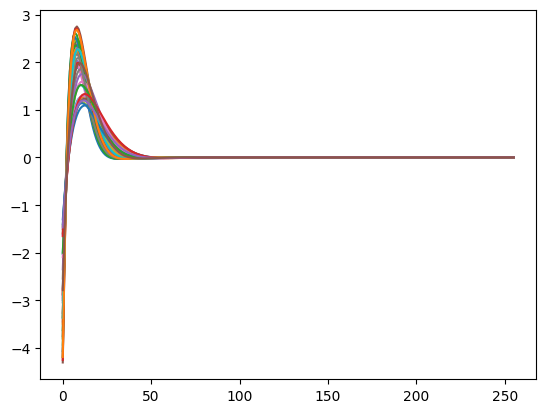

In [3]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np

h0, R0, gamma0, P10, P20, pv, sv, n, rho = get_constants(material, device)

def stf_batch(t,w,h): 

    mu = rho*(sv**2)
    lam = rho*(pv**2)-2*mu  

    def Heaviside(t):
        return torch.where(t >= 0, torch.tensor(1.0), torch.tensor(0.0))

    # Define H(t), Heaviside step function
    H_t = Heaviside(t)

    # Compute R_el based on equation (7) and (8)
    R_el = R0 * (h0 / h).pow(1/n) * w.pow(1/3)

    # Compute gamma based on equation in the screenshot
    gamma = gamma0 * (R0 / R_el)

    # Compute beta based on the given equation
    beta = (lam + 2 * mu) / (4 * mu)

    # Compute w0 based on the given equation
    w0 = pv / R_el

    # Compute alpha and p based on the given equations
    alpha = w0 / (2 * beta)

    p = w0 * torch.sqrt(1 / (2 * beta) - 1 / (4 * beta**2))

    # Define f(t) based on equation (3)
    def f_t(R_el, t):
        return (R_el / (4 * alpha)) * (pv**2 / (beta * p)) * H_t * torch.exp(-alpha * t) * torch.sin(p * t)

    def df_t_dt(R_el, mu, pv, beta, p, alpha, t):
        A = (R_el / (4 * mu)) * (pv**2 / (beta * p))
        return A * H_t * torch.exp(-alpha * t) * (-alpha * torch.sin(p * t) + p * torch.cos(p * t))

    # Define B(t) based on equation (2)
    def B_t(R_el, t):
        P0_t = P10 * (h / h0)  # P1 - P2 with P1 and P2
        P2_t = P20 * (h0 / h).pow(1/3) * (R0 / R_el).pow(3) * w.pow(0.87)
        return (torch.exp(-gamma * t) * P0_t + P2_t) * H_t


    def dB_t_dRel():
        term1 = -torch.exp(-gamma * t) * P10 * (h / h0) * (t * gamma / R_el - n / R_el * (h / h0).pow(1/n)) * (h * w.pow(-1/3)).pow(1/3)
        term2 = P20 * w.pow(0.87) * ((t * torch.exp(-gamma * t) * R0.pow(3)) / R_el.pow(4) * (h0 / h).pow(1/3) - (t * torch.exp(-gamma * t) * R0.pow(3)) / R_el.pow(4) * (h0 / h).pow(1/3))
        term3 = (1 - torch.exp(-gamma * t)) * (1 / 3 * n * R0.pow(2) / R_el.pow(3) * (h0 / h).pow(1/3) * w.pow(-2/3) * (h * w.pow(-1/3)).pow(1/3))
        term4 = (1 - torch.exp(-gamma * t)) * (-3 * R0.pow(3) / R_el.pow(4) * (h0 / h).pow(1/3) * (h * w.pow(-1/3)).pow(1/3))
        return (term1 + term2 + term3 + term4) * H_t


    def dRel_dw(R0, h0, h, n, w):
        return R0 * (h0 / h).pow(1/n) * (1 / 3) * w.pow(-2/3)

    def dRel_dh(R0, h0, h, n, w):
        return -R0 * (1 / n) * (h0 / h).pow(1/n) * (1 / h) * w.pow(1/3)

    # Compute the time derivative of f(t)
    f_t_val = f_t(R_el, t)
    df_dt = df_t_dt(R_el, mu, pv, beta, p, alpha, t)


    # Reshape for conv1d: [batch_size, channels, sequence_length]
    df_dt_reshaped = df_dt.view(1, b, -1)

    B_t_val = B_t(R_el, t)
    B_t_reshaped = B_t_val.view(b, 1, -1)

    S_t = F.conv1d(-df_dt_reshaped/(R_el*pv), B_t_reshaped, 
                   padding=B_t_reshaped.size(-1)-1, groups=b) # full convolution padding
    S_t = S_t.view(b, -1)[:, t.size(-1)-1:]  # Ensure S_t has the same length as t

    dB_t_dRel_val = dB_t_dRel()
    dB_t_dRel_reshaped = dB_t_dRel_val.view(b, 1, -1)

    # Perform convolution using conv1d
    dS_t_dRel = F.conv1d(-df_dt_reshaped/(R_el*pv), dB_t_dRel_reshaped, 
                         padding=B_t_reshaped.size(-1)-1, groups=b) # full convolution padding
    dS_t_dRel = dS_t_dRel.view(b,-1)[:, t.size(-1)-1:]  # Ensure S_t has the same length as t


    dS_dW_ana = dS_t_dRel * dRel_dw(R0, h0, h, n, w)
    dS_dh_ana = dS_t_dRel * dRel_dh(R0, h0, h, n, w)

    # Compute dS(t)/dW and dS(t)/dh using autograd
    # dS_dW_num = torch.autograd.grad(S_t.sum(), w, create_graph=True)[0]
    # dS_dh_num = torch.autograd.grad(S_t.sum(), h, create_graph=True)[0]

    return S_t, dS_dW_ana, dS_dh_ana

b = 36
# Define h, w, t as tensors with requires_grad=True to compute derivatives
h = Variable(torch.tensor(np.random.uniform(150., 900., b), device=device), requires_grad=True).view(b,-1)
w = Variable(torch.tensor(np.random.uniform(1., 2., b), device=device), requires_grad=True).view(b,-1)
t = torch.linspace(0, 2.0, steps=256, requires_grad=True, device=device).repeat(b).view(b,-1)
S_t, dS_dW_ana, dS_dh_ana = stf_batch(t,w,h)

for i in range(b):
    plt.plot(S_t[i].detach().cpu().numpy())
plt.show()



/home/mitch/miniconda3/envs/phd/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


torch.Size([512, 96, 3]) torch.Size([512, 96]) torch.Size([512, 96]) torch.Size([512, 96]) torch.Size([512, 96])
Iteration: 0, Loss: 125.550, Loss_d: 125.550, Loss_sw: 39.780, Loss_sh: 130.012
Iteration: 1, Loss: 98505.844, Loss_d: 98505.844, Loss_sw: 25.611, Loss_sh: 126.552
Iteration: 2, Loss: 1516.404, Loss_d: 1516.404, Loss_sw: 21.453, Loss_sh: 96.728
Iteration: 3, Loss: 15548.659, Loss_d: 15548.659, Loss_sw: 49.936, Loss_sh: 96.115
Iteration: 4, Loss: 2307.071, Loss_d: 2307.071, Loss_sw: 4.440, Loss_sh: 16.139
Iteration: 5, Loss: 934.332, Loss_d: 934.332, Loss_sw: 21.407, Loss_sh: 24.363
Iteration: 6, Loss: 1449.124, Loss_d: 1449.124, Loss_sw: 299.225, Loss_sh: 137.959
Iteration: 7, Loss: 305.381, Loss_d: 305.381, Loss_sw: 23.059, Loss_sh: 101.425
Iteration: 8, Loss: 689.784, Loss_d: 689.784, Loss_sw: 25.016, Loss_sh: 183.081
Iteration: 9, Loss: 64.983, Loss_d: 64.983, Loss_sw: 14.982, Loss_sh: 41.242
Iteration: 10, Loss: 629.894, Loss_d: 629.894, Loss_sw: 10.789, Loss_sh: 58.666


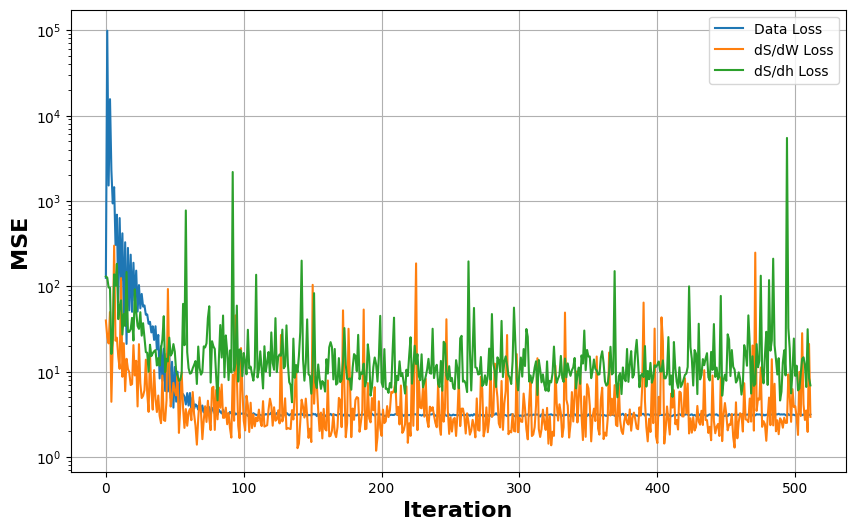

In [4]:
import torch.nn as nn
import torch.optim as optim
from kanunet import KANU_Net

device = 'cuda'


# Define the seeds
base_seed = 42  # You can choose any seed value
torch.manual_seed(base_seed)
np.random.seed(base_seed)


# Define the Neural Network class
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons, act, regularization_param, regularization_exp, retrain_seed):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Output activation function
        self.output_activation = torch.nn.Identity()
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation = act
        self.regularization_param = regularization_param
        # Regularization exponent
        self.regularization_exp = regularization_exp
        # Random seed for weight initialization

        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers - 1)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)
        self.retrain_seed = retrain_seed
        # Random Seed for weight initialization
        self.init_xavier()

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_activation(self.output_layer(x))

    def init_xavier(self):
        torch.manual_seed(self.retrain_seed)

        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                # torch.nn.init.xavier_normal_(m.weight, gain=g)
                m.bias.data.fill_(0)

        self.apply(init_weights)

    def regularization(self):
        reg_loss = 0
        for name, param in self.named_parameters():
            if 'weight' in name:
                reg_loss = reg_loss + torch.norm(param, self.regularization_exp)
        return self.regularization_param * reg_loss

from layers import KANLinear

class KAN(nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=10,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.ReLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

class Stan(nn.Module):
    """
    Self-scalable Tanh (Stan)
    References: Gnanasambandam, Raghav and Shen, Bo and Chung, Jihoon and Yue, Xubo and others.
    Self-scalable Tanh (Stan): Faster Convergence and Better Generalization
    in Physics-informed Neural Networks. arXiv preprint arXiv:2204.12589, 2022.
    """

    def __init__(self, out_features=1):
        super().__init__()
        self.beta = nn.Parameter(torch.ones(out_features))

    def forward(self, x):
        if x.shape[-1] != self.beta.shape[-1]:
            raise ValueError(
                f"The last dimension of the input must be equal to the dimension of Stan parameters. Got inputs: {x.shape}, params: {self.beta.shape}"
            )
        return torch.tanh(x) * (1.0 + self.beta * x)
# Setup model and optimizer.
model = NeuralNet(input_dimension=3, 
                  output_dimension=1, 
                  n_hidden_layers=6, 
                  neurons=256,
                  act = Stan(out_features=256), # torch.nn.Tanh(), torch.nn.ReLU(), torch.nn.GELU()
                  regularization_param=0.5, 
                  regularization_exp=2,
                  retrain_seed=128).to(device)

# model = KAN([1, 64, 32, 16, 8, 16, 32, 64, 1]).to(device)
# model = KANU_Net(1, 1, 'mps').to(device)
# Training params
lr = 1.E-3

# Select Optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=30, threshold=1E-3, 
                                                 threshold_mode='rel', cooldown=0, min_lr=1E-8, eps=1E-8, verbose=True)

material = 'Salt' # Granite, Salt, Shale, Wet Tuff, Wet Granite

b = 512
nt = 96
tmax = .5
tmin = 0.0
n_iter = 512
model.train()
losses = [[],[],[],[]]

h0, R0, gamma0, P10, P20, pv, sv, n, rho = get_constants(material, device)

hmin = 150.
hmax = 900.
wmin = 1.
wmax = 2.

lam_w = 1E-6
lam_h = 1E-5
lam_p = 1E-3

# Define h, w, t as tensors with requires_grad=True to compute derivatives
h = Variable(torch.tensor(np.random.uniform(hmin, hmax, b).astype(np.float32), device=device), requires_grad=True).view(b,-1)
w = Variable(torch.tensor(np.random.uniform(wmin, wmax, b).astype(np.float32), device=device), requires_grad=True).view(b,-1)
t = torch.linspace(tmin, tmax, steps=nt, requires_grad=True, device=device).repeat(b).view(b,-1)

S_t, dS_dW, dS_dh = stf_batch(t,w,h)

hnorm = (h/hmax).squeeze().repeat(nt).view(b,-1)
wnorm = (w/wmax).squeeze().repeat(nt).view(b,-1)
tnorm = t/tmax

# x = (tnorm*wnorm*hnorm).view(b,-1,1)
x = torch.stack((tnorm,wnorm,hnorm)).view(b,-1,3)

smax, smin = S_t.max(axis=-1, keepdim=True).values, S_t.min(axis=-1, keepdim=True).values
# xmax, xmin = x.max(axis=1, keepdim=True).values, x.min(axis=1, keepdim=True).values
xmax, xmin = x.max(), x.min()

s = model(((x - xmin)/(xmax - xmin)))
s = s.squeeze()*(smax - smin) + smin


print(x.shape, s.shape, S_t.shape, dS_dW.shape, dS_dh.shape)

# for i in range(b):
#     plt.plot(S_t[i].detach().cpu().numpy())
# plt.show()

def zero_one_normalize(x, seq_axis=1):
    """
    normalizes a batch of time-series data to the range [0, 1]
    x: torch.Tensor of shape (batch_size, sequence_length, 1)
    """
    xmax = x.max(axis=seq_axis, keepdim=True).values
    xmin = x.min(axis=seq_axis, keepdim=True).values

    return (x - xmin)/(xmax - xmin)


def find_peak_timesteps(data):
    """
    Find the timesteps at which each curve in the batch peaks.
    
    Args:
        data (torch.Tensor): Tensor of shape (batch_size, seq_length)
        
    Returns:
        torch.Tensor: Tensor of shape (batch_size,) containing the peak timesteps for each curve.
    """
    peak_timesteps = torch.argmax(data, dim=1)
    return peak_timesteps.float()


lrs = []
for i in range(n_iter):


    # Set the seed for the current iteration
    current_seed = base_seed + i
    torch.manual_seed(current_seed)
    np.random.seed(current_seed)
    
    optimizer.zero_grad()
    loss = torch.tensor(0.0, device=device)
    # Define h, w, t as tensors with requires_grad=True to compute derivatives
    h = Variable(torch.tensor(np.random.uniform(hmin, hmax, b).astype(np.float32), device=device), requires_grad=True).view(b,-1)
    w = Variable(torch.tensor(np.random.uniform(wmin, wmax, b).astype(np.float32), device=device), requires_grad=True).view(b,-1)
    t = torch.linspace(tmin, tmax, steps=nt, requires_grad=True, device=device).repeat(b).view(b,-1)

    S_t, dS_dW, dS_dh = stf_batch(t,w,h)

    hnorm = (h/hmax).squeeze().repeat(nt,1).T.view(b,-1)
    wnorm = (w/wmax).squeeze().repeat(nt,1).T.view(b,-1)
    tnorm = t/tmax

    # x = (tnorm*wnorm*hnorm).view(b,-1,1)
    x = torch.stack((tnorm,wnorm,hnorm)).view(b,-1,3)
    
    smax, smin = S_t.max(axis=-1, keepdim=True).values, S_t.min(axis=-1, keepdim=True).values
    xmax, xmin = x.max(axis=1, keepdim=True).values, x.min(axis=1, keepdim=True).values

    s = model(((x - xmin)/(xmax - xmin)))
    s = s.squeeze()*(smax - smin) + smin
    # s = model(((x - xmin)/(xmax - xmin)).mT) # if KANU_Net is used
    # s = s.mT.squeeze()*(smax - smin) + smin # if KANU_Net is used

    loss_d = torch.mean((s.squeeze() - S_t )**2)

    # # boundary loss
    l_t0 = s[:,0] - S_t[:,0]
    l_tL = s[:,-1] - S_t[:,-1]
    loss_b = torch.mean(l_t0**2) + torch.mean(l_tL**2)
    
    # peak loss
    l_tp = (find_peak_timesteps(s) - find_peak_timesteps(S_t))/nt
    loss_p = lam_p*torch.mean(l_tp**2)

    s_w = torch.autograd.grad(s.sum(), wnorm, create_graph=True)[0]
    s_h = torch.autograd.grad(s.sum(), hnorm, create_graph=True)[0]

    loss_sw = lam_w*torch.mean((s_w - dS_dW)**2)
    loss_sh = lam_h*torch.mean((s_h - dS_dh)**2)

    # loss_sw = lam_w*torch.mean(s_w**2)
    # loss_sh = lam_h*torch.mean(s_h**2)


    loss += loss_d
    # loss += loss_b
    # loss += loss_p
    # loss += loss_sw
    # loss += loss_sh

    losses[0].append(loss_d.item())
    losses[1].append(loss_sw.item())
    losses[2].append(loss_sh.item())

    # lrs.append(scheduler._last_lr)
    
    loss.backward()
    optimizer.step()
    scheduler.step(loss)
    
    print(f'Iteration: {i}, Loss: {loss.item():.3f}, Loss_d: {loss_d.item():.3f}, Loss_sw: {loss_sw.item():.3f}, Loss_sh: {loss_sh.item():.3f}')

# plot losses
fig = plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(losses[0], label='Data Loss')
plt.plot(losses[1], label='dS/dW Loss')
plt.plot(losses[2], label='dS/dh Loss')
plt.yscale('log')
plt.xlabel('Iteration', fontsize=16, fontweight='bold')
plt.ylabel('MSE', fontsize=16, fontweight='bold')
plt.legend()
plt.show()



# # plot learning rate schedule
# plt.figure(figsize=(10, 6))
# plt.grid(True)
# plt.yscale('log')
# plt.plot(lrs)
# plt.xlabel('Epoch', fontsize=16, fontweight='bold')
# plt.ylabel('Learning Rate', fontsize=16, fontweight='bold')







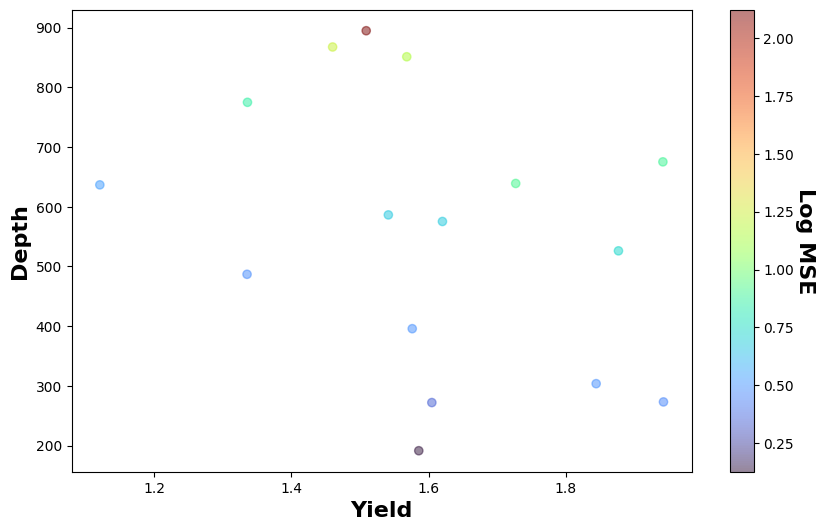

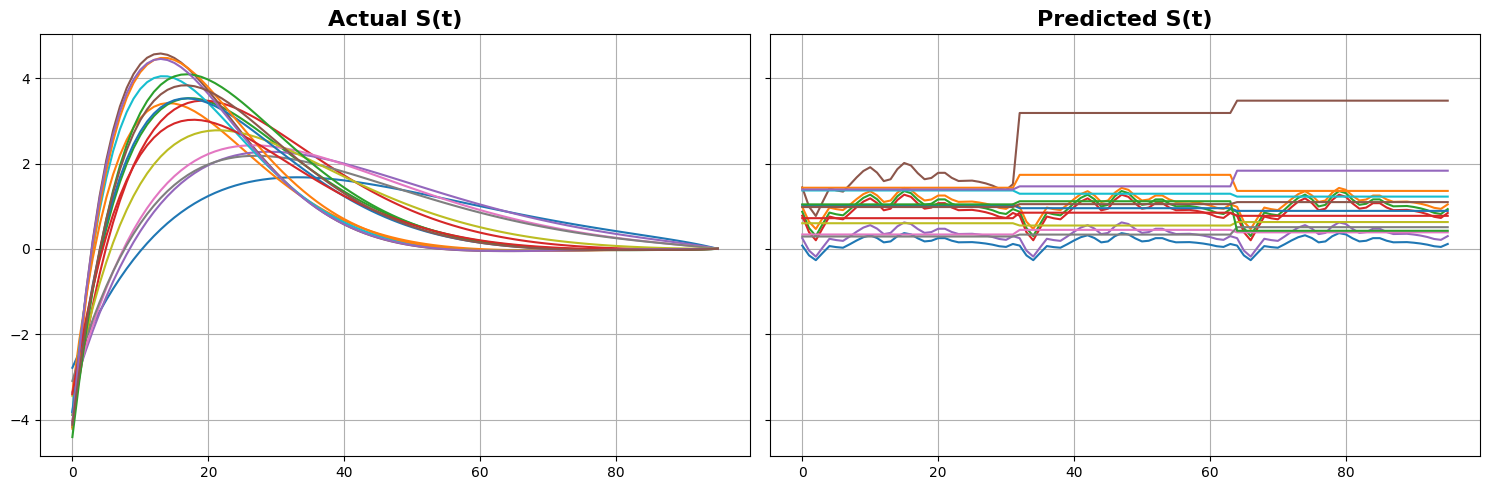

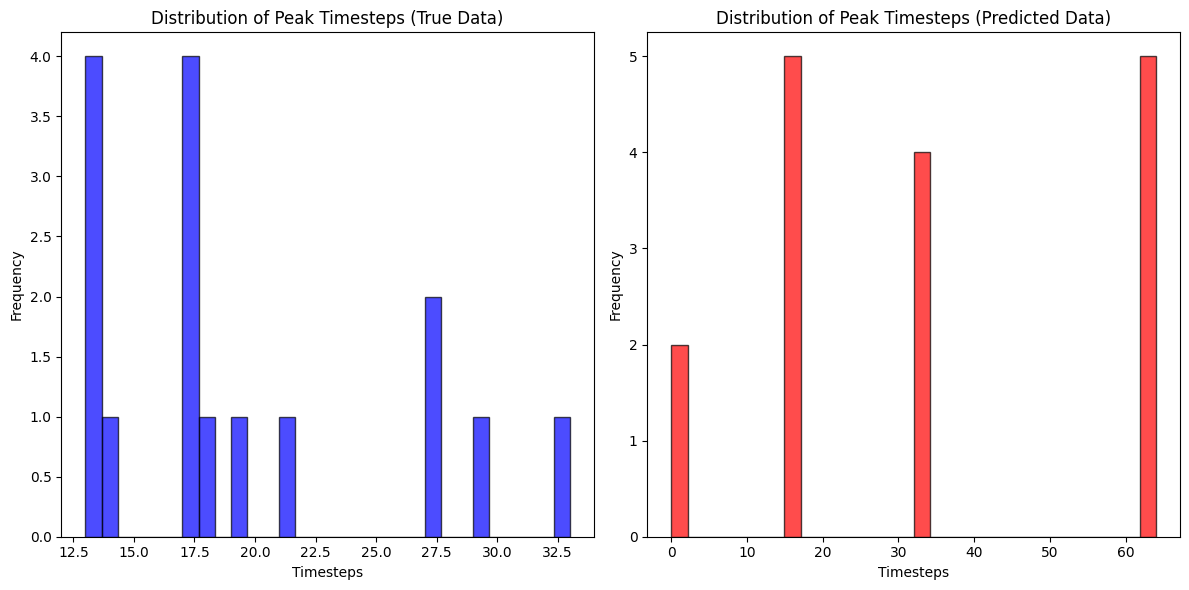

In [9]:
# Evaluate the model
b = 16
h0, R0, gamma0, P10, P20, pv, sv, n, rho = get_constants(material, device)
# Define h, w, t as tensors with requires_grad=True to compute derivatives
h = Variable(torch.tensor(np.random.uniform(hmin, hmax, b).astype(np.float32), device=device), requires_grad=True).view(b,-1)
w = Variable(torch.tensor(np.random.uniform(wmin, wmax, b).astype(np.float32), device=device), requires_grad=True).view(b,-1)
t = torch.linspace(tmin, tmax, steps=nt, requires_grad=True, device=device).repeat(b).view(b,-1)
S_t, dS_dW_ana, dS_dh_ana = stf_batch(t,w,h)

hnorm = (h/hmax).squeeze().repeat(nt,1).T.view(b,-1)
wnorm = (w/wmax).squeeze().repeat(nt,1).T.view(b,-1)
tnorm = t/tmax

# x = (tnorm*wnorm*hnorm).view(b,-1,1)
x = torch.stack((tnorm,wnorm,hnorm)).view(b,-1,3)
xmax, xmin = x.max(axis=1, keepdim=True).values, x.min(axis=1, keepdim=True).values
smax, smin = S_t.max(axis=-1, keepdim=True).values, S_t.min(axis=-1, keepdim=True).values
model.eval()

s = model(((x - xmin)/(xmax - xmin)))
s = s.squeeze()*(smax - smin) + smin

# s = model(((x - xmin)/(xmax - xmin)).mT)
# s = s.mT.squeeze()*(smax - smin) + smin

# yield vs depth plot
fig = plt.figure(figsize=(10, 6))
mse = np.mean((S_t.squeeze().detach().cpu().numpy() - s.squeeze().detach().cpu().numpy())**2, axis=-1)
plt.scatter(x=w[:,-1].squeeze().detach().cpu().numpy(), 
            y=h[:,-1].squeeze().detach().cpu().numpy(), 
            c=np.log(mse), cmap='turbo', alpha=0.5)
cbar = plt.colorbar()
cbar.set_label('Log MSE', rotation=270, fontsize=16, fontweight='bold')
cbar.ax.get_yaxis().labelpad = 15
plt.xlabel('Yield', fontsize=16, fontweight='bold')
plt.ylabel('Depth', fontsize=16, fontweight='bold')
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
axs.ravel()
[i.grid(True) for i in axs]


cmap = plt.get_cmap('tab20')
c = np.array([np.log(mse[i]) for i in range(b)])

axs[0].set_title(f'Actual S(t)', fontsize=16, fontweight='bold')
axs[1].set_title(f'Predicted S(t)', fontsize=16, fontweight='bold')
for i in range(b):
    axs[0].plot(S_t[i].detach().cpu().numpy())
    axs[1].plot(s[i].squeeze().detach().cpu().numpy())
plt.tight_layout()
plt.show()



# Assuming true_data and predicted_data are your datasets
# true_data and predicted_data should have shape (num_curves, num_timesteps)
# For demonstration purposes, let's create some dummy data
num_curves = 100
num_timesteps = 250

# Dummy data (Replace these with your actual data)
true_data = np.random.rand(num_curves, num_timesteps) * np.exp(-0.02*np.arange(num_timesteps)) * 40
predicted_data = np.random.rand(num_curves, num_timesteps) * np.exp(-0.02*np.arange(num_timesteps)) * 40

# Find peaks for true and predicted data
true_peaks = np.argmax(S_t.squeeze().detach().cpu().numpy(), axis=1)
predicted_peaks = np.argmax(s.squeeze().detach().cpu().numpy(), axis=1)

# Plot the distribution of peaks
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(true_peaks, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title('Distribution of Peak Timesteps (True Data)')
plt.xlabel('Timesteps')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(predicted_peaks, bins=30, color='red', alpha=0.7, edgecolor='black')
plt.title('Distribution of Peak Timesteps (Predicted Data)')
plt.xlabel('Timesteps')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [5]:
scheduler.get_last_lr()

AttributeError: 'ReduceLROnPlateau' object has no attribute '_last_lr'

In [9]:
scheduler.__getattribute__('last_lr')

AttributeError: 'ReduceLROnPlateau' object has no attribute 'last_lr'

In [10]:
# get the lr attribute
scheduler.__getattribute__('lr')

AttributeError: 'ReduceLROnPlateau' object has no attribute 'lr'

In [11]:
dir(scheduler)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_init_is_better',
 '_initial_step',
 '_reduce_lr',
 '_reset',
 'best',
 'cooldown',
 'cooldown_counter',
 'eps',
 'factor',
 'get_last_lr',
 'get_lr',
 'in_cooldown',
 'is_better',
 'last_epoch',
 'load_state_dict',
 'min_lrs',
 'mode',
 'mode_worse',
 'num_bad_epochs',
 'optimizer',
 'patience',
 'print_lr',
 'state_dict',
 'step',
 'threshold',
 'threshold_mode',
 'verbose']

# STF PINN - Jax

## STF Validation

2024-10-18 09:53:17.614787: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.5 which is older than the ptxas CUDA version (12.6.68). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


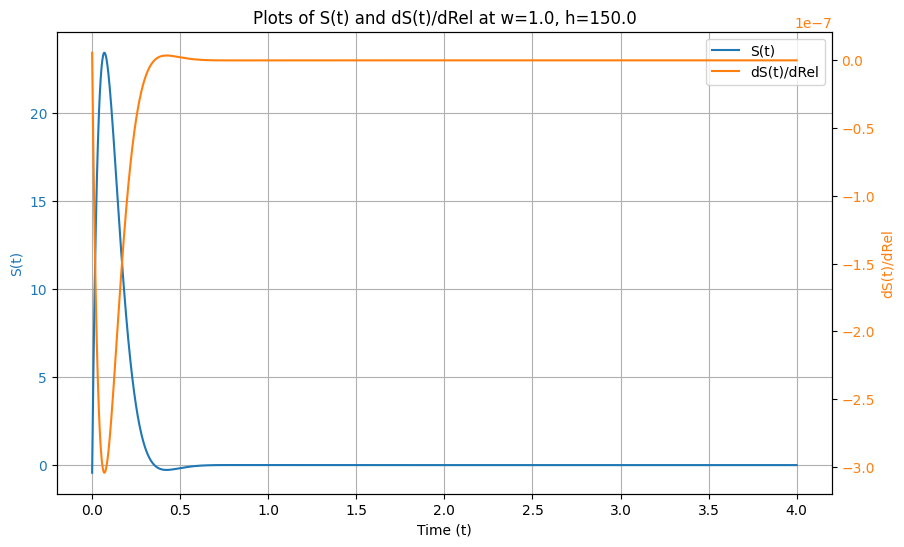

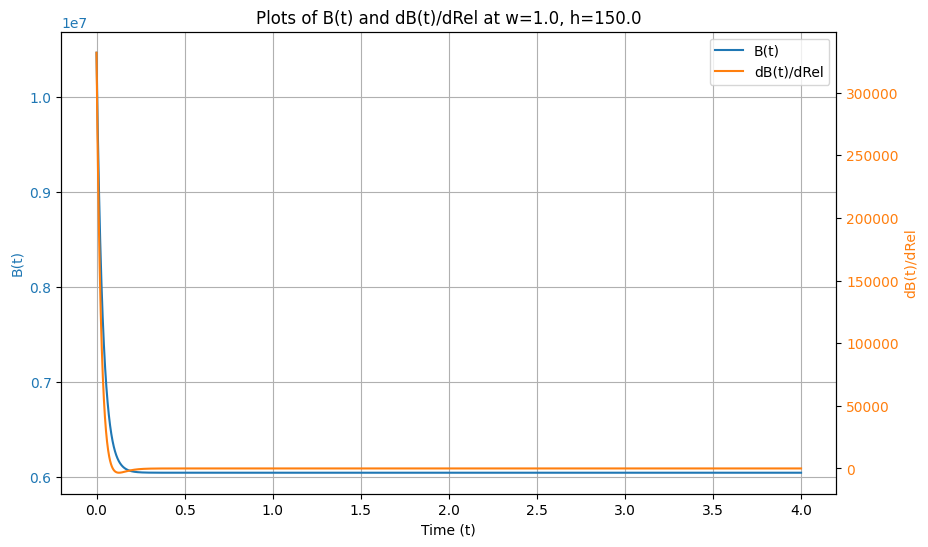

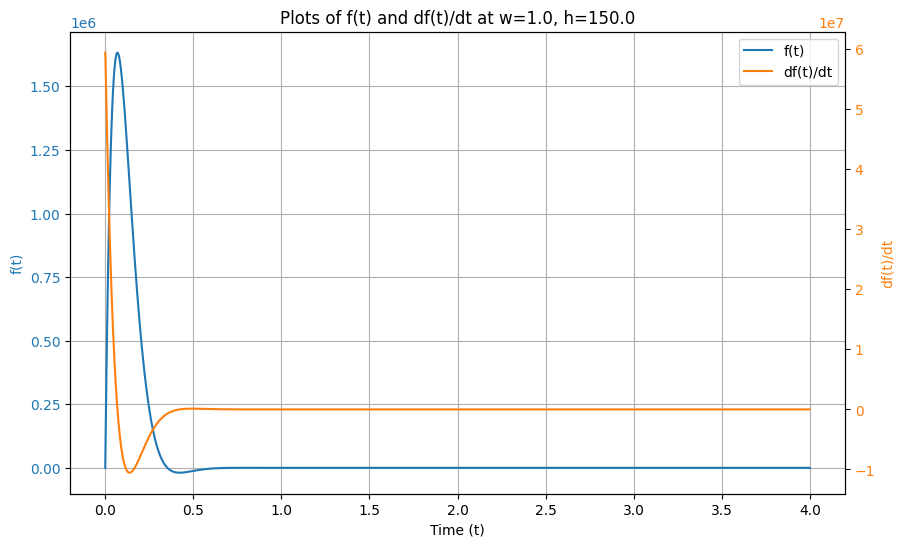

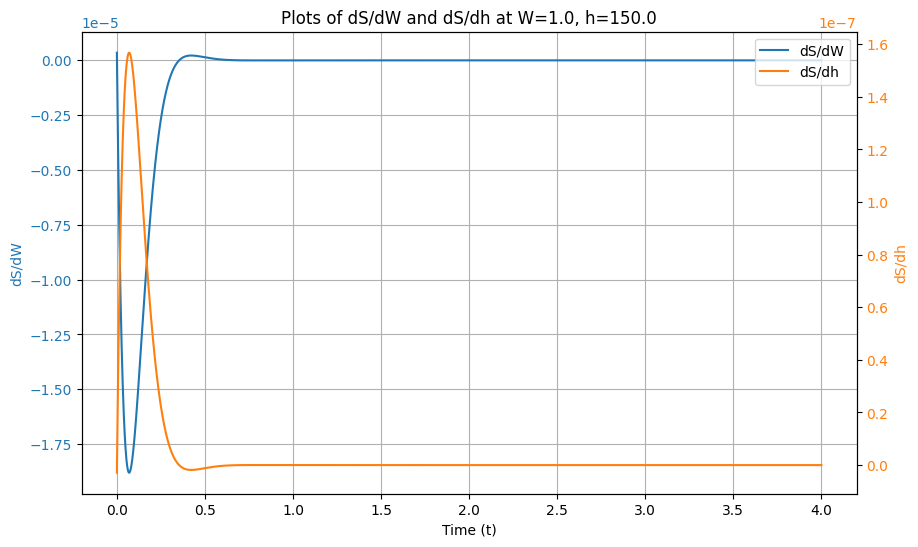

Analytical
dS/dW: -0.0029117874801158905
dS/dh: 2.4264892999781296e-05
Numerical
dS/dW: -1208.9931640625
dS/dh: 10.074943542480469
{'dS_dW_ana': Array([ 3.4789778e-07, -3.4497955e-07, -1.0205385e-06, ...,
        1.9868685e-28,  1.3294038e-28,  6.6702260e-29], dtype=float32), 'dS_dh_ana': Array([-2.8991478e-09,  2.8748293e-09,  8.5044878e-09, ...,
       -1.6557237e-30, -1.1078364e-30, -5.5585216e-31], dtype=float32), 'df_dt': Array([9.2668734e-02, 9.0352505e-02, 8.8072672e-02, ..., 8.7932503e-24,
       8.8590026e-24, 8.9210812e-24], dtype=float32), 'S_t': Array([-4.3342811e-01,  4.2980048e-01,  1.2714529e+00, ...,
       -2.4753615e-22, -1.6562518e-22, -8.3101725e-23], dtype=float32), 'f_t': Array([ 0.0000000e+00,  5.9374094e+04,  1.1725715e+05, ...,
       -7.8864326e-16, -7.8291769e-16, -7.7714950e-16], dtype=float32), 'B_t': Array([10468830. , 10345132. , 10224891. , ...,  6042600.5,  6042600.5,
        6042600.5], dtype=float32), 't': Array([0.0000000e+00, 1.0002501e-03, 2.000500

In [7]:
import jax
import jax.numpy as jnp
import jax.scipy.signal
from jax import grad, jit, vmap
import matplotlib.pyplot as plt

# Define the dictionary with constants for each material
constants_dict = {
    "Tuff/Rhyolite": {
        "h0": 122.0, "R0": 202.0, "gamma0": 26.0, "P10": 3.6E6, "P20": 5.0E6,
        "pv": 3500.0, "sv": 2021.0, "n": 2.4, "rho": 2000.0
    },
    "Granite": {
        "h0": 122.0, "R0": 321.0, "gamma0": 34.0, "P10": 4.6E6, "P20": 2.4E6,
        "pv": 5500.0, "sv": 3175.0, "n": 2.4, "rho": 2550.0
    },
    "Salt": {
        "h0": 122.0, "R0": 478.0, "gamma0": 31.0, "P10": 5.5E6, "P20": 0.8E6,
        "pv": 4670.0, "sv": 2696.0, "n": 1.87, "rho": 2200.0
    },
    "Shale": {
        "h0": 122.0, "R0": 265.0, "gamma0": 42.0, "P10": 4.2E6, "P20": 2.5E6,
        "pv": 4320.0, "sv": 2495.0, "n": 2.4, "rho": 2350.0
    },
    "Wet Tuff": {
        "h0": 122.0, "R0": 202.0, "gamma0": 26.0, "P10": 3.6E6, "P20": 5.0E6,
        "pv": 2400.0, "sv": 1300.0, "n": 2.4, "rho": 1915.0
    },
    "Wet Granite": {
        "h0": 122.0, "R0": 321.0, "gamma0": 34.0, "P10": 4.6E6, "P20": 2.4E6,
        "pv": 5350.0, "sv": 2795.0, "n": 2.4, "rho": 2650.0
    }
}

# Function to populate variables from the dictionary based on material name
def get_constants(material_name):
    if material_name in constants_dict:
        material_constants = constants_dict[material_name]
        h0 = jnp.array(material_constants["h0"])
        R0 = jnp.array(material_constants["R0"])
        gamma0 = jnp.array(material_constants["gamma0"])
        P10 = jnp.array(material_constants["P10"])
        P20 = jnp.array(material_constants["P20"])
        pv = jnp.array(material_constants["pv"])
        sv = jnp.array(material_constants["sv"])
        n = jnp.array(material_constants["n"])
        rho = jnp.array(material_constants["rho"])
        return h0, R0, gamma0, P10, P20, pv, sv, n, rho
    else:
        raise ValueError(f"Material '{material_name}' not found in the constants dictionary.")

def compute_partial_derivatives(w=1.0, h=150.0, material='Tuff/Rhyolite', plot=False):
    h0, R0, gamma0, P10, P20, pv, sv, n, rho = get_constants(material)
    mu = rho * sv ** 2
    lam = rho * pv ** 2 - 2 * mu
    h = jnp.array(h)
    w = jnp.array(w)
    t = jnp.linspace(0, 4.0, num=4000)

    def Heaviside(t):
        return jnp.where(t >= 0, 1.0, 0.0)

    H_t = Heaviside(t)
    R_el = R0 * (h0 / h) ** (1 / n) * w ** (1 / 3)
    gamma = gamma0 * (R0 / R_el)
    beta = (lam + 2 * mu) / (4 * mu)
    w0 = pv / R_el
    alpha = w0 / (2 * beta)
    p = w0 * jnp.sqrt(1 / (2 * beta) - 1 / (4 * beta ** 2))

    # Define f(t) based on equation (3)
    def f_t(R_el, t):
        return (R_el / (4 * alpha)) * (pv ** 2 / (beta * p)) * H_t * jnp.exp(-alpha * t) * jnp.sin(p * t)

    def df_t_dt(R_el, mu, pv, beta, p, alpha, t):
        A = (R_el / (4 * mu)) * (pv ** 2 / (beta * p))
        return A * H_t * jnp.exp(-alpha * t) * (-alpha * jnp.sin(p * t) + p * jnp.cos(p * t))

    f_t_val = f_t(R_el, t)
    df_dt = df_t_dt(R_el, mu, pv, beta, p, alpha, t)

    # Define B(t) based on equation (2)
    def B_t(R_el, t):
        P0_t = P10 * (h / h0)  # P1 - P2 with P1 and P2
        P2_t = P20 * (h0 / h) ** (1 / 3) * (R0 / R_el) ** 3 * w ** 0.87
        return (jnp.exp(-gamma * t) * P0_t + P2_t) * H_t

    B_t_val = B_t(R_el, t)
    df_dt_div = -df_dt / (R_el * pv)

    # Compute S(t) via convolution
    S_t_full = jax.scipy.signal.convolve(df_dt_div, B_t_val, mode='full')
    S_t = S_t_full[t.size - 1: t.size * 2 - 1]  # Ensure S_t has the same length as t

    # Compute analytical derivatives
    def dB_t_dRel_new(R_el, t):
        term1 = -jnp.exp(-gamma * t) * P10 * (h / h0) * (
            t * gamma / R_el - n / R_el * (h / h0) ** (1 / n)
        ) * (h * w ** (-1 / 3)) ** (1 / 3)
        term2 = P20 * w ** 0.87 * (
            (t * jnp.exp(-gamma * t) * R0 ** 3) / R_el ** 4 * (h0 / h) ** (1 / 3)
            - (t * jnp.exp(-gamma * t) * R0 ** 3) / R_el ** 4 * (h0 / h) ** (1 / 3)
        )
        term3 = (1 - jnp.exp(-gamma * t)) * (
            1 / 3 * n * R0 ** 2 / R_el ** 3 * (h0 / h) ** (1 / 3)
            * w ** (-2 / 3) * (h * w ** (-1 / 3)) ** (1 / 3)
        )
        term4 = (1 - jnp.exp(-gamma * t)) * (
            -3 * R0 ** 3 / R_el ** 4 * (h0 / h) ** (1 / 3)
            * (h * w ** (-1 / 3)) ** (1 / 3)
        )
        return (term1 + term2 + term3 + term4) * H_t

    dB_t_dRel_val = dB_t_dRel_new(R_el, t)
    dS_t_dRel_full = jax.scipy.signal.convolve(df_dt_div, dB_t_dRel_val, mode='full')
    dS_t_dRel = dS_t_dRel_full[t.size - 1: t.size * 2 - 1]

    def dRel_dw(R0, h0, h, n, w):
        return R0 * (h0 / h) ** (1 / n) * (1 / 3) * w ** (-2 / 3)

    def dRel_dh(R0, h0, h, n, w):
        return -R0 * (1 / n) * (h0 / h) ** (1 / n) * (1 / h) * w ** (1 / 3)

    dS_dW_ana = dS_t_dRel * dRel_dw(R0, h0, h, n, w)
    dS_dh_ana = dS_t_dRel * dRel_dh(R0, h0, h, n, w)

    # Compute numerical derivatives
    def S_t_sum(w, h):
        R_el = R0 * (h0 / h) ** (1 / n) * w ** (1 / 3)
        gamma = gamma0 * (R0 / R_el)
        beta = (lam + 2 * mu) / (4 * mu)
        w0 = pv / R_el
        alpha = w0 / (2 * beta)
        p = w0 * jnp.sqrt(1 / (2 * beta) - 1 / (4 * beta ** 2))
        df_dt = df_t_dt(R_el, mu, pv, beta, p, alpha, t)
        B_t_val = B_t(R_el, t)
        df_dt_div = -df_dt / (R_el * pv)
        S_t_full = jax.scipy.signal.convolve(df_dt_div, B_t_val, mode='full')
        S_t = S_t_full[t.size - 1: t.size * 2 - 1]
        return S_t.sum()

    dS_dW_num = grad(S_t_sum, argnums=0)(w, h)
    dS_dh_num = grad(S_t_sum, argnums=1)(w, h)

    # Prepare data for plotting
    t_cpu = jnp.array(t)
    S_t_cpu = jnp.array(S_t)
    B_t_cpu = jnp.array(B_t_val)
    f_t_cpu = jnp.array(f_t_val)
    dB_t_dRel_cpu = jnp.array(dB_t_dRel_val)
    dS_t_dRel_cpu = jnp.array(dS_t_dRel)
    dS_dW_ana_cpu = jnp.array(dS_dW_ana)
    dS_dh_ana_cpu = jnp.array(dS_dh_ana)

    # Compute df_dt_num using constant spacing
    dt = t[1] - t[0]
    df_dt_num = jnp.gradient(f_t_val, dt)

    if plot:
        # Plot S(t) and dS(t)/dRel
        fig, ax1 = plt.subplots(figsize=(10, 6))
        plt.grid(True)
        ax1.plot(t_cpu, S_t_cpu, label='S(t)', color='tab:blue')
        ax1.set_xlabel('Time (t)')
        ax1.set_ylabel('S(t)', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')

        ax2 = ax1.twinx()
        ax2.plot(t_cpu, dS_t_dRel_cpu, label='dS(t)/dRel', color='tab:orange')
        ax2.set_ylabel('dS(t)/dRel', color='tab:orange')
        ax2.tick_params(axis='y', labelcolor='tab:orange')

        # Combine legends
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

        plt.title(f'Plots of S(t) and dS(t)/dRel at w={w}, h={h}')
        plt.show()

        # Plot B(t) and dB(t)/dRel
        fig, ax1 = plt.subplots(figsize=(10, 6))
        plt.grid(True)
        ax1.plot(t_cpu, B_t_cpu, label='B(t)', color='tab:blue')
        ax1.set_xlabel('Time (t)')
        ax1.set_ylabel('B(t)', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')

        ax2 = ax1.twinx()
        ax2.plot(t_cpu, dB_t_dRel_cpu, label='dB(t)/dRel', color='tab:orange')
        ax2.set_ylabel('dB(t)/dRel', color='tab:orange')
        ax2.tick_params(axis='y', labelcolor='tab:orange')

        # Combine legends
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

        plt.title(f'Plots of B(t) and dB(t)/dRel at w={w}, h={h}')
        plt.show()

        # Plot f(t) and df(t)/dt
        fig, ax1 = plt.subplots(figsize=(10, 6))
        plt.grid(True)
        ax1.plot(t_cpu, f_t_cpu, label='f(t)', color='tab:blue')
        ax1.set_xlabel('Time (t)')
        ax1.set_ylabel('f(t)', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')

        ax2 = ax1.twinx()
        ax2.plot(t_cpu, df_dt_num, label='df(t)/dt', color='tab:orange')
        ax2.set_ylabel('df(t)/dt', color='tab:orange')
        ax2.tick_params(axis='y', labelcolor='tab:orange')

        # Combine legends
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

        plt.title(f'Plots of f(t) and df(t)/dt at w={w}, h={h}')
        plt.show()

        # Plot dS/dW and dS/dh
        fig, ax1 = plt.subplots(figsize=(10, 6))
        plt.grid(True)
        ax1.plot(t_cpu, dS_dW_ana_cpu, label='dS/dW', color='tab:blue')
        ax1.set_xlabel('Time (t)')
        ax1.set_ylabel('dS/dW', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')

        ax2 = ax1.twinx()
        ax2.plot(t_cpu, dS_dh_ana_cpu, label='dS/dh', color='tab:orange')
        ax2.set_ylabel('dS/dh', color='tab:orange')
        ax2.tick_params(axis='y', labelcolor='tab:orange')

        # Combine legends
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

        plt.title(f'Plots of dS/dW and dS/dh at W={w}, h={h}')
        plt.show()

        print('Analytical')
        print(f'dS/dW: {dS_dW_ana.sum()}')
        print(f'dS/dh: {dS_dh_ana.sum()}')
        print('Numerical')
        print(f'dS/dW: {dS_dW_num}')
        print(f'dS/dh: {dS_dh_num}')

    out = {
        'dS_dW_ana': dS_dW_ana_cpu,
        'dS_dh_ana': dS_dh_ana_cpu,
        'df_dt': df_dt,
        'S_t': S_t_cpu,
        'f_t': f_t_cpu,
        'B_t': B_t_cpu,
        't': t_cpu,
        'dB_t_dRel': dB_t_dRel_cpu,
        'dS_t_dRel': dS_t_dRel_cpu,
        'R_el*pv': (R_el * pv),
        'h': h,
        'w': w
    }

    return out

# Example usage
plot = True
material = 'Tuff/Rhyolite'  # Options: Tuff/Rhyolite, Granite, Salt, Shale, Wet Tuff, Wet Granite
result = compute_partial_derivatives(w=1.0, h=150.0, material=material, plot=plot)

# Display the result
print(result)


## PINN Implementation (Validated)

100%|██████████| 5000/5000 [02:11<00:00, 38.16it/s, Total Loss=0.00323, LR=3.64e-15, Data Loss=0.000656, dS/dW Loss=0.000701, dS/dh Loss=0.00188]


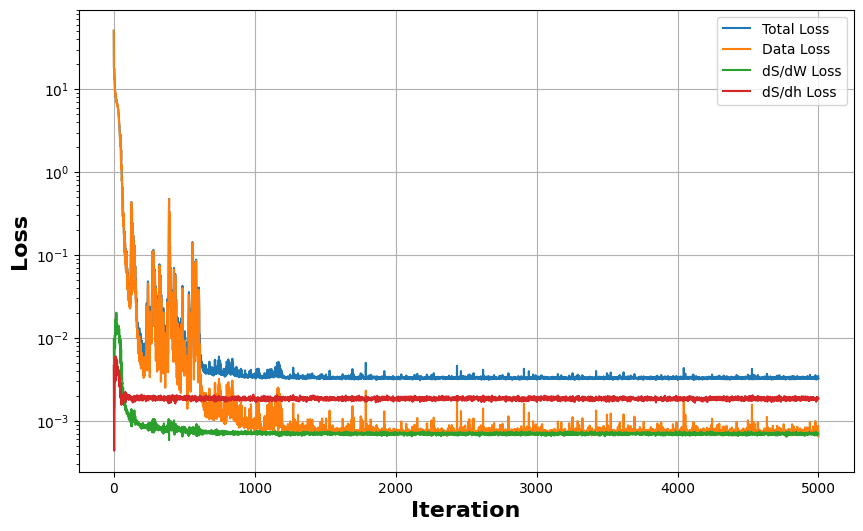

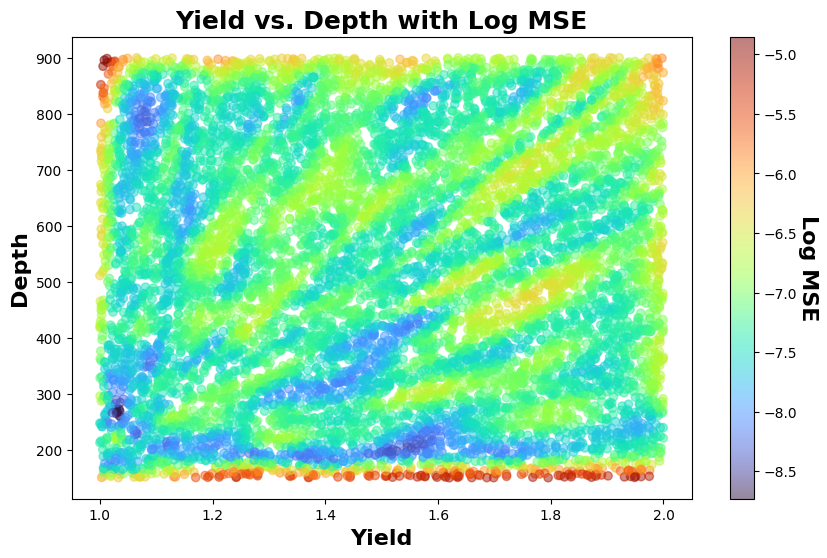

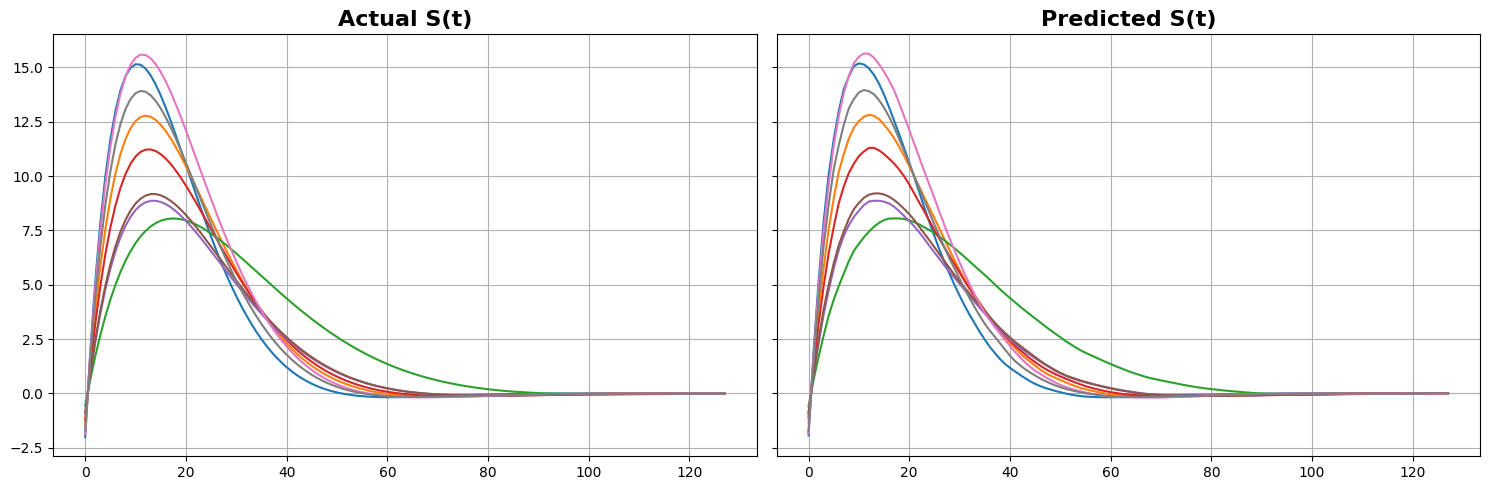

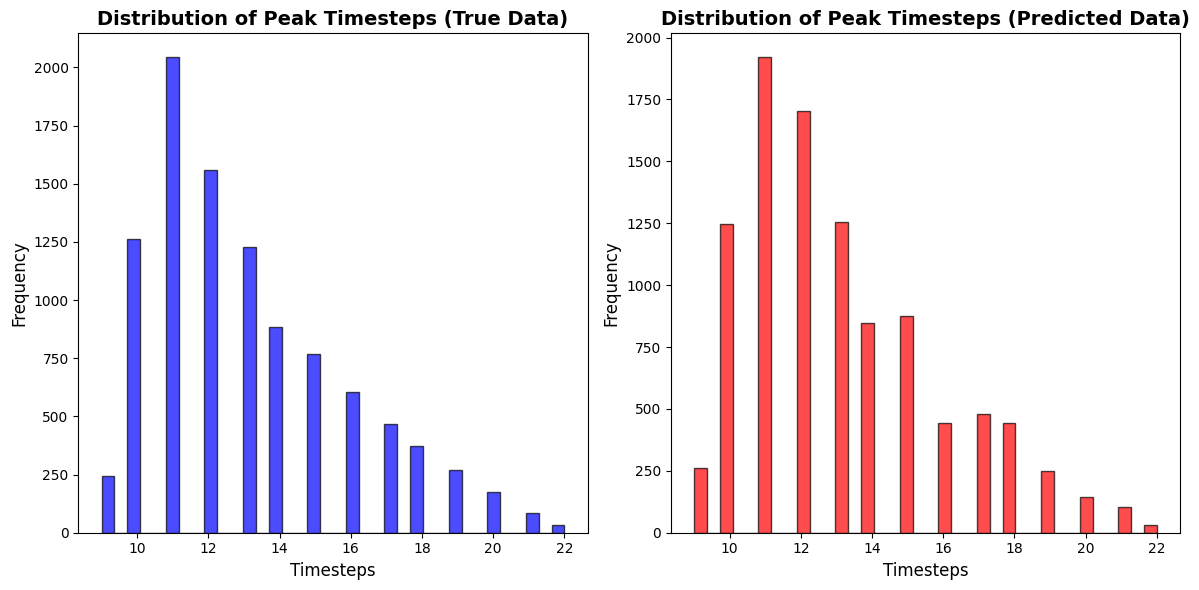

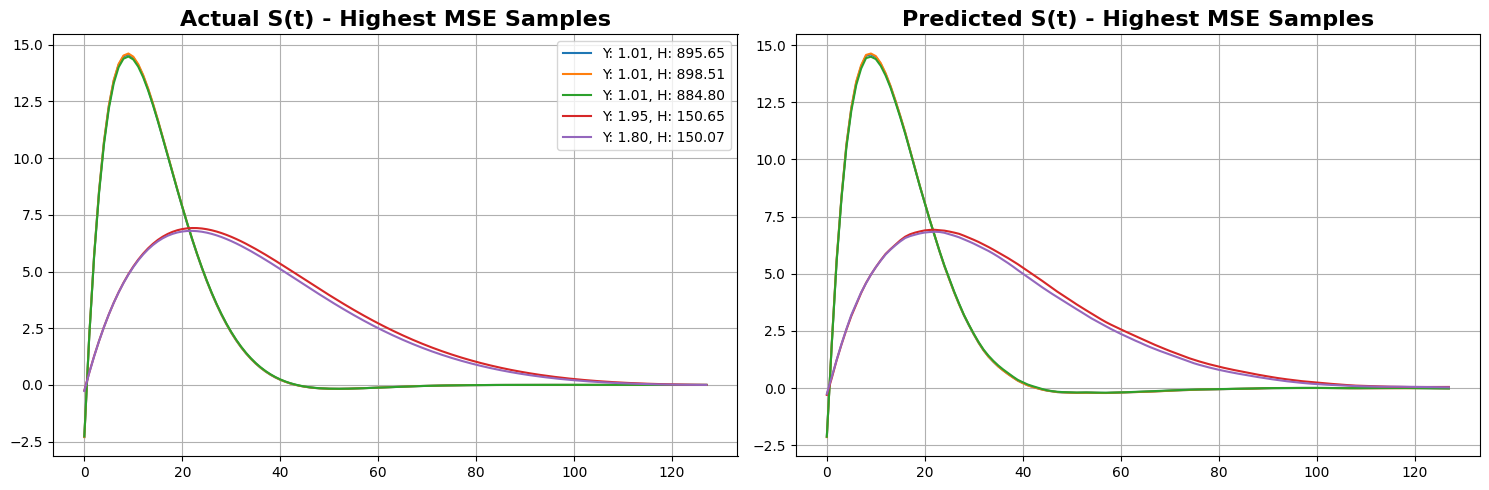

In [2]:
import jax
import jax.numpy as jnp
from flax import linen as nn
import optax
from optax import tree_utils as otu
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange




# Update JAX configuration
jax.config.update("jax_enable_x64", False)

# Set the random seed
base_seed = 42
key = jax.random.PRNGKey(base_seed)
np.random.seed(base_seed)

# Define the dictionary with constants for each material
constants_dict = {
    "Tuff/Rhyolite": {
        "h0": 122.0, "R0": 202.0, "gamma0": 26.0, "P10": 3.6e6, "P20": 5.0e6,
        "pv": 3500.0, "sv": 2021.0, "n": 2.4, "rho": 2000.0
    },
    "Granite": {
        "h0": 122.0, "R0": 321.0, "gamma0": 34.0, "P10": 4.6e6, "P20": 2.4e6,
        "pv": 5500.0, "sv": 3175.0, "n": 2.4, "rho": 2550.0
    },
    # ... other materials if needed ...
}

# Function to retrieve constants for a material
def get_constants(material_name):
    if material_name in constants_dict:
        material_constants = constants_dict[material_name]
        # Convert constants to JAX arrays with dtype float32
        return {key: jnp.array(value, dtype=jnp.float32) for key, value in material_constants.items()}
    else:
        raise ValueError(f"Material '{material_name}' not found in the constants dictionary.")

# Set the material and get constants
material = 'Tuff/Rhyolite'
constants = get_constants(material)

# Define the Neural Network class using Flax
class NeuralNet(nn.Module):
    input_dimension: int
    output_dimension: int
    n_hidden_layers: int
    neurons: int
    activation: callable
    regularization_param: float
    regularization_exp: float

    def setup(self):
        # Use LeCun uniform initializer for tanh activation
        kernel_init = nn.initializers.lecun_uniform()
        bias_init = nn.initializers.zeros

        # Layers
        self.input_layer = nn.Dense(
            self.neurons, kernel_init=kernel_init, bias_init=bias_init)
        self.hidden_layers = [
            nn.Dense(self.neurons, kernel_init=kernel_init, bias_init=bias_init)
            for _ in range(self.n_hidden_layers - 1)
        ]
        self.output_layer = nn.Dense(
            self.output_dimension, kernel_init=kernel_init, bias_init=bias_init)

    def __call__(self, x):
        x = self.activation(self.input_layer(x))
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        return self.output_layer(x)

    def l2_regularization(self):
        params = self.get_variable('params', 'kernel')
        reg_loss = 0.0
        for param in jax.tree_leaves(params):
            reg_loss += jnp.sum(jnp.abs(param) ** self.regularization_exp)
        return self.regularization_param * reg_loss

# Create the compute_stf_batch function with constants embedded
def make_compute_stf_batch(constants):
    h0 = constants['h0']
    R0 = constants['R0']
    gamma0 = constants['gamma0']
    P10 = constants['P10']
    P20 = constants['P20']
    pv = constants['pv']
    sv = constants['sv']
    n = constants['n']
    rho = constants['rho']

    @jax.jit
    def compute_stf_batch(w, h, t):
        mu = rho * sv ** 2
        lam = rho * pv ** 2 - 2 * mu

        # Compute R_el, gamma, beta, etc.
        h_ratio = h0 / h
        w_power = w ** (1 / 3)
        R_el = R0 * h_ratio ** (1 / n) * w_power
        gamma = gamma0 * (R0 / R_el)
        beta = (lam + 2 * mu) / (4 * mu)
        w0 = pv / R_el
        alpha = w0 / (2 * beta)
        sqrt_term = jnp.sqrt(1 / (2 * beta) - 1 / (4 * beta ** 2))
        p = w0 * sqrt_term

        exp_alpha_t = jnp.exp(-alpha * t)
        sin_p_t = jnp.sin(p * t)
        cos_p_t = jnp.cos(p * t)
        exp_gamma_t = jnp.exp(-gamma * t)
        H_t = jnp.where(t >= 0, 1.0, 0.0)

        # Compute f(t) and its derivative df/dt
        pv_squared = pv ** 2
        beta_p = beta * p
        f_prefactor = (R_el / (4 * alpha)) * (pv_squared / beta_p)
        f_t_val = f_prefactor * exp_alpha_t * sin_p_t * H_t

        A = (R_el / (4 * mu)) * (pv_squared / beta_p)
        df_dt = A * exp_alpha_t * (-alpha * sin_p_t + p * cos_p_t) * H_t

        # Compute B(t)
        P0_t = P10 * (h / h0)
        h_ratio_third = h_ratio ** (1 / 3)
        R_ratio_cubed = (R0 / R_el) ** 3
        P2_t = P20 * h_ratio_third * R_ratio_cubed * w ** 0.87
        B_t_val = (exp_gamma_t * P0_t + P2_t) * H_t

        df_dt_div = -df_dt / (R_el * pv)

        # Convolution
        S_t = jax.vmap(lambda a, b: jnp.convolve(a, b, mode='full'))(df_dt_div, B_t_val)
        S_t = S_t[:, t.shape[1] - 1: t.shape[1] * 2 - 1]

        # Analytical derivatives
        gamma_over_Rel = gamma / R_el
        n_over_Rel = n / R_el
        term1 = -exp_gamma_t * P10 * (h / h0) * (
            t * gamma_over_Rel - n_over_Rel * h_ratio ** (1 / n)
        ) * (h * w ** (-1 / 3)) ** (1 / 3)
        term3 = (1 - exp_gamma_t) * (
            (1 / 3) * n * R0 ** 2 / R_el ** 3 * h_ratio_third * w ** (-2 / 3) * (h * w ** (-1 / 3)) ** (1 / 3)
        )
        term4 = (1 - exp_gamma_t) * (
            -3 * R0 ** 3 / R_el ** 4 * h_ratio_third * (h * w ** (-1 / 3)) ** (1 / 3)
        )
        dB_t_dRel = (term1 + term3 + term4) * H_t

        dS_t_dRel = jax.vmap(lambda a, b: jnp.convolve(a, b, mode='full'))(df_dt_div, dB_t_dRel)
        dS_t_dRel = dS_t_dRel[:, t.shape[1] - 1: t.shape[1] * 2 - 1]

        # Derivatives of R_el
        dRel_dw = R_el / (3 * w)
        dRel_dh = -R_el / (n * h)

        dS_dW_ana = dS_t_dRel * dRel_dw
        dS_dh_ana = dS_t_dRel * dRel_dh

        return S_t, dS_dW_ana, dS_dh_ana

    return compute_stf_batch

# Create the compute_stf_batch function with constants embedded
compute_stf_batch = make_compute_stf_batch(constants)

# Generate batch function without passing 'material'
def generate_batch(key, b, nt, hmin, hmax, wmin, wmax, tmin, tmax):
    key, subkey = jax.random.split(key)
    h = jax.random.uniform(subkey, shape=(b, 1), minval=hmin, maxval=hmax)
    key, subkey = jax.random.split(key)
    w = jax.random.uniform(subkey, shape=(b, 1), minval=wmin, maxval=wmax)
    t = jnp.linspace(tmin, tmax, nt)
    t = jnp.tile(t, (b, 1))  # Shape (b, nt)

    # Compute STF and derivatives
    S_t, dS_dW, dS_dh = compute_stf_batch(w, h, t)

    hnorm = (h / hmax).squeeze()        # Shape (b,)
    wnorm = (w / wmax).squeeze()        # Shape (b,)
    tnorm = t / tmax                    # Shape (b, nt)
    tnorm_flat = tnorm.flatten()        # Shape (b * nt,)

    # Prepare input x
    x = jnp.stack((
        tnorm_flat,                    # Shape (b * nt,)
        jnp.repeat(wnorm, nt),         # Shape (b * nt,)
        jnp.repeat(hnorm, nt)          # Shape (b * nt,)
    ), axis=-1)

    # Compute smax and smin
    smax = jnp.max(S_t, axis=1, keepdims=True)  # Shape (b, 1)
    smin = jnp.min(S_t, axis=1, keepdims=True)  # Shape (b, 1)

    # Repeat smax and smin along the time axis to match (b, nt)
    smax = jnp.tile(smax, (1, nt)).flatten()    # Shape (b * nt,)
    smin = jnp.tile(smin, (1, nt)).flatten()    # Shape (b * nt,)

    # Flatten S_t and derivatives
    S_t_flat = S_t.flatten()         # Shape (b * nt,)
    dS_dW_flat = dS_dW.flatten()     # Shape (b * nt,)
    dS_dh_flat = dS_dh.flatten()     # Shape (b * nt,)

    # Compute per-sample xmax and xmin
    xmax = jnp.max(x, axis=0, keepdims=True)  # Shape (1, 3)
    xmin = jnp.min(x, axis=0, keepdims=True)  # Shape (1, 3)

    # Prepare batch data
    batch = (
        x,                 # Shape (b * nt, 3)
        S_t_flat,          # Shape (b * nt,)
        smax,              # Shape (b * nt,)
        smin,              # Shape (b * nt,)
        xmax,              # Shape (1, 3)
        xmin,              # Shape (1, 3)
        dS_dW_flat,        # Shape (b * nt,)
        dS_dh_flat         # Shape (b * nt,)
    )

    return key, batch

# Training parameters
b = 512
nt = 128
tmax = 0.5
tmin = 0.0
n_iter = 5000

hmin = 150.0
hmax = 900.0
wmin = 1.0
wmax = 2.0

lam_w = 1e-4
lam_h = 1e-4
lam_d = 1e-0

# Create the model
model = NeuralNet(
    input_dimension=3,
    output_dimension=1,
    n_hidden_layers=6,
    neurons=256,
    activation=nn.relu,
    regularization_param=0.5,
    regularization_exp=2.0,
)

# Initialize model parameters
key, subkey = jax.random.split(key)
dummy_input = jnp.ones((1, 3), dtype=jnp.float32)
params = model.init(subkey, dummy_input)

# Define optimizer and scheduler
initial_learning_rate = 1e-3

optimizer = optax.chain(
    optax.adam(initial_learning_rate),
        optax.contrib.reduce_on_plateau(
        patience=100,
        cooldown=0,
        factor=0.5,
        rtol=0.0001,
        accumulation_size=1,
    ),
)
opt_state = optimizer.init(params)

# Define the loss function
def loss_fn(params, batch):
    x, S_t, smax, smin, xmax, xmin, dS_dW, dS_dh = batch
    # Forward pass
    s = model.apply(params, (x - xmin) / (xmax - xmin))
    s = s.squeeze() * (smax - smin) + smin

    # Data loss
    loss_d = lam_d * jnp.mean((s - S_t) ** 2)

    # Compute gradients w.r.t x
    def s_fn(x_i, smax_i, smin_i):
        x_i_norm = (x_i - xmin) / (xmax - xmin)
        s_i = model.apply(params, x_i_norm).squeeze() * (smax_i - smin_i) + smin_i
        return s_i

    # Vectorize gradient computation over all samples
    grad_s_x = jax.vmap(
        jax.grad(s_fn, argnums=0),
        in_axes=(0, 0, 0)
    )(x, smax, smin)

    # Extract gradients w.r.t wnorm and hnorm (x[:,1], x[:,2])
    grad_s_w = grad_s_x[:, 1]  # Gradient w.r.t wnorm
    grad_s_h = grad_s_x[:, 2]  # Gradient w.r.t hnorm

    # Derivative losses
    loss_sw = lam_w * jnp.mean((grad_s_w - dS_dW) ** 2)
    loss_sh = lam_h * jnp.mean((grad_s_h - dS_dh) ** 2)

    # Total loss
    total_loss = loss_d + loss_sw + loss_sh
    return total_loss, (loss_d, loss_sw, loss_sh)

@jax.jit
def train_step(params, opt_state, batch, step):
    (loss, losses), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, batch)
    updates, opt_state = optimizer.update(grads, opt_state, params, step=step, value=loss)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss, losses

# Pre-compile the train_step function
key, batch = generate_batch(key, b, nt, hmin, hmax, wmin, wmax, tmin, tmax)
params, opt_state, _, _ = train_step(params, opt_state, batch, 0)

# Training loop with progress bar
losses = []
loss_d_list = []
loss_sw_list = []
loss_sh_list = []
learning_rates = []

pbar = trange(n_iter)
for step in pbar:
    # Generate batch data
    key, batch = generate_batch(key, b, nt, hmin, hmax, wmin, wmax, tmin, tmax)

    # Perform a training step
    params, opt_state, loss, (loss_d, loss_sw, loss_sh) = train_step(params, opt_state, batch, step)

    # Update loss lists
    losses.append(float(loss))
    loss_d_list.append(float(loss_d))
    loss_sw_list.append(float(loss_sw))
    loss_sh_list.append(float(loss_sh))

    # Get the current learning rate from the scheduler
    lr_scale = otu.tree_get(opt_state, "scale")
    current_lr = lr_scale * initial_learning_rate
    learning_rates.append(float(current_lr))

    # Update progress bar
    pbar.set_postfix({
        'Total Loss': float(loss),
        'LR': float(current_lr),
        'Data Loss': float(loss_d),
        'dS/dW Loss': float(loss_sw),
        'dS/dh Loss': float(loss_sh)
    })

# Plot losses
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(losses, label='Total Loss')
plt.plot(loss_d_list, label='Data Loss')
plt.plot(loss_sw_list, label='dS/dW Loss')
plt.plot(loss_sh_list, label='dS/dh Loss')
plt.yscale('log')
plt.xlabel('Iteration', fontsize=16, fontweight='bold')
plt.ylabel('Loss', fontsize=16, fontweight='bold')
plt.legend()
plt.show()


# Evaluate the model
b = 10000  # Batch size for evaluation

# Generate new h, w, t values for evaluation
key, subkey = jax.random.split(key)
h = jax.random.uniform(subkey, shape=(b, 1), minval=hmin, maxval=hmax)
key, subkey = jax.random.split(key)
w = jax.random.uniform(subkey, shape=(b, 1), minval=wmin, maxval=wmax)
t = jnp.linspace(tmin, tmax, nt)
t = jnp.tile(t, (b, 1))  # Shape (b, nt)

# Compute true S_t and analytical derivatives
S_t, dS_dW_ana, dS_dh_ana = compute_stf_batch(w, h, t)

# Normalize h, w, t
hnorm = (h / hmax).squeeze()  # Shape (b,)
wnorm = (w / wmax).squeeze()  # Shape (b,)
tnorm = t / tmax              # Shape (b, nt)

# Flatten tnorm
tnorm_flat = tnorm.flatten()  # Shape (b * nt,)

# Repeat hnorm and wnorm to match the time dimension
hnorm_flat = jnp.repeat(hnorm, nt)  # Shape (b * nt,)
wnorm_flat = jnp.repeat(wnorm, nt)  # Shape (b * nt,)

# Prepare input x by stacking tnorm_flat, wnorm_flat, and hnorm_flat
x = jnp.stack((tnorm_flat, wnorm_flat, hnorm_flat), axis=-1)  # Shape (b * nt, 3)

# Compute xmax and xmin over all data (consistent with training)
xmax = jnp.max(x, axis=0, keepdims=True)  # Shape (1, 3)
xmin = jnp.min(x, axis=0, keepdims=True)  # Shape (1, 3)

# Normalize x
x_normalized = (x - xmin) / (xmax - xmin)  # Shape (b * nt, 3)

# Compute smax and smin per sample
smax = jnp.max(S_t, axis=1, keepdims=True)  # Shape (b, 1)
smin = jnp.min(S_t, axis=1, keepdims=True)  # Shape (b, 1)

# Repeat smax and smin along the time dimension to match (b, nt)
smax = jnp.tile(smax, (1, nt)).flatten()  # Shape (b * nt,)
smin = jnp.tile(smin, (1, nt)).flatten()  # Shape (b * nt,)

# Evaluate the model
s_pred = model.apply(params, x_normalized)  # Shape (b * nt, 1)
s_pred = s_pred.squeeze()  # Shape (b * nt,)

# Apply inverse normalization to s_pred
s_pred = s_pred * (smax - smin) + smin  # Shape (b * nt,)

# Reshape s_pred and S_t to (b, nt) for comparison
s_pred = s_pred.reshape(b, nt)  # Shape (b, nt)
S_t = S_t.reshape(b, nt)        # Shape (b, nt)

# Compute MSE over time steps for each sample
mse = jnp.mean((S_t - s_pred) ** 2, axis=1)  # Shape (b,)

# Convert JAX arrays to NumPy arrays for plotting
w_np = np.array(w.squeeze())
h_np = np.array(h.squeeze())
mse_np = np.array(mse)
S_t_np = np.array(S_t)
s_pred_np = np.array(s_pred)

# Plot yield vs depth with MSE
fig = plt.figure(figsize=(10, 6))
plt.scatter(
    x=w_np,  # Yield values
    y=h_np,  # Depth values
    c=np.log(mse_np),  # Log of MSE for color mapping
    cmap='turbo',
    alpha=0.5
)
cbar = plt.colorbar()
cbar.set_label('Log MSE', rotation=270, fontsize=16, fontweight='bold')
cbar.ax.get_yaxis().labelpad = 15
plt.xlabel('Yield', fontsize=16, fontweight='bold')
plt.ylabel('Depth', fontsize=16, fontweight='bold')
plt.title('Yield vs. Depth with Log MSE', fontsize=18, fontweight='bold')
plt.show()

# Plot actual and predicted S(t)
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
for ax in axs:
    ax.grid(True)

axs[0].set_title('Actual S(t)', fontsize=16, fontweight='bold')
axs[1].set_title('Predicted S(t)', fontsize=16, fontweight='bold')

for i in range(8):
    axs[0].plot(S_t_np[i], alpha=1.)
    axs[1].plot(s_pred_np[i], alpha=1.)

plt.tight_layout()
plt.show()

# Find peaks for true and predicted data
true_peaks = np.argmax(S_t_np, axis=1)      # Shape (b,)
predicted_peaks = np.argmax(s_pred_np, axis=1)   # Shape (b,)

# Plot the distribution of peaks
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(true_peaks, bins='auto', color='blue', alpha=0.7, edgecolor='black')
plt.title('Distribution of Peak Timesteps (True Data)', fontsize=14, fontweight='bold')
plt.xlabel('Timesteps', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.subplot(1, 2, 2)
plt.hist(predicted_peaks, bins='auto', color='red', alpha=0.7, edgecolor='black')
plt.title('Distribution of Peak Timesteps (Predicted Data)', fontsize=14, fontweight='bold')
plt.xlabel('Timesteps', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

# Determine the number of samples to plot
N = 5  # You can adjust N to plot more or fewer samples

# Get indices of samples sorted by MSE in descending order
sorted_indices = np.argsort(mse_np)[::-1]

# Select the top N samples
top_indices = sorted_indices[:N]

# Plot actual and predicted S(t) for top N samples with highest MSE
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
for ax in axs:
    ax.grid(True)

axs[0].set_title('Actual S(t) - Highest MSE Samples', fontsize=16, fontweight='bold')
axs[1].set_title('Predicted S(t) - Highest MSE Samples', fontsize=16, fontweight='bold')

for idx in top_indices:
    axs[0].plot(S_t_np[idx], label=f'Y: {w_np[idx]:.2f}, H: {h_np[idx]:.2f}')
    axs[1].plot(s_pred_np[idx], label=f'Y: {w_np[idx]:.2f}, H: {h_np[idx]:.2f}')

# Optionally, add legends to identify samples
axs[0].legend()
# axs[1].legend()

plt.tight_layout()
plt.show()


## Grid search of loss penalties

  0%|          | 0/64 [00:00<?, ?it/s]

Training with lam_d=1e-10, lam_w=1e-10, lam_h=1e-10


  2%|▏         | 1/64 [02:04<2:11:14, 124.99s/it]

Final MSE: 5.62595272064209
Training with lam_d=1e-10, lam_w=1e-10, lam_h=1e-05


  3%|▎         | 2/64 [04:11<2:09:47, 125.60s/it]

Final MSE: 15.356956481933594
Training with lam_d=1e-10, lam_w=1e-10, lam_h=0.0001


  5%|▍         | 3/64 [06:23<2:10:41, 128.55s/it]

Final MSE: 15.550735473632812
Training with lam_d=1e-10, lam_w=1e-10, lam_h=0.001


  6%|▋         | 4/64 [08:31<2:08:31, 128.53s/it]

Final MSE: 15.664337158203125
Training with lam_d=1e-10, lam_w=1e-05, lam_h=1e-10


  8%|▊         | 5/64 [10:43<2:07:42, 129.87s/it]

Final MSE: 15.391271591186523
Training with lam_d=1e-10, lam_w=1e-05, lam_h=1e-05


  9%|▉         | 6/64 [12:58<2:07:09, 131.54s/it]

Final MSE: 15.67462158203125
Training with lam_d=1e-10, lam_w=1e-05, lam_h=0.0001


 11%|█         | 7/64 [15:09<2:04:40, 131.24s/it]

Final MSE: 15.990718841552734
Training with lam_d=1e-10, lam_w=1e-05, lam_h=0.001


 12%|█▎        | 8/64 [17:11<1:59:51, 128.42s/it]

Final MSE: 16.237951278686523
Training with lam_d=1e-10, lam_w=0.0001, lam_h=1e-10


 14%|█▍        | 9/64 [19:14<1:56:03, 126.60s/it]

Final MSE: 15.634846687316895
Training with lam_d=1e-10, lam_w=0.0001, lam_h=1e-05


 16%|█▌        | 10/64 [21:19<1:53:36, 126.23s/it]

Final MSE: 15.94443130493164
Training with lam_d=1e-10, lam_w=0.0001, lam_h=0.0001


 17%|█▋        | 11/64 [23:22<1:50:38, 125.26s/it]

Final MSE: 16.13978385925293
Training with lam_d=1e-10, lam_w=0.0001, lam_h=0.001


 19%|█▉        | 12/64 [25:25<1:47:54, 124.50s/it]

Final MSE: 16.065563201904297
Training with lam_d=1e-10, lam_w=0.001, lam_h=1e-10


 20%|██        | 13/64 [27:24<1:44:29, 122.94s/it]

Final MSE: 15.694498062133789
Training with lam_d=1e-10, lam_w=0.001, lam_h=1e-05


 22%|██▏       | 14/64 [29:24<1:41:39, 122.00s/it]

Final MSE: 15.629693984985352
Training with lam_d=1e-10, lam_w=0.001, lam_h=0.0001


 23%|██▎       | 15/64 [31:23<1:38:54, 121.11s/it]

Final MSE: 16.597604751586914
Training with lam_d=1e-10, lam_w=0.001, lam_h=0.001


 25%|██▌       | 16/64 [33:23<1:36:36, 120.76s/it]

Final MSE: 15.653809547424316
Training with lam_d=0.01, lam_w=1e-10, lam_h=1e-10


 27%|██▋       | 17/64 [35:23<1:34:30, 120.65s/it]

Final MSE: 0.0005122281145304441
Training with lam_d=0.01, lam_w=1e-10, lam_h=1e-05


 28%|██▊       | 18/64 [37:23<1:32:15, 120.34s/it]

Final MSE: 0.003789399052038789
Training with lam_d=0.01, lam_w=1e-10, lam_h=0.0001


 30%|██▉       | 19/64 [39:22<1:29:53, 119.85s/it]

Final MSE: 0.03661680221557617
Training with lam_d=0.01, lam_w=1e-10, lam_h=0.001


 31%|███▏      | 20/64 [41:20<1:27:33, 119.40s/it]

Final MSE: 0.3219635486602783
Training with lam_d=0.01, lam_w=1e-05, lam_h=1e-10


 33%|███▎      | 21/64 [43:20<1:25:38, 119.50s/it]

Final MSE: 0.002120044082403183
Training with lam_d=0.01, lam_w=1e-05, lam_h=1e-05


 34%|███▍      | 22/64 [45:18<1:23:24, 119.14s/it]

Final MSE: 0.005800436716526747
Training with lam_d=0.01, lam_w=1e-05, lam_h=0.0001


 36%|███▌      | 23/64 [47:17<1:21:14, 118.89s/it]

Final MSE: 0.03700453042984009
Training with lam_d=0.01, lam_w=1e-05, lam_h=0.001


 38%|███▊      | 24/64 [49:16<1:19:23, 119.09s/it]

Final MSE: 0.31576302647590637
Training with lam_d=0.01, lam_w=0.0001, lam_h=1e-10


 39%|███▉      | 25/64 [51:15<1:17:16, 118.89s/it]

Final MSE: 0.013191726990044117
Training with lam_d=0.01, lam_w=0.0001, lam_h=1e-05


 41%|████      | 26/64 [53:14<1:15:27, 119.15s/it]

Final MSE: 0.015509571880102158
Training with lam_d=0.01, lam_w=0.0001, lam_h=0.0001


 42%|████▏     | 27/64 [55:13<1:13:25, 119.07s/it]

Final MSE: 0.04794545844197273
Training with lam_d=0.01, lam_w=0.0001, lam_h=0.001


 44%|████▍     | 28/64 [57:12<1:11:19, 118.88s/it]

Final MSE: 0.3225216269493103
Training with lam_d=0.01, lam_w=0.001, lam_h=1e-10


 45%|████▌     | 29/64 [59:10<1:09:17, 118.78s/it]

Final MSE: 0.07197012007236481
Training with lam_d=0.01, lam_w=0.001, lam_h=1e-05


 47%|████▋     | 30/64 [1:01:09<1:07:23, 118.93s/it]

Final MSE: 0.06982751190662384
Training with lam_d=0.01, lam_w=0.001, lam_h=0.0001


 48%|████▊     | 31/64 [1:03:09<1:05:28, 119.05s/it]

Final MSE: 0.10428617149591446
Training with lam_d=0.01, lam_w=0.001, lam_h=0.001


 50%|█████     | 32/64 [1:05:08<1:03:29, 119.04s/it]

Final MSE: 0.38181567192077637
Training with lam_d=0.1, lam_w=1e-10, lam_h=1e-10


 52%|█████▏    | 33/64 [1:07:07<1:01:30, 119.04s/it]

Final MSE: 0.0004723386373370886
Training with lam_d=0.1, lam_w=1e-10, lam_h=1e-05


 53%|█████▎    | 34/64 [1:09:08<59:48, 119.63s/it]  

Final MSE: 0.0007396845030598342
Training with lam_d=0.1, lam_w=1e-10, lam_h=0.0001


 55%|█████▍    | 35/64 [1:11:08<57:58, 119.93s/it]

Final MSE: 0.003880710108205676
Training with lam_d=0.1, lam_w=1e-10, lam_h=0.001


 56%|█████▋    | 36/64 [1:13:09<55:59, 120.00s/it]

Final MSE: 0.03631528466939926
Training with lam_d=0.1, lam_w=1e-05, lam_h=1e-10


 58%|█████▊    | 37/64 [1:15:09<54:02, 120.09s/it]

Final MSE: 0.000691665627527982
Training with lam_d=0.1, lam_w=1e-05, lam_h=1e-05


 59%|█████▉    | 38/64 [1:17:13<52:34, 121.34s/it]

Final MSE: 0.0008858191431500018
Training with lam_d=0.1, lam_w=1e-05, lam_h=0.0001


 61%|██████    | 39/64 [1:19:22<51:33, 123.74s/it]

Final MSE: 0.003850421169772744
Training with lam_d=0.1, lam_w=1e-05, lam_h=0.001


 62%|██████▎   | 40/64 [1:21:26<49:30, 123.75s/it]

Final MSE: 0.0350571908056736
Training with lam_d=0.1, lam_w=0.0001, lam_h=1e-10


 64%|██████▍   | 41/64 [1:23:42<48:46, 127.26s/it]

Final MSE: 0.0018726169364526868
Training with lam_d=0.1, lam_w=0.0001, lam_h=1e-05


 66%|██████▌   | 42/64 [1:25:45<46:12, 126.04s/it]

Final MSE: 0.0021474487148225307
Training with lam_d=0.1, lam_w=0.0001, lam_h=0.0001


 67%|██████▋   | 43/64 [1:27:45<43:31, 124.34s/it]

Final MSE: 0.004773295018821955
Training with lam_d=0.1, lam_w=0.0001, lam_h=0.001


 69%|██████▉   | 44/64 [1:29:46<41:07, 123.40s/it]

Final MSE: 0.03687474504113197
Training with lam_d=0.1, lam_w=0.001, lam_h=1e-10


 70%|███████   | 45/64 [1:31:51<39:12, 123.80s/it]

Final MSE: 0.013439221307635307
Training with lam_d=0.1, lam_w=0.001, lam_h=1e-05


 72%|███████▏  | 46/64 [1:34:01<37:43, 125.73s/it]

Final MSE: 0.013723468407988548
Training with lam_d=0.1, lam_w=0.001, lam_h=0.0001


 73%|███████▎  | 47/64 [1:36:05<35:28, 125.20s/it]

Final MSE: 0.015452397055923939
Training with lam_d=0.1, lam_w=0.001, lam_h=0.001


 75%|███████▌  | 48/64 [1:38:07<33:03, 123.99s/it]

Final MSE: 0.045523520559072495
Training with lam_d=1.0, lam_w=1e-10, lam_h=1e-10


 77%|███████▋  | 49/64 [1:40:21<31:48, 127.22s/it]

Final MSE: 0.0005235961289145052
Training with lam_d=1.0, lam_w=1e-10, lam_h=1e-05


 78%|███████▊  | 50/64 [1:42:24<29:22, 125.91s/it]

Final MSE: 0.0004852214769925922
Training with lam_d=1.0, lam_w=1e-10, lam_h=0.0001


 80%|███████▉  | 51/64 [1:44:26<27:02, 124.81s/it]

Final MSE: 0.0008192606037482619
Training with lam_d=1.0, lam_w=1e-10, lam_h=0.001


 81%|████████▏ | 52/64 [1:46:30<24:52, 124.37s/it]

Final MSE: 0.003996615763753653
Training with lam_d=1.0, lam_w=1e-05, lam_h=1e-10


 83%|████████▎ | 53/64 [1:48:35<22:50, 124.56s/it]

Final MSE: 0.0005010218592360616
Training with lam_d=1.0, lam_w=1e-05, lam_h=1e-05


 84%|████████▍ | 54/64 [1:50:37<20:37, 123.78s/it]

Final MSE: 0.0005627057980746031
Training with lam_d=1.0, lam_w=1e-05, lam_h=0.0001


 86%|████████▌ | 55/64 [1:52:44<18:42, 124.76s/it]

Final MSE: 0.000709854590240866
Training with lam_d=1.0, lam_w=1e-05, lam_h=0.001


 88%|████████▊ | 56/64 [1:54:46<16:32, 124.06s/it]

Final MSE: 0.003504920518025756
Training with lam_d=1.0, lam_w=0.0001, lam_h=1e-10


 89%|████████▉ | 57/64 [1:56:49<14:24, 123.54s/it]

Final MSE: 0.0006947991205379367
Training with lam_d=1.0, lam_w=0.0001, lam_h=1e-05


 91%|█████████ | 58/64 [1:58:50<12:16, 122.80s/it]

Final MSE: 0.000644058221951127
Training with lam_d=1.0, lam_w=0.0001, lam_h=0.0001


 92%|█████████▏| 59/64 [2:00:51<10:11, 122.38s/it]

Final MSE: 0.0009061731398105621
Training with lam_d=1.0, lam_w=0.0001, lam_h=0.001


 94%|█████████▍| 60/64 [2:02:54<08:10, 122.63s/it]

Final MSE: 0.0040624020621180534
Training with lam_d=1.0, lam_w=0.001, lam_h=1e-10


 95%|█████████▌| 61/64 [2:05:09<06:18, 126.15s/it]

Final MSE: 0.0019716883543878794
Training with lam_d=1.0, lam_w=0.001, lam_h=1e-05


 97%|█████████▋| 62/64 [2:07:15<04:12, 126.31s/it]

Final MSE: 0.0017059685196727514
Training with lam_d=1.0, lam_w=0.001, lam_h=0.0001


 98%|█████████▊| 63/64 [2:09:19<02:05, 125.61s/it]

Final MSE: 0.0021257097832858562
Training with lam_d=1.0, lam_w=0.001, lam_h=0.001


100%|██████████| 64/64 [2:11:29<00:00, 123.28s/it]

Final MSE: 0.005920697003602982
    lam_d         lam_w         lam_h  final_mse
32   0.10  1.000000e-10  1.000000e-10   0.000472
49   1.00  1.000000e-10  1.000000e-05   0.000485
52   1.00  1.000000e-05  1.000000e-10   0.000501
16   0.01  1.000000e-10  1.000000e-10   0.000512
48   1.00  1.000000e-10  1.000000e-10   0.000524
Best Hyperparameters: {'lam_d': 0.1, 'lam_w': 1e-10, 'lam_h': 1e-10}


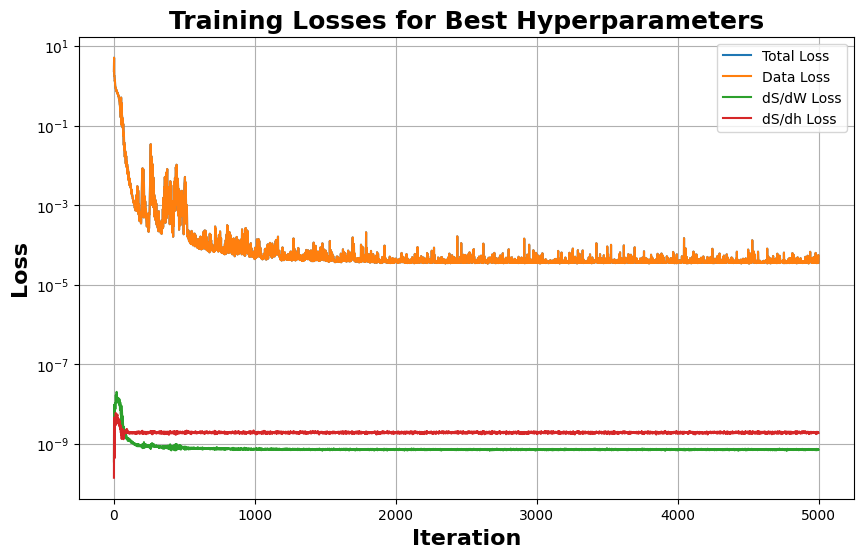

In [21]:
import jax
import jax.numpy as jnp
from flax import linen as nn
import optax
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import itertools
import math  # Import math module for static computations
import pandas as pd  # For results analysis (optional)

# Update JAX configuration
jax.config.update("jax_enable_x64", False)

# Set the random seed
base_seed = 42
key = jax.random.PRNGKey(base_seed)
np.random.seed(base_seed)

# Define the dictionary with constants for each material
constants_dict = {
    "Tuff/Rhyolite": {
        "h0": 122.0, "R0": 202.0, "gamma0": 26.0, "P10": 3.6e6, "P20": 5.0e6,
        "pv": 3500.0, "sv": 2021.0, "n": 2.4, "rho": 2000.0
    },
    "Granite": {
        "h0": 122.0, "R0": 321.0, "gamma0": 34.0, "P10": 4.6e6, "P20": 2.4e6,
        "pv": 5500.0, "sv": 3175.0, "n": 2.4, "rho": 2550.0
    },
    # Add other materials if needed
}

# Function to retrieve constants for a material
def get_constants(material_name):
    if material_name in constants_dict:
        material_constants = constants_dict[material_name]
        # Convert constants to JAX arrays with dtype float32
        return {key: jnp.array(value, dtype=jnp.float32) for key, value in material_constants.items()}
    else:
        raise ValueError(f"Material '{material_name}' not found in the constants dictionary.")

# Set the material and get constants
material = 'Tuff/Rhyolite'
constants = get_constants(material)

# Define the Neural Network class using Flax
class NeuralNet(nn.Module):
    input_dimension: int
    output_dimension: int
    n_hidden_layers: int
    neurons: int
    activation: callable
    regularization_param: float
    regularization_exp: float

    def setup(self):
        # Use LeCun uniform initializer for tanh activation
        kernel_init = nn.initializers.lecun_uniform()
        bias_init = nn.initializers.zeros

        # Layers
        self.input_layer = nn.Dense(
            self.neurons, kernel_init=kernel_init, bias_init=bias_init)
        self.hidden_layers = [
            nn.Dense(self.neurons, kernel_init=kernel_init, bias_init=bias_init)
            for _ in range(self.n_hidden_layers - 1)
        ]
        self.output_layer = nn.Dense(
            self.output_dimension, kernel_init=kernel_init, bias_init=bias_init)

    def __call__(self, x):
        x = self.activation(self.input_layer(x))
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        return self.output_layer(x)

    def l2_regularization(self):
        params = self.get_variable('params', 'kernel')
        reg_loss = 0.0
        for param in jax.tree_leaves(params):
            reg_loss += jnp.sum(jnp.abs(param) ** self.regularization_exp)
        return self.regularization_param * reg_loss

# Create the compute_stf_batch function with constants embedded
def make_compute_stf_batch(constants):
    h0 = constants['h0']
    R0 = constants['R0']
    gamma0 = constants['gamma0']
    P10 = constants['P10']
    P20 = constants['P20']
    pv = constants['pv']
    sv = constants['sv']
    n = constants['n']
    rho = constants['rho']

    def compute_stf_batch(w, h, t):
        mu = rho * sv ** 2
        lam = rho * pv ** 2 - 2 * mu

        # Compute R_el, gamma, beta, etc.
        h_ratio = h0 / h
        w_power = w ** (1 / 3)
        R_el = R0 * h_ratio ** (1 / n) * w_power
        gamma = gamma0 * (R0 / R_el)
        beta = (lam + 2 * mu) / (4 * mu)
        w0 = pv / R_el
        alpha = w0 / (2 * beta)
        sqrt_term = jnp.sqrt(1 / (2 * beta) - 1 / (4 * beta ** 2))
        p = w0 * sqrt_term

        exp_alpha_t = jnp.exp(-alpha * t)
        sin_p_t = jnp.sin(p * t)
        cos_p_t = jnp.cos(p * t)
        exp_gamma_t = jnp.exp(-gamma * t)
        H_t = jnp.where(t >= 0, 1.0, 0.0)

        # Compute f(t) and its derivative df/dt
        pv_squared = pv ** 2
        beta_p = beta * p
        f_prefactor = (R_el / (4 * alpha)) * (pv_squared / beta_p)
        f_t_val = f_prefactor * exp_alpha_t * sin_p_t * H_t

        A = (R_el / (4 * mu)) * (pv_squared / beta_p)
        df_dt = A * exp_alpha_t * (-alpha * sin_p_t + p * cos_p_t) * H_t

        # Compute B(t)
        P0_t = P10 * (h / h0)
        h_ratio_third = h_ratio ** (1 / 3)
        R_ratio_cubed = (R0 / R_el) ** 3
        P2_t = P20 * h_ratio_third * R_ratio_cubed * w ** 0.87
        B_t_val = (exp_gamma_t * P0_t + P2_t) * H_t

        df_dt_div = -df_dt / (R_el * pv)

        # Compute n_padded outside of JAX operations
        nt = t.shape[1]  # nt is known and static
        n_conv = 2 * nt - 1
        n_padded = 2 ** int(math.ceil(math.log2(n_conv)))

        # Define fft_convolve using n_padded
        def fft_convolve(a, b):
            A_f = jnp.fft.rfft(a, n=n_padded)
            B_f = jnp.fft.rfft(b, n=n_padded)
            C_f = A_f * B_f
            c = jnp.fft.irfft(C_f, n=n_padded)
            c = c[:n_conv]
            return c

        # FFT-based convolution
        S_t = jax.vmap(fft_convolve)(df_dt_div, B_t_val)
        S_t = S_t[:, nt - 1: 2 * nt - 1]

        # Analytical derivatives
        gamma_over_Rel = gamma / R_el
        n_over_Rel = n / R_el
        term1 = -exp_gamma_t * P10 * (h / h0) * (
            t * gamma_over_Rel - n_over_Rel * h_ratio ** (1 / n)
        ) * (h * w ** (-1 / 3)) ** (1 / 3)
        term3 = (1 - exp_gamma_t) * (
            (1 / 3) * n * R0 ** 2 / R_el ** 3 * h_ratio_third * w ** (-2 / 3) * (h * w ** (-1 / 3)) ** (1 / 3)
        )
        term4 = (1 - exp_gamma_t) * (
            -3 * R0 ** 3 / R_el ** 4 * h_ratio_third * (h * w ** (-1 / 3)) ** (1 / 3)
        )
        dB_t_dRel = (term1 + term3 + term4) * H_t

        dS_t_dRel = jax.vmap(fft_convolve)(df_dt_div, dB_t_dRel)
        dS_t_dRel = dS_t_dRel[:, nt - 1: 2 * nt - 1]

        # Derivatives of R_el
        dRel_dw = R_el / (3 * w)
        dRel_dh = -R_el / (n * h)

        dS_dW_ana = dS_t_dRel * dRel_dw
        dS_dh_ana = dS_t_dRel * dRel_dh

        return S_t, dS_dW_ana, dS_dh_ana

    # JIT-compile compute_stf_batch
    compute_stf_batch = jax.jit(compute_stf_batch)
    return compute_stf_batch

# Create the compute_stf_batch function with constants embedded
compute_stf_batch = make_compute_stf_batch(constants)

# Generate batch function without passing 'material'
def generate_batch(key, b, nt, hmin, hmax, wmin, wmax, tmin, tmax):
    key, subkey = jax.random.split(key)
    h = jax.random.uniform(subkey, shape=(b, 1), minval=hmin, maxval=hmax)
    key, subkey = jax.random.split(key)
    w = jax.random.uniform(subkey, shape=(b, 1), minval=wmin, maxval=wmax)
    t = jnp.linspace(tmin, tmax, nt)
    t = jnp.tile(t, (b, 1))  # Shape (b, nt)

    # Compute STF and derivatives
    S_t, dS_dW, dS_dh = compute_stf_batch(w, h, t)

    hnorm = (h / hmax).squeeze()        # Shape (b,)
    wnorm = (w / wmax).squeeze()        # Shape (b,)
    tnorm = t / tmax                    # Shape (b, nt)
    tnorm_flat = tnorm.flatten()        # Shape (b * nt,)

    # Prepare input x
    x = jnp.stack((
        tnorm_flat,                    # Shape (b * nt,)
        jnp.repeat(wnorm, nt),         # Shape (b * nt,)
        jnp.repeat(hnorm, nt)          # Shape (b * nt,)
    ), axis=-1)

    # Compute smax and smin
    smax = jnp.max(S_t, axis=1, keepdims=True)  # Shape (b, 1)
    smin = jnp.min(S_t, axis=1, keepdims=True)  # Shape (b, 1)

    # Repeat smax and smin along the time axis to match (b, nt)
    smax = jnp.tile(smax, (1, nt)).flatten()    # Shape (b * nt,)
    smin = jnp.tile(smin, (1, nt)).flatten()    # Shape (b * nt,)

    # Flatten S_t and derivatives
    S_t_flat = S_t.flatten()         # Shape (b * nt,)
    dS_dW_flat = dS_dW.flatten()     # Shape (b * nt,)
    dS_dh_flat = dS_dh.flatten()     # Shape (b * nt,)

    # Compute per-sample xmax and xmin
    xmax = jnp.max(x, axis=0, keepdims=True)  # Shape (1, 3)
    xmin = jnp.min(x, axis=0, keepdims=True)  # Shape (1, 3)

    # Prepare batch data
    batch = (
        x,                 # Shape (b * nt, 3)
        S_t_flat,          # Shape (b * nt,)
        smax,              # Shape (b * nt,)
        smin,              # Shape (b * nt,)
        xmax,              # Shape (1, 3)
        xmin,              # Shape (1, 3)
        dS_dW_flat,        # Shape (b * nt,)
        dS_dh_flat         # Shape (b * nt,)
    )

    return key, batch

# Training parameters
b = 512
nt = 128
tmax = 0.5
tmin = 0.0
n_iter = 5000  # Reduced for grid search

hmin = 150.0
hmax = 900.0
wmin = 1.0
wmax = 2.0

# Create the model
model = NeuralNet(
    input_dimension=3,
    output_dimension=1,
    n_hidden_layers=6,
    neurons=256,
    activation=nn.relu,
    regularization_param=0.5,
    regularization_exp=2.0,
)

# Initialize model parameters
key, subkey = jax.random.split(key)
dummy_input = jnp.ones((1, 3), dtype=jnp.float32)
params = model.init(subkey, dummy_input)


# Define optimizer with reduce_on_plateau scheduler
initial_learning_rate = 1e-3

# The reduce_on_plateau should come **after** the optimizer
optimizer = optax.chain(
    optax.adam(learning_rate=initial_learning_rate),
    optax.contrib.reduce_on_plateau(
        patience=100,
        cooldown=0,
        factor=0.5,
        rtol=0.0001
    ),
)

# Define the loss function
def loss_fn(params, batch, lam_d, lam_w, lam_h):
    x, S_t, smax, smin, xmax, xmin, dS_dW, dS_dh = batch
    # Forward pass
    s = model.apply(params, (x - xmin) / (xmax - xmin))
    s = s.squeeze() * (smax - smin) + smin

    # Data loss
    loss_d = lam_d * jnp.mean((s - S_t) ** 2)

    # Compute gradients w.r.t x
    def s_fn(x_i, smax_i, smin_i):
        x_i_norm = (x_i - xmin) / (xmax - xmin)
        s_i = model.apply(params, x_i_norm).squeeze() * (smax_i - smin_i) + smin_i
        return s_i

    # Vectorize gradient computation over all samples
    grad_s_x = jax.vmap(
        jax.grad(s_fn, argnums=0),
        in_axes=(0, 0, 0)
    )(x, smax, smin)

    # Extract gradients w.r.t wnorm and hnorm (x[:,1], x[:,2])
    grad_s_w = grad_s_x[:, 1]  # Gradient w.r.t wnorm
    grad_s_h = grad_s_x[:, 2]  # Gradient w.r.t hnorm

    # Derivative losses
    loss_sw = lam_w * jnp.mean((grad_s_w - dS_dW) ** 2)
    loss_sh = lam_h * jnp.mean((grad_s_h - dS_dh) ** 2)

    # Total loss
    total_loss = loss_d + loss_sw + loss_sh
    return total_loss, (loss_d, loss_sw, loss_sh)

@jax.jit
def train_step(params, opt_state, batch, lam_d, lam_w, lam_h):
    (loss, losses), grads = jax.value_and_grad(loss_fn, has_aux=True)(
        params, batch, lam_d, lam_w, lam_h
    )
    updates, opt_state = optimizer.update(
        grads,
        opt_state,
        params=params,
        value=loss,
        metrics={'loss': loss}  # Pass loss as a metric
    )
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss, losses



# Define the evaluation function
def evaluate_model(params):
    # Evaluation parameters
    b_eval = 10000  # Adjust as needed

    # Generate new h, w, t values for evaluation
    key_eval = jax.random.PRNGKey(base_seed + 1)
    key_eval, subkey = jax.random.split(key_eval)
    h = jax.random.uniform(subkey, shape=(b_eval, 1), minval=hmin, maxval=hmax)
    key_eval, subkey = jax.random.split(key_eval)
    w = jax.random.uniform(subkey, shape=(b_eval, 1), minval=wmin, maxval=wmax)
    t = jnp.linspace(tmin, tmax, nt)
    t = jnp.tile(t, (b_eval, 1))  # Shape (b_eval, nt)

    # Compute true S_t and analytical derivatives
    S_t, dS_dW_ana, dS_dh_ana = compute_stf_batch(w, h, t)

    # Normalize h, w, t
    hnorm = (h / hmax).squeeze()  # Shape (b_eval,)
    wnorm = (w / wmax).squeeze()  # Shape (b_eval,)
    tnorm = t / tmax              # Shape (b_eval, nt)

    # Flatten tnorm
    tnorm_flat = tnorm.flatten()  # Shape (b_eval * nt,)

    # Repeat hnorm and wnorm to match the time dimension
    hnorm_flat = jnp.repeat(hnorm, nt)  # Shape (b_eval * nt,)
    wnorm_flat = jnp.repeat(wnorm, nt)  # Shape (b_eval * nt,)

    # Prepare input x by stacking tnorm_flat, wnorm_flat, and hnorm_flat
    x = jnp.stack((tnorm_flat, wnorm_flat, hnorm_flat), axis=-1)  # Shape (b_eval * nt, 3)

    # Compute xmax and xmin over all data (consistent with training)
    xmax = jnp.max(x, axis=0, keepdims=True)  # Shape (1, 3)
    xmin = jnp.min(x, axis=0, keepdims=True)  # Shape (1, 3)

    # Normalize x
    x_normalized = (x - xmin) / (xmax - xmin)  # Shape (b_eval * nt, 3)

    # Compute smax and smin per sample
    smax = jnp.max(S_t, axis=1, keepdims=True)  # Shape (b_eval, 1)
    smin = jnp.min(S_t, axis=1, keepdims=True)  # Shape (b_eval, 1)

    # Repeat smax and smin along the time dimension to match (b_eval, nt)
    smax = jnp.tile(smax, (1, nt)).flatten()  # Shape (b_eval * nt,)
    smin = jnp.tile(smin, (1, nt)).flatten()  # Shape (b_eval * nt,)

    # Evaluate the model
    s_pred = model.apply(params, x_normalized).squeeze()  # Shape (b_eval * nt,)

    # Apply inverse normalization to s_pred
    s_pred = s_pred * (smax - smin) + smin  # Shape (b_eval * nt,)

    # Reshape s_pred and S_t to (b_eval, nt) for comparison
    s_pred = s_pred.reshape(b_eval, nt)  # Shape (b_eval, nt)
    S_t = S_t.reshape(b_eval, nt)        # Shape (b_eval, nt)

    # Compute MSE over time steps for each sample
    mse = jnp.mean((S_t - s_pred) ** 2, axis=1)  # Shape (b_eval,)

    return np.array(mse)

# Define hyperparameter grids
lam_w_values = [1e-10, 1e-5, 1e-4, 1e-3]
lam_h_values = [1e-10, 1e-5, 1e-4, 1e-3]
lam_d_values = [1e-10, 1e-2, 1e-1, 1e-0]

# Prepare to store results
results = []

# Total number of combinations
total_combinations = len(lam_w_values) * len(lam_h_values) * len(lam_d_values)

# Iterate over all combinations
for lam_d, lam_w, lam_h in tqdm(itertools.product(lam_d_values, lam_w_values, lam_h_values), total=total_combinations):
    # Skip combinations where all lambdas are zero to avoid zero loss
    if lam_d == 0 and lam_w == 0 and lam_h == 0:
        continue

    print(f"Training with lam_d={lam_d}, lam_w={lam_w}, lam_h={lam_h}")

    # Reset the model and optimizer for each run
    key = jax.random.PRNGKey(base_seed)
    key, subkey = jax.random.split(key)
    params = model.init(subkey, dummy_input)
    opt_state = optimizer.init(params)

    # Update hyperparameters
    current_lam_d = lam_d
    current_lam_w = lam_w
    current_lam_h = lam_h

    # Training loop
    losses = []
    loss_d_list = []
    loss_sw_list = []
    loss_sh_list = []
    learning_rates = []

    # Training loop
    for step in range(n_iter):
        # Generate batch data
        key, batch = generate_batch(key, b, nt, hmin, hmax, wmin, wmax, tmin, tmax)

        # Perform a training step with current hyperparameters
        params, opt_state, loss, (loss_d, loss_sw, loss_sh) = train_step(
            params, opt_state, batch, lam_d, lam_w, lam_h
        )
        losses.append(float(loss))
        loss_d_list.append(float(loss_d))
        loss_sw_list.append(float(loss_sw))
        loss_sh_list.append(float(loss_sh))

    # Evaluate the model
    mse_np = evaluate_model(params)
    final_mse = np.mean(mse_np)

    # Store the results
    results.append({
        'lam_d': current_lam_d,
        'lam_w': current_lam_w,
        'lam_h': current_lam_h,
        'final_loss': float(loss),
        'final_mse': final_mse,
        'losses': losses,
        'loss_d_list': loss_d_list,
        'loss_sw_list': loss_sw_list,
        'loss_sh_list': loss_sh_list
    })

    print(f"Final MSE: {final_mse}")

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results)

# Sort by final_mse
sorted_results = results_df.sort_values(by='final_mse')

# Display top 5 results
print(sorted_results[['lam_d', 'lam_w', 'lam_h', 'final_mse']].head())

# Plotting results for the best hyperparameter combination
best_result = sorted_results.iloc[0]
best_params = {
    'lam_d': best_result['lam_d'],
    'lam_w': best_result['lam_w'],
    'lam_h': best_result['lam_h']
}

print(f"Best Hyperparameters: {best_params}")

# If you want to plot the losses for the best model
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(best_result['losses'], label='Total Loss')
plt.plot(best_result['loss_d_list'], label='Data Loss')
plt.plot(best_result['loss_sw_list'], label='dS/dW Loss')
plt.plot(best_result['loss_sh_list'], label='dS/dh Loss')
plt.yscale('log')
plt.xlabel('Iteration', fontsize=16, fontweight='bold')
plt.ylabel('Loss', fontsize=16, fontweight='bold')
plt.legend()
plt.title('Training Losses for Best Hyperparameters', fontsize=18, fontweight='bold')
plt.show()


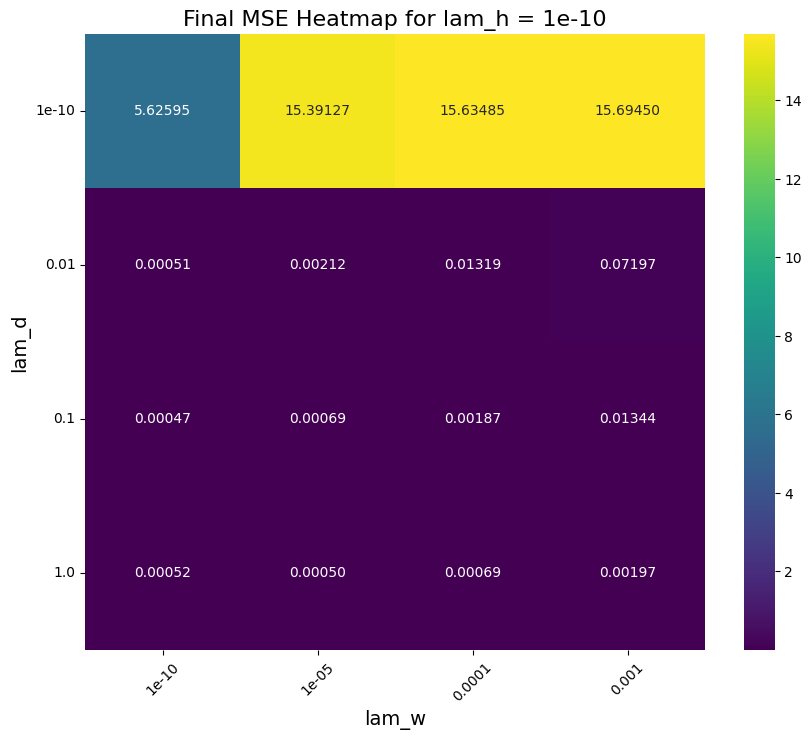

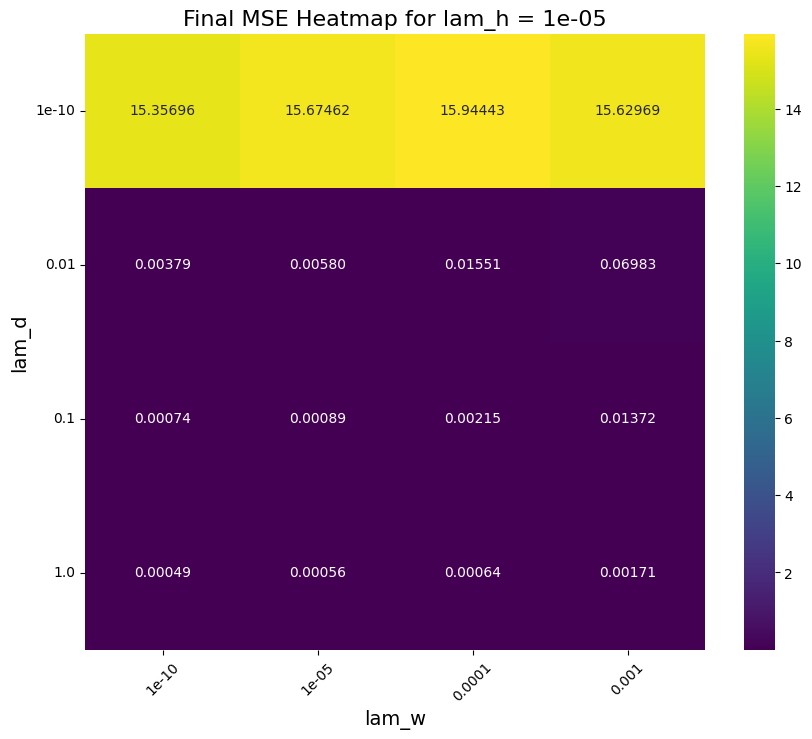

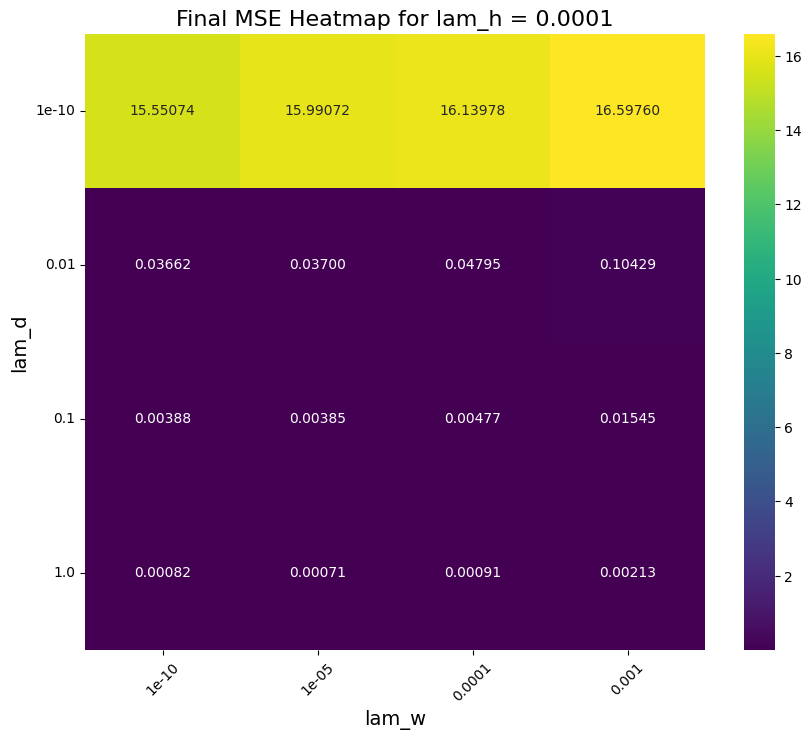

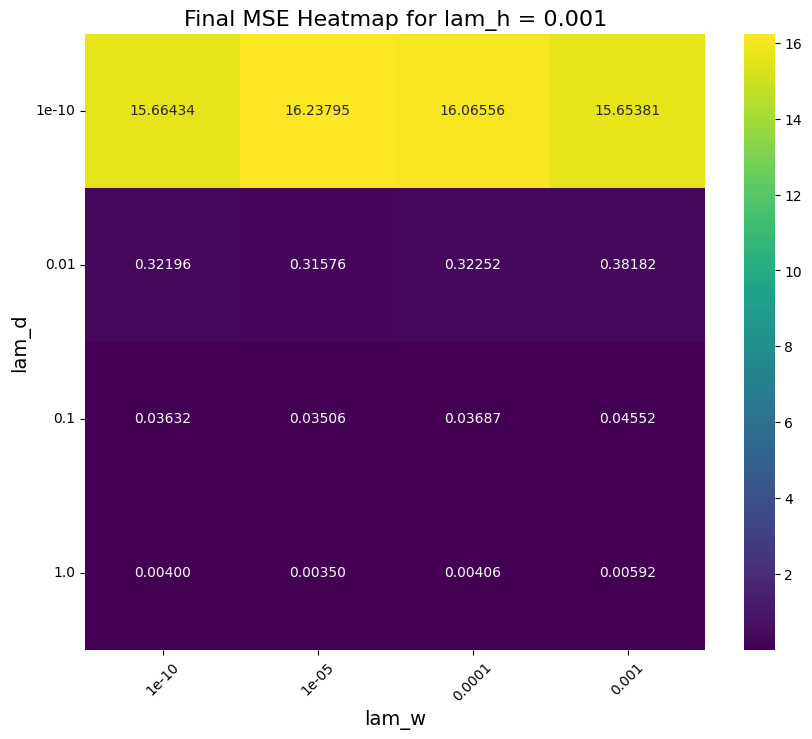

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get unique values of lam_h
lam_h_values = sorted(results_df['lam_h'].unique())

for lam_h in lam_h_values:
    df_subset = results_df[results_df['lam_h'] == lam_h]
    pivot_table = df_subset.pivot(index='lam_d', columns='lam_w', values='final_mse')
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_table, annot=True, fmt=".5f", cmap='viridis')
    plt.title(f'Final MSE Heatmap for lam_h = {lam_h}', fontsize=16)
    plt.ylabel('lam_d', fontsize=14)
    plt.xlabel('lam_w', fontsize=14)
    plt.yticks(rotation=0)
    plt.xticks(rotation=45)
    plt.show()


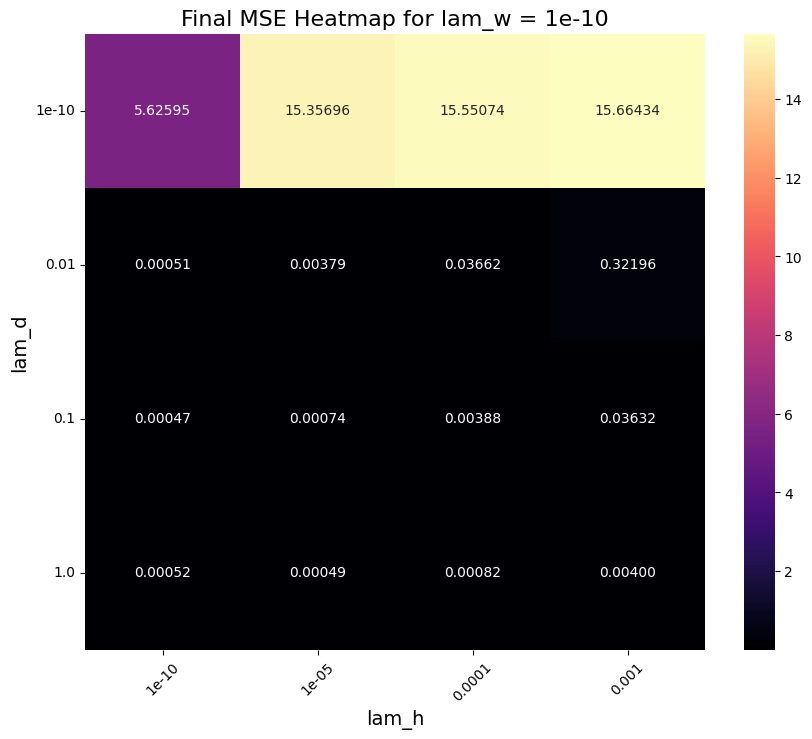

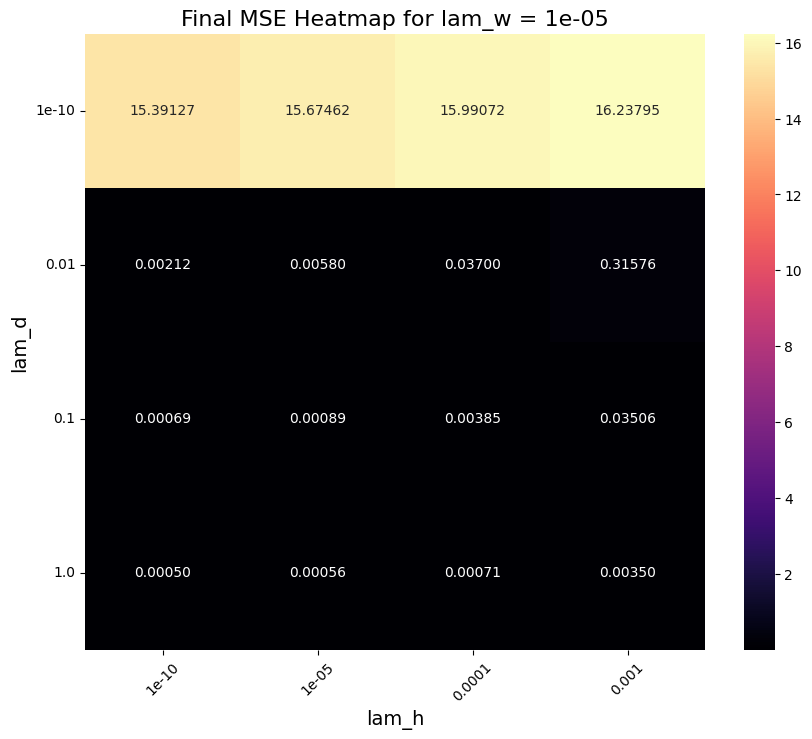

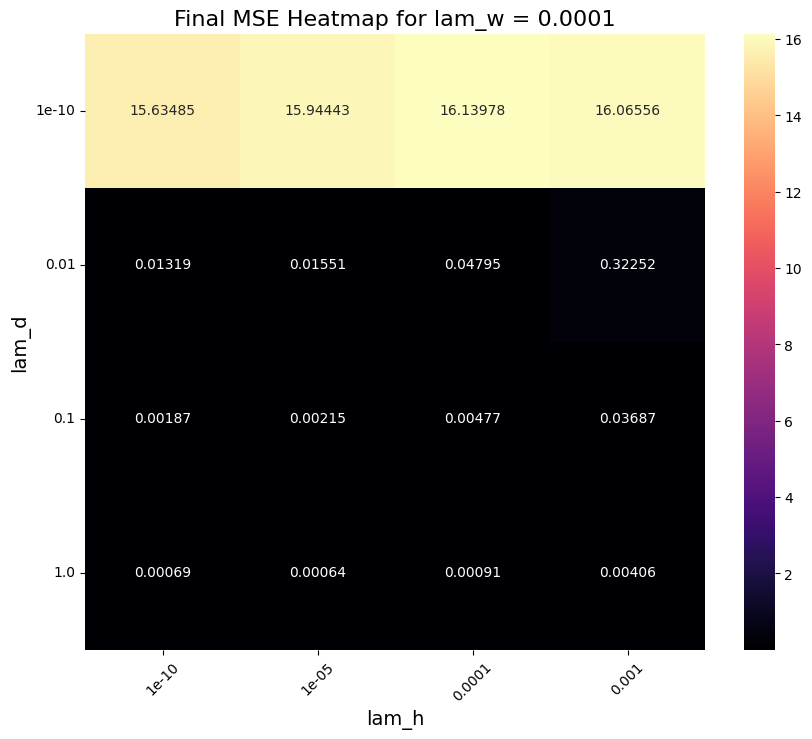

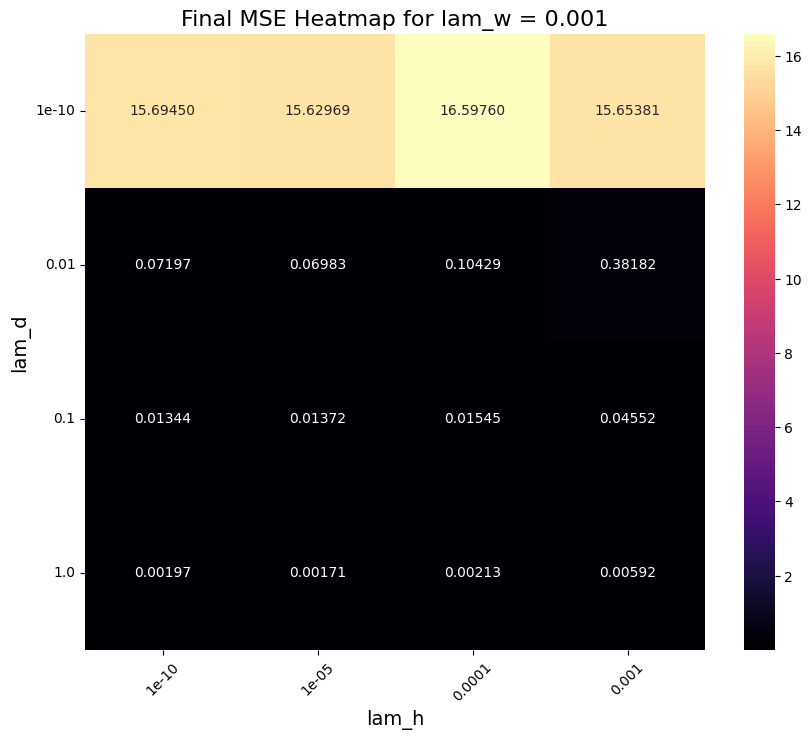

In [23]:
# Get unique values of lam_w
lam_w_values = sorted(results_df['lam_w'].unique())

for lam_w in lam_w_values:
    df_subset = results_df[results_df['lam_w'] == lam_w]
    pivot_table = df_subset.pivot(index='lam_d', columns='lam_h', values='final_mse')
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_table, annot=True, fmt=".5f", cmap='magma')
    plt.title(f'Final MSE Heatmap for lam_w = {lam_w}', fontsize=16)
    plt.ylabel('lam_d', fontsize=14)
    plt.xlabel('lam_h', fontsize=14)
    plt.yticks(rotation=0)
    plt.xticks(rotation=45)
    plt.show()


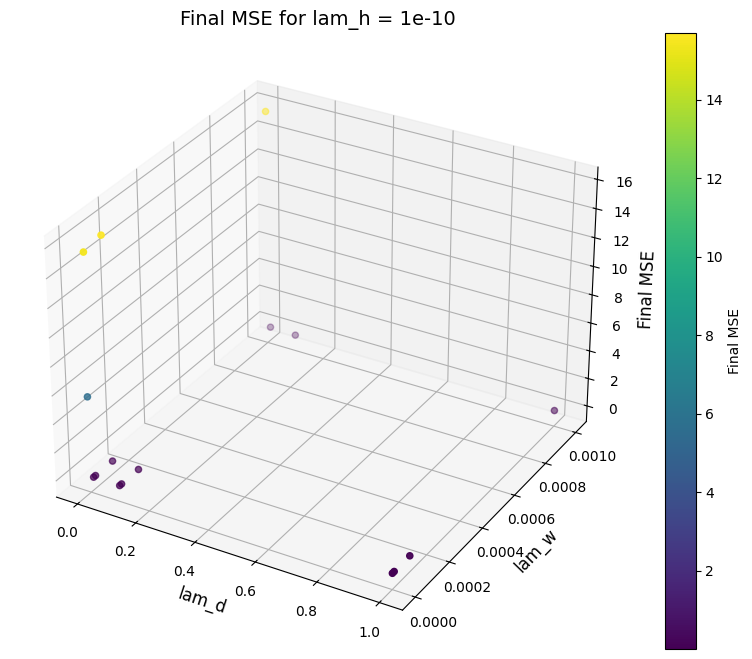

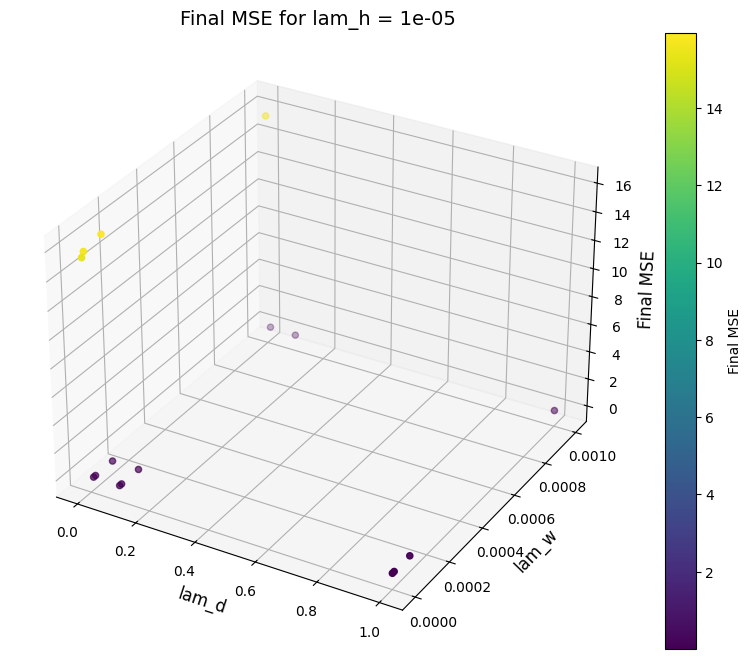

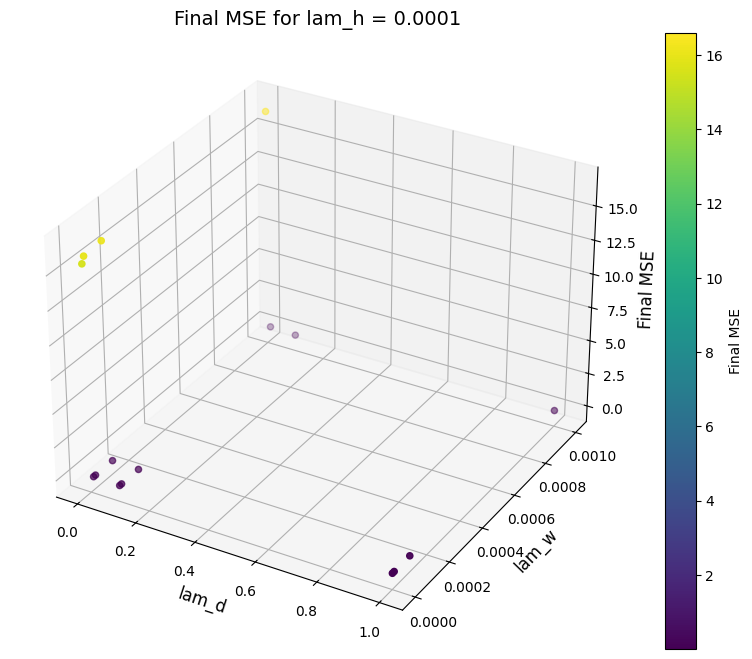

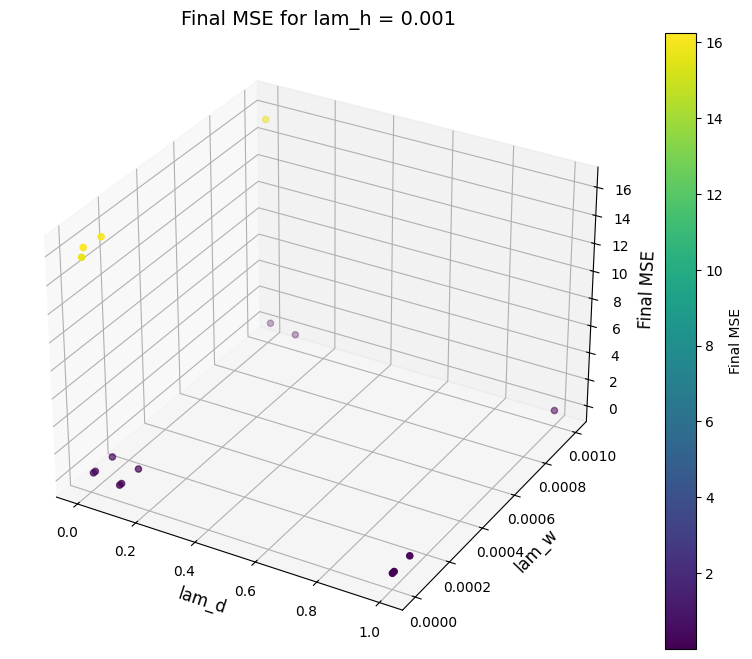

In [24]:
from mpl_toolkits.mplot3d import Axes3D

# For each lam_h value, create a 3D scatter plot
for lam_h in lam_h_values:
    df_subset = results_df[results_df['lam_h'] == lam_h]
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(
        df_subset['lam_d'],
        df_subset['lam_w'],
        df_subset['final_mse'],
        c=df_subset['final_mse'],
        cmap='viridis',
        depthshade=True
    )
    ax.set_xlabel('lam_d', fontsize=12)
    ax.set_ylabel('lam_w', fontsize=12)
    ax.set_zlabel('Final MSE', fontsize=12)
    ax.set_title(f'Final MSE for lam_h = {lam_h}', fontsize=14)
    fig.colorbar(sc, ax=ax, label='Final MSE')
    plt.show()


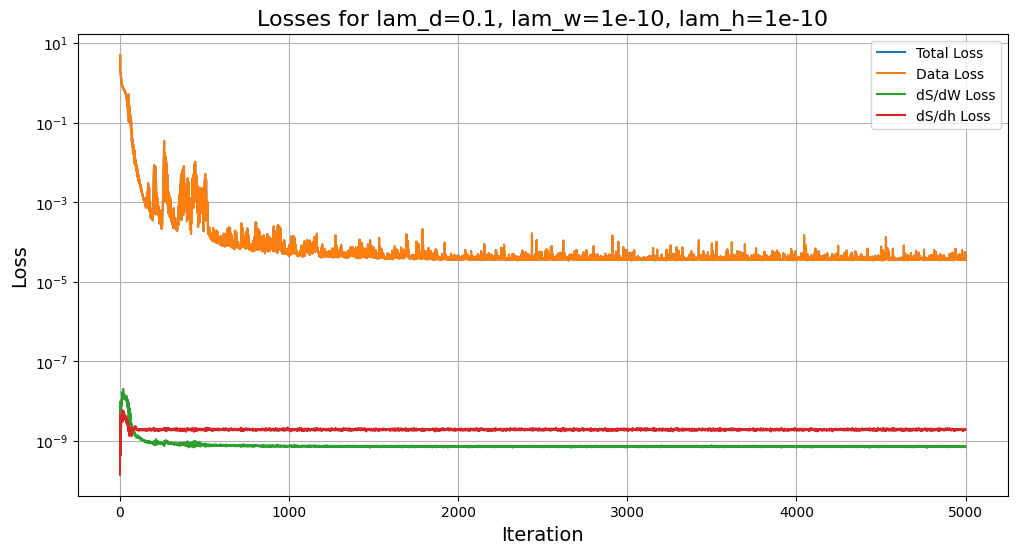

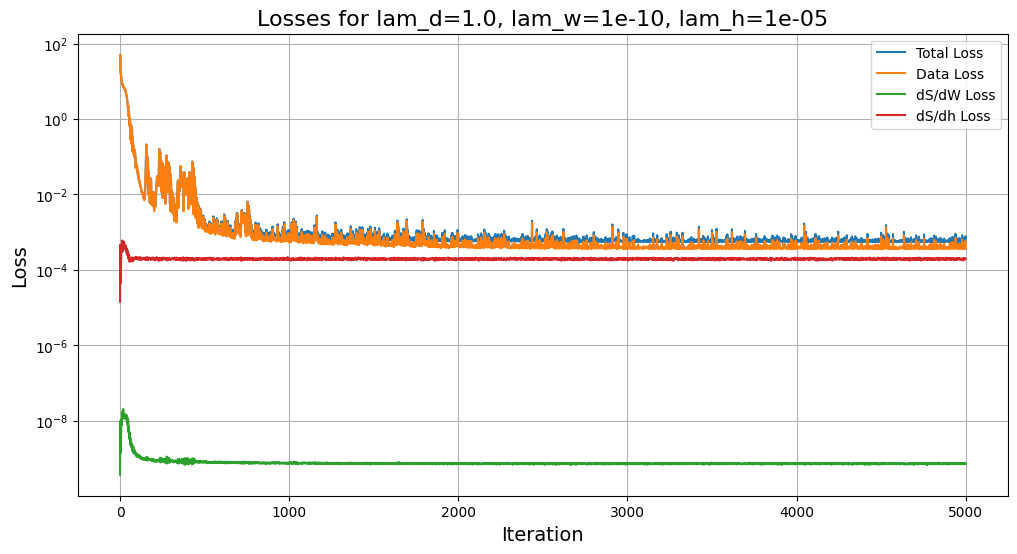

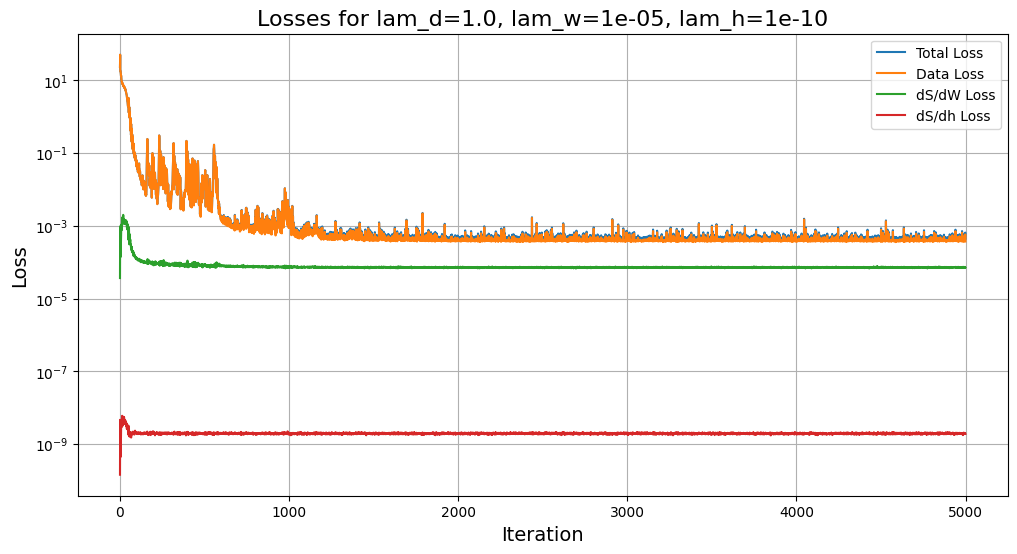

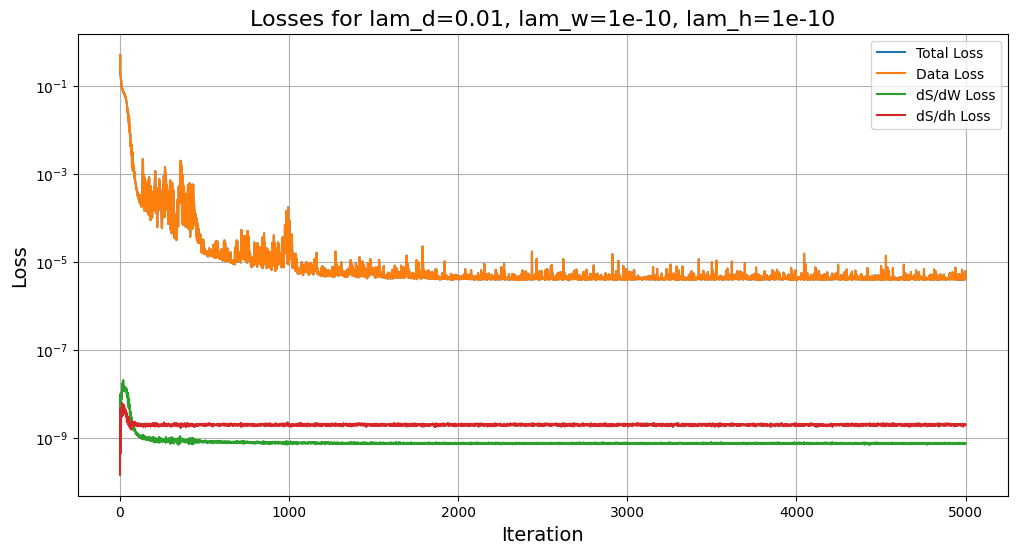

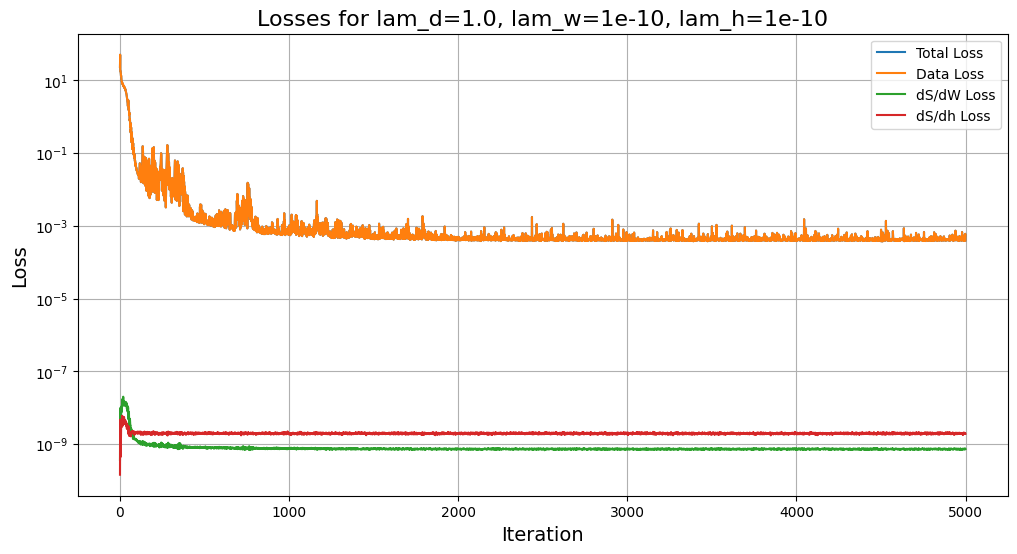

In [25]:
# Get the top 5 hyperparameter combinations with lowest final_mse
top_n = 5
top_results = results_df.nsmallest(top_n, 'final_mse').reset_index(drop=True)

for idx, row in top_results.iterrows():
    plt.figure(figsize=(12, 6))
    plt.plot(row['losses'], label='Total Loss')
    plt.plot(row['loss_d_list'], label='Data Loss')
    plt.plot(row['loss_sw_list'], label='dS/dW Loss')
    plt.plot(row['loss_sh_list'], label='dS/dh Loss')
    plt.yscale('log')
    plt.xlabel('Iteration', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.title(f'Losses for lam_d={row["lam_d"]}, lam_w={row["lam_w"]}, lam_h={row["lam_h"]}', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()


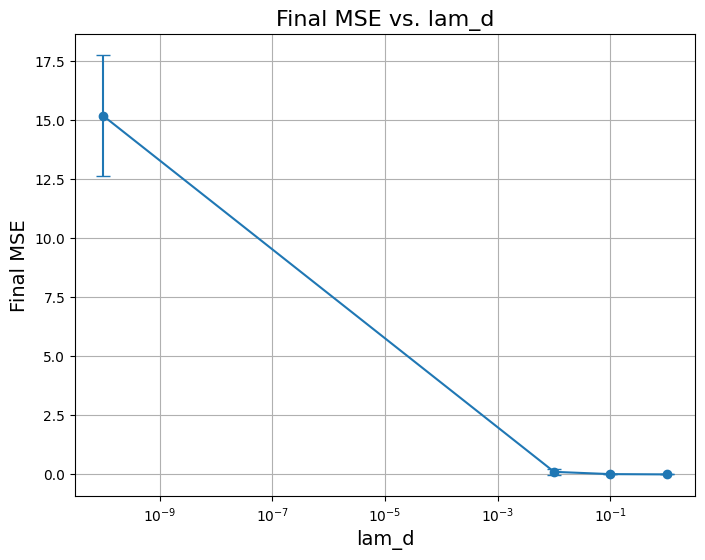

In [26]:
# Group by lam_d and compute mean and std of final_mse
grouped_lam_d = results_df.groupby('lam_d')['final_mse'].agg(['mean', 'std']).reset_index()

plt.figure(figsize=(8, 6))
plt.errorbar(
    grouped_lam_d['lam_d'],
    grouped_lam_d['mean'],
    yerr=grouped_lam_d['std'],
    fmt='o-',
    capsize=5
)
plt.xscale('log')
plt.xlabel('lam_d', fontsize=14)
plt.ylabel('Final MSE', fontsize=14)
plt.title('Final MSE vs. lam_d', fontsize=16)
plt.grid(True)
plt.show()


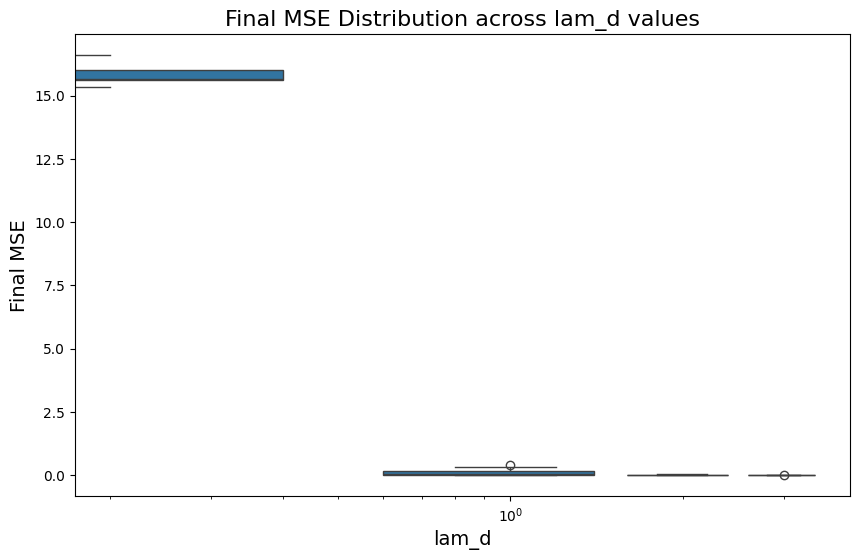

In [27]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='lam_d', y='final_mse', data=results_df)
plt.xscale('log')
plt.xlabel('lam_d', fontsize=14)
plt.ylabel('Final MSE', fontsize=14)
plt.title('Final MSE Distribution across lam_d values', fontsize=16)
plt.show()


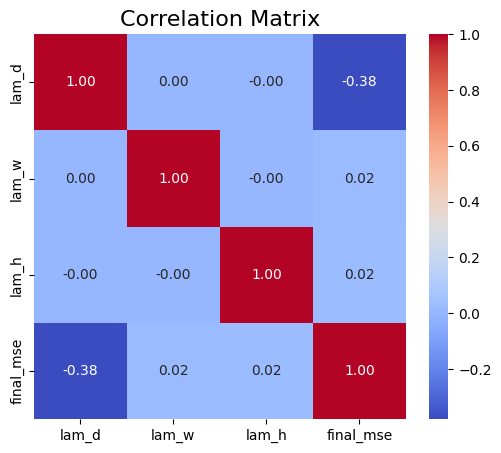

In [28]:
# Compute correlation matrix
corr_matrix = results_df[['lam_d', 'lam_w', 'lam_h', 'final_mse']].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix', fontsize=16)
plt.show()


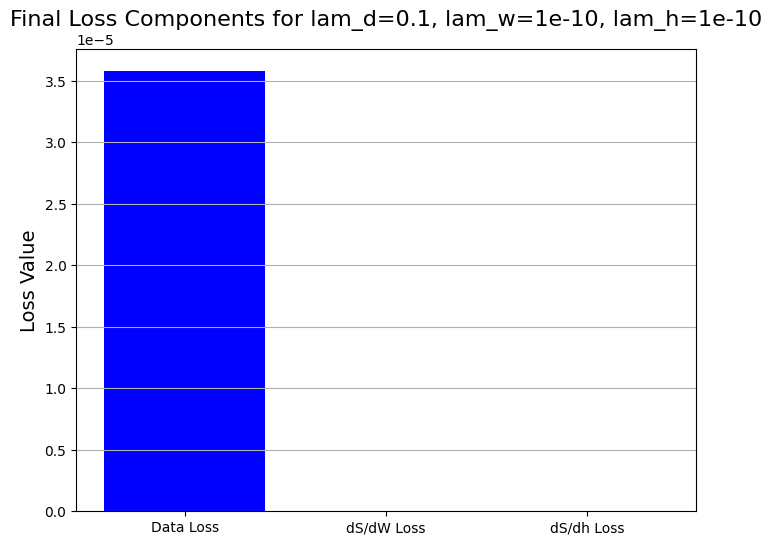

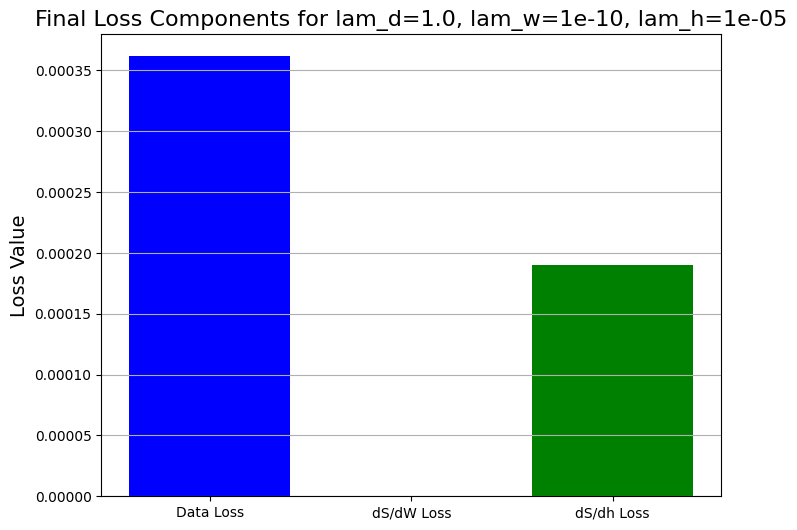

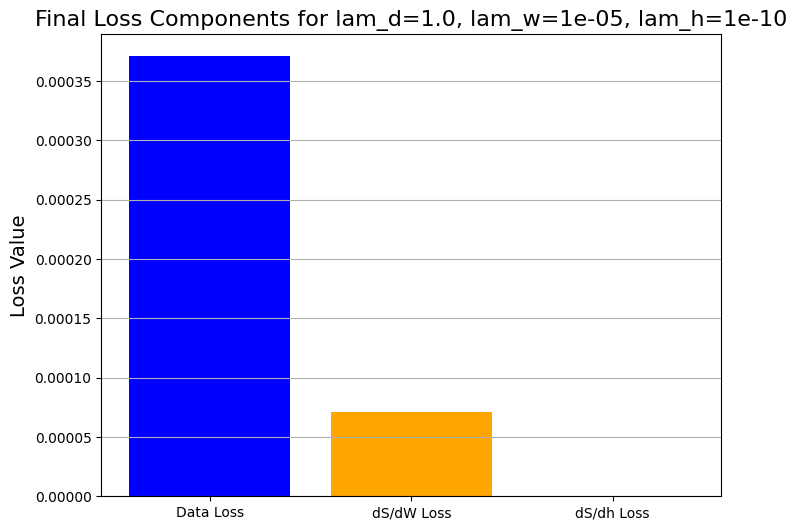

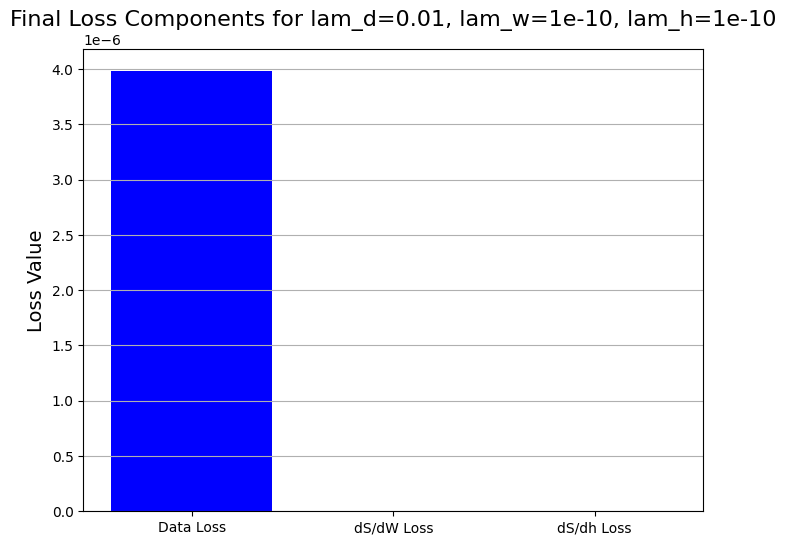

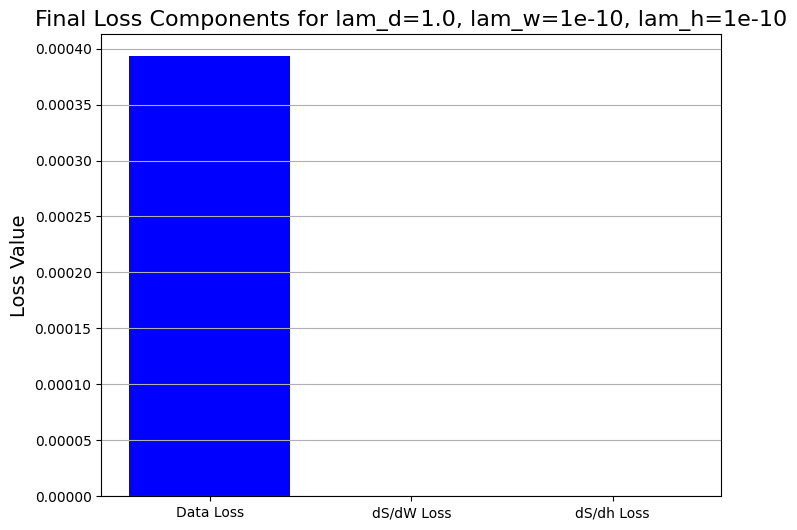

In [29]:
for idx, row in top_results.iterrows():
    final_loss_d = row['loss_d_list'][-1]
    final_loss_sw = row['loss_sw_list'][-1]
    final_loss_sh = row['loss_sh_list'][-1]
    components = ['Data Loss', 'dS/dW Loss', 'dS/dh Loss']
    values = [final_loss_d, final_loss_sw, final_loss_sh]
    
    plt.figure(figsize=(8, 6))
    plt.bar(components, values, color=['blue', 'orange', 'green'])
    plt.title(f'Final Loss Components for lam_d={row["lam_d"]}, lam_w={row["lam_w"]}, lam_h={row["lam_h"]}', fontsize=16)
    plt.ylabel('Loss Value', fontsize=14)
    plt.grid(axis='y')
    plt.show()


In [30]:
mean_mse = results_df['final_mse'].mean()
std_mse = results_df['final_mse'].std()
min_mse = results_df['final_mse'].min()
max_mse = results_df['final_mse'].max()

print(f'Mean Final MSE: {mean_mse:.5f}')
print(f'Std of Final MSE: {std_mse:.5f}')
print(f'Min Final MSE: {min_mse:.5f}')
print(f'Max Final MSE: {max_mse:.5f}')


Mean Final MSE: 3.82575
Std of Final MSE: 6.72451
Min Final MSE: 0.00047
Max Final MSE: 16.59760


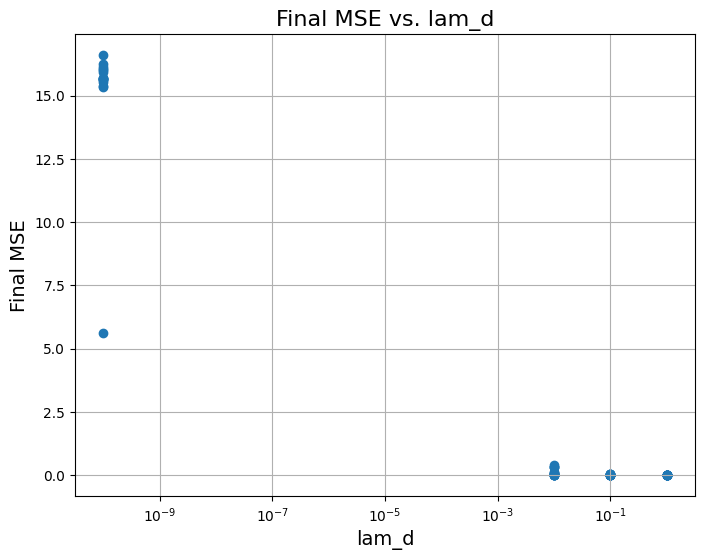

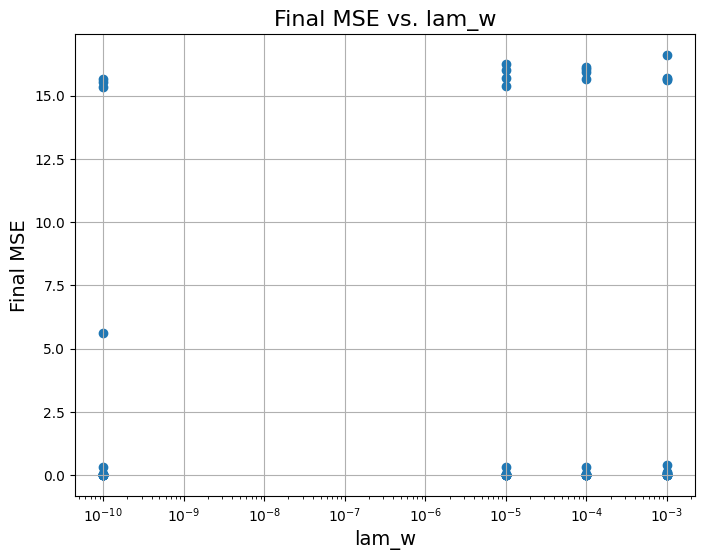

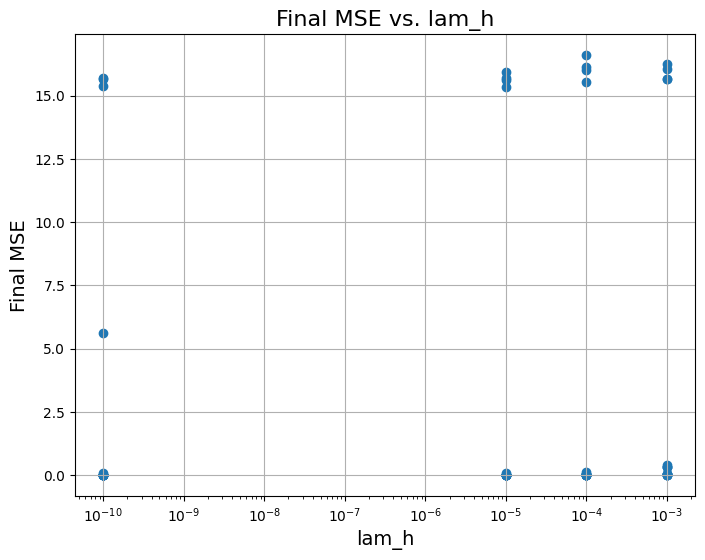

In [31]:
plt.figure(figsize=(8, 6))
plt.scatter(results_df['lam_d'], results_df['final_mse'])
plt.xscale('log')
plt.xlabel('lam_d', fontsize=14)
plt.ylabel('Final MSE', fontsize=14)
plt.title('Final MSE vs. lam_d', fontsize=16)
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(results_df['lam_w'], results_df['final_mse'])
plt.xscale('log')
plt.xlabel('lam_w', fontsize=14)
plt.ylabel('Final MSE', fontsize=14)
plt.title('Final MSE vs. lam_w', fontsize=16)
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(results_df['lam_h'], results_df['final_mse'])
plt.xscale('log')
plt.xlabel('lam_h', fontsize=14)
plt.ylabel('Final MSE', fontsize=14)
plt.title('Final MSE vs. lam_h', fontsize=16)
plt.grid(True)
plt.show()


In [32]:
# Display top 10 hyperparameter combinations with lowest final_mse
top_10 = results_df.nsmallest(10, 'final_mse').reset_index(drop=True)
print(top_10[['lam_d', 'lam_w', 'lam_h', 'final_mse']])


   lam_d         lam_w         lam_h  final_mse
0   0.10  1.000000e-10  1.000000e-10   0.000472
1   1.00  1.000000e-10  1.000000e-05   0.000485
2   1.00  1.000000e-05  1.000000e-10   0.000501
3   0.01  1.000000e-10  1.000000e-10   0.000512
4   1.00  1.000000e-10  1.000000e-10   0.000524
5   1.00  1.000000e-05  1.000000e-05   0.000563
6   1.00  1.000000e-04  1.000000e-05   0.000644
7   0.10  1.000000e-05  1.000000e-10   0.000692
8   1.00  1.000000e-04  1.000000e-10   0.000695
9   1.00  1.000000e-05  1.000000e-04   0.000710


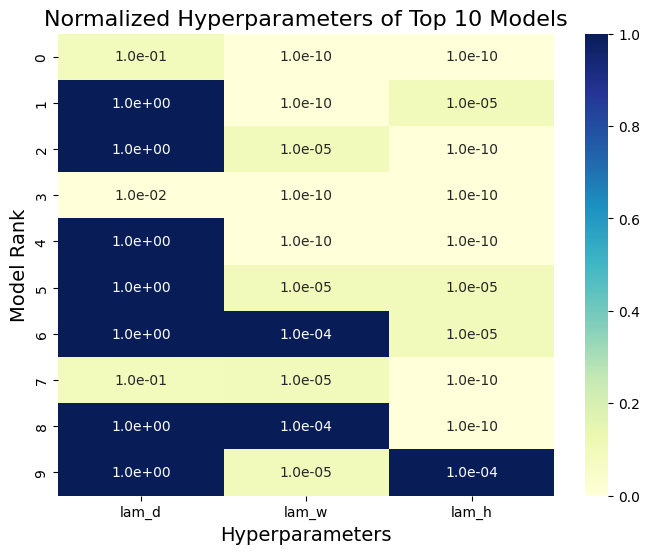

In [33]:
# Create a DataFrame of hyperparameters for top models
top_hyperparams = top_10[['lam_d', 'lam_w', 'lam_h']]

# Normalize hyperparameter values for heatmap
top_hyperparams_norm = (top_hyperparams - top_hyperparams.min()) / (top_hyperparams.max() - top_hyperparams.min())

plt.figure(figsize=(8, 6))
sns.heatmap(top_hyperparams_norm, annot=top_hyperparams, fmt=".1e", cmap='YlGnBu')
plt.title('Normalized Hyperparameters of Top 10 Models', fontsize=16)
plt.xlabel('Hyperparameters', fontsize=14)
plt.ylabel('Model Rank', fontsize=14)
plt.show()


In [34]:
# Save results_df to a CSV file
results_df.to_csv('hyperparameter_search_results.csv', index=False)


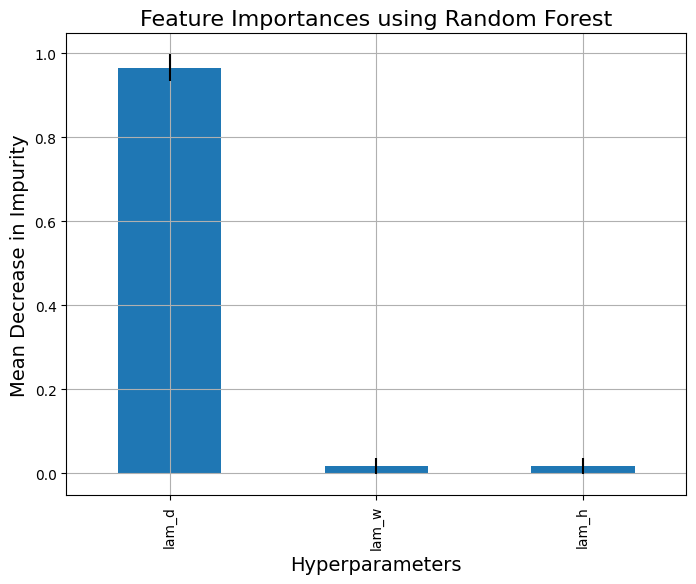

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

# Prepare data
X = results_df[['lam_d', 'lam_w', 'lam_h']]
y = results_df['final_mse']

# Fit a Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Compute feature importances
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
feature_names = ['lam_d', 'lam_w', 'lam_h']

# Plot feature importances
forest_importances = pd.Series(importances, index=feature_names)

plt.figure(figsize=(8, 6))
forest_importances.plot.bar(yerr=std)
plt.title('Feature Importances using Random Forest', fontsize=16)
plt.ylabel('Mean Decrease in Impurity', fontsize=14)
plt.xlabel('Hyperparameters', fontsize=14)
plt.grid(True)
plt.show()


## Dev version

In [2]:
import jax
import jax.numpy as jnp
from flax import linen as nn
import optax
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import math  # Import math module for static computations

# Update JAX configuration
jax.config.update("jax_enable_x64", False)

# Set the random seed
base_seed = 42
key = jax.random.PRNGKey(base_seed)
np.random.seed(base_seed)

# Define the dictionary with constants for each material
constants_dict = {
    "Tuff/Rhyolite": {
        "h0": 122.0, "R0": 202.0, "gamma0": 26.0, "P10": 3.6e6, "P20": 5.0e6,
        "pv": 3500.0, "sv": 2021.0, "n": 2.4, "rho": 2000.0
    },
    # Add other materials if needed
}

# Function to retrieve constants for a material
def get_constants(material_name):
    if material_name in constants_dict:
        material_constants = constants_dict[material_name]
        # Convert constants to JAX arrays with dtype float32
        return {key: jnp.array(value, dtype=jnp.float32) for key, value in material_constants.items()}
    else:
        raise ValueError(f"Material '{material_name}' not found in the constants dictionary.")

# Set the material and get constants
material = 'Tuff/Rhyolite'
constants = get_constants(material)

# Define the Neural Network class using Flax
class NeuralNet(nn.Module):
    # [Your NeuralNet definition remains the same]
    input_dimension: int
    output_dimension: int
    n_hidden_layers: int
    neurons: int
    activation: callable
    regularization_param: float
    regularization_exp: float

    def setup(self):
        # Use LeCun uniform initializer for tanh activation
        kernel_init = nn.initializers.lecun_uniform()
        bias_init = nn.initializers.zeros

        # Layers
        self.input_layer = nn.Dense(
            self.neurons, kernel_init=kernel_init, bias_init=bias_init)
        self.hidden_layers = [
            nn.Dense(self.neurons, kernel_init=kernel_init, bias_init=bias_init)
            for _ in range(self.n_hidden_layers - 1)
        ]
        self.output_layer = nn.Dense(
            self.output_dimension, kernel_init=kernel_init, bias_init=bias_init)

    def __call__(self, x):
        x = self.activation(self.input_layer(x))
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        return self.output_layer(x)

    def l2_regularization(self):
        params = self.get_variable('params', 'kernel')
        reg_loss = 0.0
        for param in jax.tree_leaves(params):
            reg_loss += jnp.sum(jnp.abs(param) ** self.regularization_exp)
        return self.regularization_param * reg_loss

# Create the compute_stf_batch function with constants embedded
def make_compute_stf_batch(constants):
    h0 = constants['h0']
    R0 = constants['R0']
    gamma0 = constants['gamma0']
    P10 = constants['P10']
    P20 = constants['P20']
    pv = constants['pv']
    sv = constants['sv']
    n = constants['n']
    rho = constants['rho']

    def compute_stf_batch(w, h, t):
        mu = rho * sv ** 2
        lam = rho * pv ** 2 - 2 * mu

        # Compute R_el, gamma, beta, etc.
        h_ratio = h0 / h
        w_power = w ** (1 / 3)
        R_el = R0 * h_ratio ** (1 / n) * w_power
        gamma = gamma0 * (R0 / R_el)
        beta = (lam + 2 * mu) / (4 * mu)
        w0 = pv / R_el
        alpha = w0 / (2 * beta)
        sqrt_term = jnp.sqrt(1 / (2 * beta) - 1 / (4 * beta ** 2))
        p = w0 * sqrt_term

        exp_alpha_t = jnp.exp(-alpha * t)
        sin_p_t = jnp.sin(p * t)
        cos_p_t = jnp.cos(p * t)
        exp_gamma_t = jnp.exp(-gamma * t)
        H_t = jnp.where(t >= 0, 1.0, 0.0)

        # Compute f(t) and its derivative df/dt
        pv_squared = pv ** 2
        beta_p = beta * p
        f_prefactor = (R_el / (4 * alpha)) * (pv_squared / beta_p)
        f_t_val = f_prefactor * exp_alpha_t * sin_p_t * H_t

        A = (R_el / (4 * mu)) * (pv_squared / beta_p)
        df_dt = A * exp_alpha_t * (-alpha * sin_p_t + p * cos_p_t) * H_t

        # Compute B(t)
        P0_t = P10 * (h / h0)
        h_ratio_third = h_ratio ** (1 / 3)
        R_ratio_cubed = (R0 / R_el) ** 3
        P2_t = P20 * h_ratio_third * R_ratio_cubed * w ** 0.87
        B_t_val = (exp_gamma_t * P0_t + P2_t) * H_t

        df_dt_div = -df_dt / (R_el * pv)

        # Compute n_padded outside of JAX operations
        nt = t.shape[1]  # nt is known and static
        n0 = 2 * nt - 1
        n_padded = 2 ** int(math.ceil(math.log2(n0)))

        # Define fft_convolve using n_padded
        def fft_convolve(a, b):
            A_f = jnp.fft.rfft(a, n=n_padded)
            B_f = jnp.fft.rfft(b, n=n_padded)
            C_f = A_f * B_f
            c = jnp.fft.irfft(C_f, n=n_padded)
            c = c[:n]
            return c

        # FFT-based convolution
        S_t = jax.vmap(fft_convolve)(df_dt_div, B_t_val)
        S_t = S_t[:, nt - 1: 2 * nt - 1]

        # Analytical derivatives
        gamma_over_Rel = gamma / R_el
        n_over_Rel = n / R_el
        term1 = -exp_gamma_t * P10 * (h / h0) * (
            t * gamma_over_Rel - n_over_Rel * h_ratio ** (1 / n)
        ) * (h * w ** (-1 / 3)) ** (1 / 3)
        term3 = (1 - exp_gamma_t) * (
            (1 / 3) * n * R0 ** 2 / R_el ** 3 * h_ratio_third * w ** (-2 / 3) * (h * w ** (-1 / 3)) ** (1 / 3)
        )
        term4 = (1 - exp_gamma_t) * (
            -3 * R0 ** 3 / R_el ** 4 * h_ratio_third * (h * w ** (-1 / 3)) ** (1 / 3)
        )
        dB_t_dRel = (term1 + term3 + term4) * H_t

        dS_t_dRel = jax.vmap(fft_convolve)(df_dt_div, dB_t_dRel)
        dS_t_dRel = dS_t_dRel[:, nt - 1: 2 * nt - 1]

        # Derivatives of R_el
        dRel_dw = R_el / (3 * w)
        dRel_dh = -R_el / (n * h)

        dS_dW_ana = dS_t_dRel * dRel_dw
        dS_dh_ana = dS_t_dRel * dRel_dh

        return S_t, dS_dW_ana, dS_dh_ana

    # JIT-compile compute_stf_batch
    compute_stf_batch = jax.jit(compute_stf_batch)
    return compute_stf_batch

compute_stf_batch = make_compute_stf_batch(constants)

# Generate batch function without passing 'material'
def generate_batch(key, b, nt, hmin, hmax, wmin, wmax, tmin, tmax):
    key, subkey = jax.random.split(key)
    h = jax.random.uniform(subkey, shape=(b, 1), minval=hmin, maxval=hmax)
    key, subkey = jax.random.split(key)
    w = jax.random.uniform(subkey, shape=(b, 1), minval=wmin, maxval=wmax)
    t = jnp.linspace(tmin, tmax, nt)
    t = jnp.tile(t, (b, 1))  # Shape (b, nt)

    # Compute STF and derivatives
    S_t, dS_dW, dS_dh = compute_stf_batch(w, h, t)

    hnorm = (h / hmax).squeeze()        # Shape (b,)
    wnorm = (w / wmax).squeeze()        # Shape (b,)
    tnorm = t / tmax                    # Shape (b, nt)
    tnorm_flat = tnorm.flatten()        # Shape (b * nt,)

    # Prepare input x
    x = jnp.stack((
        tnorm_flat,                    # Shape (b * nt,)
        jnp.repeat(wnorm, nt),         # Shape (b * nt,)
        jnp.repeat(hnorm, nt)          # Shape (b * nt,)
    ), axis=-1)

    # Compute smax and smin
    smax = jnp.max(S_t, axis=1, keepdims=True)  # Shape (b, 1)
    smin = jnp.min(S_t, axis=1, keepdims=True)  # Shape (b, 1)

    # Repeat smax and smin along the time axis to match (b, nt)
    smax = jnp.tile(smax, (1, nt)).flatten()    # Shape (b * nt,)
    smin = jnp.tile(smin, (1, nt)).flatten()    # Shape (b * nt,)

    # Flatten S_t and derivatives
    S_t_flat = S_t.flatten()         # Shape (b * nt,)
    dS_dW_flat = dS_dW.flatten()     # Shape (b * nt,)
    dS_dh_flat = dS_dh.flatten()     # Shape (b * nt,)

    # Compute per-sample xmax and xmin
    xmax = jnp.max(x, axis=0, keepdims=True)  # Shape (1, 3)
    xmin = jnp.min(x, axis=0, keepdims=True)  # Shape (1, 3)

    # Prepare batch data
    batch = (
        x,                 # Shape (b * nt, 3)
        S_t_flat,          # Shape (b * nt,)
        smax,              # Shape (b * nt,)
        smin,              # Shape (b * nt,)
        xmax,              # Shape (1, 3)
        xmin,              # Shape (1, 3)
        dS_dW_flat,        # Shape (b * nt,)
        dS_dh_flat         # Shape (b * nt,)
    )

    return key, batch

# Training parameters
b = 512
nt = 128
tmax = 0.5
tmin = 0.0
n_iter = 5000

hmin = 150.0
hmax = 900.0
wmin = 1.0
wmax = 2.0

lam_w = 1e-6
lam_h = 1e-5
lam_p = 1e-3

# Create the model
model = NeuralNet(
    input_dimension=3,
    output_dimension=1,
    n_hidden_layers=6,
    neurons=256,
    activation=nn.tanh,
    regularization_param=0.5,
    regularization_exp=2.0,
)

# Initialize model parameters
key, subkey = jax.random.split(key)
dummy_input = jnp.ones((1, 3), dtype=jnp.float32)
params = model.init(subkey, dummy_input)

# Define optimizer and scheduler
initial_learning_rate = 1e-3
scheduler = optax.exponential_decay(
    init_value=initial_learning_rate,
    transition_steps=100,
    decay_rate=0.99,
    staircase=True
)
optimizer = optax.adam(learning_rate=scheduler)
opt_state = optimizer.init(params)

# Define the loss function with improved gradient computation
def loss_fn(params, batch):
    x, S_t, smax, smin, xmax, xmin, dS_dW, dS_dh = batch

    # Forward pass
    s_pred_norm = model.apply(params, (x - xmin) / (xmax - xmin)).squeeze()

    # Apply scaling
    s_pred = s_pred_norm * (smax - smin) + smin

    # Data loss
    loss_d = jnp.mean((s_pred - S_t) ** 2)

    # Define function for Jacobian computation
    def s_fn(x_i):
        x_i_norm = (x_i - xmin) / (xmax - xmin)
        s_i = model.apply(params, x_i_norm).squeeze()
        return s_i

    # Compute Jacobian of s_pred_norm with respect to x
    jac_s_x = jax.jacrev(s_fn)(x)  # Shape: (b * nt, input_dim)

    # Scale Jacobian by (smax - smin)
    grad_s_x = jac_s_x * (smax - smin)[:, None]

    # Extract gradients w.r.t wnorm and hnorm
    grad_s_w = grad_s_x[:, 1]  # Gradient w.r.t wnorm
    grad_s_h = grad_s_x[:, 2]  # Gradient w.r.t hnorm

    # Derivative losses
    loss_sw = lam_w * jnp.mean((grad_s_w - dS_dW) ** 2)
    loss_sh = lam_h * jnp.mean((grad_s_h - dS_dh) ** 2)

    # Total loss
    total_loss = loss_d + loss_sw + loss_sh
    return total_loss, (loss_d, loss_sw, loss_sh)

@jax.jit
def train_step(params, opt_state, batch, step):
    (loss, losses), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, batch)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss, losses

# Pre-compile the train_step function
key, batch = generate_batch(key, b, nt, hmin, hmax, wmin, wmax, tmin, tmax)
params, opt_state, _, _ = train_step(params, opt_state, batch, 0)

# Training loop with progress bar
losses = []
loss_d_list = []
loss_sw_list = []
loss_sh_list = []
learning_rates = []

pbar = trange(n_iter)
for step in pbar:
    # Generate batch data
    key, batch = generate_batch(key, b, nt, hmin, hmax, wmin, wmax, tmin, tmax)

    # Perform a training step
    params, opt_state, loss, (loss_d, loss_sw, loss_sh) = train_step(params, opt_state, batch, step)

    # Update loss lists
    losses.append(float(loss))
    loss_d_list.append(float(loss_d))
    loss_sw_list.append(float(loss_sw))
    loss_sh_list.append(float(loss_sh))

    # Get the current learning rate from the scheduler
    current_lr = scheduler(step)
    learning_rates.append(float(current_lr))

    # Update progress bar
    pbar.set_postfix({
        'Total Loss': float(loss),
        'LR': float(current_lr),
        'Data Loss': float(loss_d),
        'dS/dW Loss': float(loss_sw),
        'dS/dh Loss': float(loss_sh)
    })

# Plot losses
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(losses, label='Total Loss')
plt.plot(loss_d_list, label='Data Loss')
plt.plot(loss_sw_list, label='dS/dW Loss')
plt.plot(loss_sh_list, label='dS/dh Loss')
plt.yscale('log')
plt.xlabel('Iteration', fontsize=16, fontweight='bold')
plt.ylabel('Loss', fontsize=16, fontweight='bold')
plt.legend()
plt.show()

# Evaluate the model
b_eval = 512  # Batch size for evaluation

# Generate new h, w, t values for evaluation
key, subkey = jax.random.split(key)
h = jax.random.uniform(subkey, shape=(b_eval, 1), minval=hmin, maxval=hmax)
key, subkey = jax.random.split(key)
w = jax.random.uniform(subkey, shape=(b_eval, 1), minval=wmin, maxval=wmax)
t = jnp.linspace(tmin, tmax, nt)
t = jnp.tile(t, (b_eval, 1))  # Shape (b_eval, nt)

# Compute true S_t and analytical derivatives
S_t, dS_dW_ana, dS_dh_ana = compute_stf_batch(w, h, t)

# Normalize h, w, t
hnorm = (h / hmax).squeeze()  # Shape (b_eval,)
wnorm = (w / wmax).squeeze()  # Shape (b_eval,)
tnorm = t / tmax              # Shape (b_eval, nt)

# Flatten tnorm
tnorm_flat = tnorm.flatten()  # Shape (b_eval * nt,)

# Repeat hnorm and wnorm to match the time dimension
hnorm_flat = jnp.repeat(hnorm, nt)  # Shape (b_eval * nt,)
wnorm_flat = jnp.repeat(wnorm, nt)  # Shape (b_eval * nt,)

# Prepare input x by stacking tnorm_flat, wnorm_flat, and hnorm_flat
x = jnp.stack((tnorm_flat, wnorm_flat, hnorm_flat), axis=-1)  # Shape (b_eval * nt, 3)

# Compute xmax and xmin over all data (consistent with training)
xmax = jnp.max(x, axis=0, keepdims=True)  # Shape (1, 3)
xmin = jnp.min(x, axis=0, keepdims=True)  # Shape (1, 3)

# Normalize x
x_normalized = (x - xmin) / (xmax - xmin)  # Shape (b_eval * nt, 3)

# Compute smax and smin per sample
smax = jnp.max(S_t, axis=1, keepdims=True)  # Shape (b_eval, 1)
smin = jnp.min(S_t, axis=1, keepdims=True)  # Shape (b_eval, 1)

# Repeat smax and smin along the time dimension to match (b_eval, nt)
smax = jnp.tile(smax, (1, nt)).flatten()  # Shape (b_eval * nt,)
smin = jnp.tile(smin, (1, nt)).flatten()  # Shape (b_eval * nt,)

# Evaluate the model
s_pred = model.apply(params, x_normalized).squeeze()  # Shape (b_eval * nt,)

# Apply inverse normalization to s_pred
s_pred = s_pred * (smax - smin) + smin  # Shape (b_eval * nt,)

# Reshape s_pred and S_t to (b_eval, nt) for comparison
s_pred = s_pred.reshape(b_eval, nt)  # Shape (b_eval, nt)
S_t = S_t.reshape(b_eval, nt)        # Shape (b_eval, nt)

# Compute MSE over time steps for each sample
mse = jnp.mean((S_t - s_pred) ** 2, axis=1)  # Shape (b_eval,)

# Convert JAX arrays to NumPy arrays for plotting
w_np = np.array(w.squeeze())
h_np = np.array(h.squeeze())
mse_np = np.array(mse)
S_t_np = np.array(S_t)
s_pred_np = np.array(s_pred)

# Plot yield vs depth with MSE
fig = plt.figure(figsize=(10, 6))
plt.scatter(
    x=w_np,  # Yield values
    y=h_np,  # Depth values
    c=np.log(mse_np),  # Log of MSE for color mapping
    cmap='turbo',
    alpha=0.5
)
cbar = plt.colorbar()
cbar.set_label('Log MSE', rotation=270, fontsize=16, fontweight='bold')
cbar.ax.get_yaxis().labelpad = 15
plt.xlabel('Yield', fontsize=16, fontweight='bold')
plt.ylabel('Depth', fontsize=16, fontweight='bold')
plt.title('Yield vs. Depth with Log MSE', fontsize=18, fontweight='bold')
plt.show()

# Plot actual and predicted S(t)
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
for ax in axs:
    ax.grid(True)

axs[0].set_title('Actual S(t)', fontsize=16, fontweight='bold')
axs[1].set_title('Predicted S(t)', fontsize=16, fontweight='bold')

for i in range(b_eval):
    axs[0].plot(S_t_np[i], alpha=0.1)
    axs[1].plot(s_pred_np[i], alpha=0.1)

plt.tight_layout()
plt.show()

# Find peaks for true and predicted data
true_peaks = np.argmax(S_t_np, axis=1)      # Shape (b_eval,)
predicted_peaks = np.argmax(s_pred_np, axis=1)   # Shape (b_eval,)

# Plot the distribution of peaks
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(true_peaks, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title('Distribution of Peak Timesteps (True Data)', fontsize=14, fontweight='bold')
plt.xlabel('Timesteps', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.subplot(1, 2, 2)
plt.hist(predicted_peaks, bins=30, color='red', alpha=0.7, edgecolor='black')
plt.title('Distribution of Peak Timesteps (Predicted Data)', fontsize=14, fontweight='bold')
plt.xlabel('Timesteps', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()


TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[]..
The error occurred while tracing the function compute_stf_batch at /tmp/ipykernel_178202/2753151927.py:91 for jit. This value became a tracer due to JAX operations on these lines:

  operation a:f32[] = div b c
    from line /tmp/ipykernel_178202/2753151927.py:98 (compute_stf_batch)

  operation a:f32[] = convert_element_type[new_dtype=float32 weak_type=False] b
    from line /tmp/ipykernel_178202/2753151927.py:110 (compute_stf_batch)

  operation a:f32[512,256] = pjit[
  name=_pad
  jaxpr={ lambda ; b:f32[512,128] c:i32[]. let
      d:i32[1,2] = broadcast_in_dim[broadcast_dimensions=() shape=(1, 2)] c
      e:f32[1,2] = convert_element_type[new_dtype=float32 weak_type=False] d
      f:f32[1,1] = slice[limit_indices=(1, 1) start_indices=(0, 0) strides=None] e
      g:f32[] = squeeze[dimensions=(0, 1)] f
      h:f32[512,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] b g
      i:f32[1,1] = slice[limit_indices=(1, 2) start_indices=(0, 1) strides=None] e
      j:f32[] = squeeze[dimensions=(0, 1)] i
      k:f32[512,256] = pad[padding_config=((0, 0, 0), (0, 128, 0))] h j
    in (k,) }
] l m
    from line /tmp/ipykernel_178202/2753151927.py:137 (fft_convolve)

  operation a:f32[512,256] = pjit[
  name=_pad
  jaxpr={ lambda ; b:f32[512,128] c:i32[]. let
      d:i32[1,2] = broadcast_in_dim[broadcast_dimensions=() shape=(1, 2)] c
      e:f32[1,2] = convert_element_type[new_dtype=float32 weak_type=False] d
      f:f32[1,1] = slice[limit_indices=(1, 1) start_indices=(0, 0) strides=None] e
      g:f32[] = squeeze[dimensions=(0, 1)] f
      h:f32[512,128] = pad[padding_config=((0, 0, 0), (0, 0, 0))] b g
      i:f32[1,1] = slice[limit_indices=(1, 2) start_indices=(0, 1) strides=None] e
      j:f32[] = squeeze[dimensions=(0, 1)] i
      k:f32[512,256] = pad[padding_config=((0, 0, 0), (0, 128, 0))] h j
    in (k,) }
] l m
    from line /tmp/ipykernel_178202/2753151927.py:138 (fft_convolve)

  operation a:c64[512,129] = pjit[
  name=_pad
  jaxpr={ lambda ; b:c64[512,129] c:i32[]. let
      d:i32[1,2] = broadcast_in_dim[broadcast_dimensions=() shape=(1, 2)] c
      e:c64[1,2] = convert_element_type[new_dtype=complex64 weak_type=False] d
      f:c64[1,1] = slice[limit_indices=(1, 1) start_indices=(0, 0) strides=None] e
      g:c64[] = squeeze[dimensions=(0, 1)] f
      h:c64[512,129] = pad[padding_config=((0, 0, 0), (0, 0, 0))] b g
      i:c64[1,1] = slice[limit_indices=(1, 2) start_indices=(0, 1) strides=None] e
      j:c64[] = squeeze[dimensions=(0, 1)] i
      k:c64[512,129] = pad[padding_config=((0, 0, 0), (0, 0, 0))] h j
    in (k,) }
] l m
    from line /tmp/ipykernel_178202/2753151927.py:140 (fft_convolve)

(Additional originating lines are not shown.)
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError

# Fin